## Import

In [1]:
import os
import numpy as np
import pandas as pd
import math
import datetime as dt

import netCDF4
from netCDF4 import Dataset, num2date

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean
import pickle
import os
from PIL import Image
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
%matplotlib inline


# Spatial Configuration

In [2]:
# Add try and except to open file -> make sure we get completed data
import netCDF4
import time
import logging

def open_ereefs_file(datestr, retries=3, wait_seconds=5):
    url = f"https://thredds.ereefs.aims.gov.au/thredds/dodsC/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-{datestr}.nc"
    
    attempt = 0
    while attempt < retries:
        try:
            print(f"Opening file: {url}")
            ds = netCDF4.Dataset(url)
            return ds  # Success
        except Exception as e:
            logging.warning(f"Attempt {attempt+1} failed to open {datestr}: {e}")
            time.sleep(wait_seconds)
            attempt += 1

    logging.error(f"Failed to open dataset for {datestr} after {retries} attempts.")
    return None  # No Success

# Example use:
datestr = "2011-02"
nc = open_ereefs_file(datestr)
if nc is not None:
    print("File opened successfully.")
    # Work with dataset
    nc.close()
else:
    print("File failed to load; marked as incomplete.")

Opening file: https://thredds.ereefs.aims.gov.au/thredds/dodsC/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-2011-02.nc
File opened successfully.


In [3]:
# CONFIGURATION

# Set the extent to cover the region of interest [lon_min, lon_max, lat_min, lat_max]
map_extent = [144, 149, -21, -16] # Wet Tropics and Burdekin region 

# Define sugarcane regions
sugarcane_regions = {
    'Wet Tropics Central': {'lat_range': (-17.7, -16.7), 'lon_range': (145.5, 146.5)}, # Innisfail area  
    'Wet Tropics South': {'lat_range': (-18.8, -17.8), 'lon_range': (145.8, 146.8)}, # Herbert/Ingham area
    'Burdekin': {'lat_range': (-19.9, -18.9), 'lon_range': (146.8, 147.8)},           # Townsville/Burdekin
}

# Define colors for each region
region_colors = {
    'Wet Tropics Central': 'orange',    
    'Wet Tropics South': 'green',     
    'Burdekin': 'blue',              
}

# Major cities/towns for reference
reference_cities = {
    'Cairns': (-16.92, 145.77),
    'Townsville': (-19.25, 146.82),
    'Herbert': (-18.5, 146.25),    # Herbert River mouth near Ingham
    'Burdekin': (-19.7, 147.55),    # Burdekin River mouth/outlet
    'Tully': (-18.02, 146.05),       # Tully River mouth near Tully
    'Johnstone': (-17.53, 146.08),   # Johnstone River mouth near Innisfail
}



## Map Sugarcane Region

In [4]:
def create_sugarcane_regions_map(sugarcane_regions=None, reference_cities=None,
                                 map_extent=None, region_colors=None, figsize=None):
    """
    Generates a cartographic visualization of major sugarcane growing regions along the Queensland
    Great Barrier Reef coast, with reference cities/catchments and geographic context. The map
    displays regions as colored rectangles with labels and includes standard cartographic elements.
   
    Parameters:
    -----------
    sugarcane_regions : dict
        Dictionary with structure {region_name: {'lat_range': (min, max), 'lon_range': (min, max)}}.
    reference_cities : dict, optional
        Dictionary mapping city/catchment names to (latitude, longitude) tuples.
    map_extent : list of float, optional
        Map boundaries as [lon_min, lon_max, lat_min, lat_max] in decimal degrees.
        If None, defaults to [142, 155, -28, -10] covering the entire Great Barrier Reef region.
    region_colors : dict, optional
        Dictionary mapping region names to matplotlib color codes.
        If None, generates automatic colors.
    figsize : tuple of float, optional
        Figure size as (width, height) in inches. If None, automatically calculated based on map_extent.
        
    Returns:
    --------
    None
       Function displays the map and saves it as 'Sugarcane Region Overview.png'.
        
    Dependencies:
    -------------
    Requires the following global variables to be defined:
    - LONGITUDE_FORMATTER, LATITUDE_FORMATTER : cartopy formatters
        
    Notes:
    ------
    - Uses PlateCarree projection suitable for regional Queensland mapping
    - Regions are displayed as semi-transparent rectangles with colored borders
    - Reference cities/catchments are marked with black circles and yellow labels
    - Map includes standard features: coastline, borders, rivers, gridlines
    - Legend positioned in upper right corner
    - North arrow and scale information included
    - Output saved as PNG file in current directory
    
    Map Features:
    - Land areas: light gray with 80% opacity
    - Ocean areas: light blue with 60% opacity  
    - Region rectangles: 40% transparency with colored borders
    - Gridlines: dashed gray lines with coordinate labels
    - Text labels: white background boxes for readability
    
    Example:
    --------
    >>> # Use default extent (whole GBR)
    >>> create_sugarcane_regions_map(sugarcane_regions)
   
    >>> # Focus on specific area
    >>> create_sugarcane_regions_map(sugarcane_regions, map_extent=[144, 149, -21, -16])
    """

    # Handle sugarcane_regions data
    if sugarcane_regions is None:
            raise ValueError("sugarcane_regions must be provided as parameter")
    
    # Handle reference cities
    if reference_cities is None:
            reference_cities = {}  # Optional, so empty dict is fine

    # Default extent if none provided
    if map_extent is None:
        map_extent = [142, 155, -28, -10] # [lon_min, lon_max, lat_min, lat_max] for Whole Great Barrier Reef

    # Default region colors if none provided
    if region_colors is None:
        n_regions = len(sugarcane_regions)
        colors = cm.Set3(np.linspace(0, 1, n_regions))
        region_colors = {region: colors[i] for i, region in enumerate(sugarcane_regions.keys())}
        print(f"Generated automatic colors for {n_regions} regions")
        
    # Calculate optimal figure size if not provided
    if figsize is None:
        lon_range = map_extent[1] - map_extent[0]
        lat_range = map_extent[3] - map_extent[2]
        aspect_ratio = lon_range / lat_range
        
        # Base height and calculate width to maintain aspect ratio
        base_height = 12
        width = base_height * aspect_ratio * 0.8  # 0.8 factor for cartopy projection
        figsize = (max(8, min(width, 20)), base_height)  # Constrain between 8-20 inches width
    
    # Validate map extent
    if len(map_extent) != 4 or map_extent[0] >= map_extent[1] or map_extent[2] >= map_extent[3]:
        raise ValueError("map_extent must be [lon_min, lon_max, lat_min, lat_max] with min < max")
    
    # Set up the figure with cartopy projection
    fig = plt.figure(figsize=figsize)

    # Use PlateCarree projection for this regional map
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Set the extent to cover the region of interest
    ax.set_extent(map_extent, ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.8)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.6)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray')
    
    # Add state boundaries
    ax.add_feature(cfeature.STATES, linewidth=0.5, color='gray', linestyle='--')
    
    # Add rivers (if available)
    ax.add_feature(cfeature.RIVERS, linewidth=0.3, color='blue', alpha=0.7)
    
    # Plot sugarcane regions as rectangles
    for region_name, bounds in sugarcane_regions.items():
        lat_min, lat_max = bounds['lat_range']
        lon_min, lon_max = bounds['lon_range']
        
        # Calculate rectangle width and height
        width = lon_max - lon_min
        height = lat_max - lat_min
        
        # Create rectangle patch
        rect = mpatches.Rectangle(
            (lon_min, lat_min), width, height,#lon_min and lat_min sets the bottom left point of rect
            linewidth=2, 
            edgecolor=region_colors[region_name],
            facecolor=region_colors[region_name],
            alpha=0.4,#transparency level
            transform=ccrs.PlateCarree()
        )
        
        # Add rectangle to map
        ax.add_patch(rect)
        
        # Add region label at center
        center_lat = (lat_min + lat_max) / 2
        center_lon = (lon_min + lon_max) / 2
        
        ax.text(center_lon, center_lat, region_name.replace(' ', '\n'), #take the region name and replace every space with a new line for better readability
                transform=ccrs.PlateCarree(),
                ha='center', va='center',#horizontal and vertical alignment
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))#create background box behind the text
    
    # Add reference cities
    for city, (lat, lon) in reference_cities.items():
        ax.plot(lon, lat, 'ko', markersize=6, transform=ccrs.PlateCarree())#plot city marker, 'ko' means black circle 
        ax.text(lon + 0.1, lat + 0.1, city, #offset text label from marker to prevent overlap
                transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    
    # Create legend
    legend_patches = []
    for region_name, color in region_colors.items():
        patch = mpatches.Patch(color=color, alpha=0.6, label=region_name)
        legend_patches.append(patch)
    
    ax.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(0.98, 0.98),
              frameon=True, fancybox=True, shadow=True, fontsize=10)
    
    # Add title and labels
    plt.title('Sugarcane Catchment Regions - Queensland Great Barrier Reef Coast', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Add north arrow
    ax.text(0.97, 0.04, '↑\nN', transform=ax.transAxes, 
            ha='center', va='center', fontsize=16, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))
    
    # Add scale information
    ax.text(0.02, 0.02, 'Each region represents major sugarcane growing areas \nalong the Queensland coast', 
            transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))
    
    plt.tight_layout()
    plt.show()
    fig.savefig('Sugarcane Region Overview.png')
    fig.clear()
    plt.close(fig)

In [5]:
def create_detailed_region_map(sugarcane_regions=None, reference_cities=None, region_colors=None):
    
    """
    Create a detailed view of individual sugarcane regions in separate subplot panels
    
    Generates a multi-panel figure showing each sugarcane region in detail with enhanced
    zoom views, regional boundaries, nearby reference points, and coordinate information.
    Each region is displayed in its own subplot with appropriate padding and context.
    
    Parameters:
    -----------
    sugarcane_regions : dict
        Dictionary with structure {region_name: {'lat_range': (min, max), 'lon_range': (min, max)}}.
    reference_cities : dict, optional
        Dictionary mapping city/catchment names to (latitude, longitude) tuples.
    region_colors : dict, optional
        Dictionary mapping region names to matplotlib color codes.
        If None, generates automatic colors.
        
    Returns:
    --------
    None
       Function displays the multi-panel map and saves it as 'Sugarcane Region Detailed.png'  

    Dependencies:
    -------------
    Requires the following global variables to be defined:
    - LONGITUDE_FORMATTER, LATITUDE_FORMATTER : cartopy formatters
        
    Figure Layout:
    --------------
    - Creates 3 column subplot layout
    - Each subplot shows one region with 0.5° padding around boundaries
    - Regions displayed in order from sugarcane_regions dictionary
    - All subplots use PlateCarree projection
    
    Visual Elements per Subplot:
    - Region boundary: thick colored rectangle (50% transparency)
    - Land/ocean: standard cartographic colors
    - Reference points: red circles with yellow labels (if within extent)
    - Region info box: coordinates and name in top-left corner
    - Gridlines: labeled coordinate grid
    - Individual subplot titles
    
    Map Features:
    - Land areas: light gray with 80% opacity
    - Ocean areas: light blue with 60% opacity  
    - Region rectangles: 50% transparency with thick colored borders
    - Reference points: red circles (size 8) with yellow text labels
    - Gridlines: gray dashed lines with coordinate labels (8pt font)
    - Info boxes: white background with regional coordinate details
    
    Output:
    -------
    - Multi-panel map
    - Saved PNG file: 'Sugarcane Region Detailed.png' in current directory
    - Overall title: 'Detailed View of Sugarcane Catchment Regions'
    
    Notes:
    ------
    - Padding of 0.5° added around each region for context
    - Only reference cities within each region's padded extent are shown
   
    Example:
    --------
    >>> # Display detailed regional views
    >>> create_detailed_region_map(sugarcane_regions, reference_cities, region_colors)
    """
    
    # Handle sugarcane_regions data
    if sugarcane_regions is None:
            raise ValueError("sugarcane_regions must be provided as parameter")
    
    # Handle reference cities
    if reference_cities is None:
            reference_cities = {}  # Optional, so empty dict is fine
    
    # Dynamic layout base on number of regions
    n_regions = len(sugarcane_regions)
    cols = min(3, n_regions)
    rows = math.ceil(n_regions / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 6*rows), 
                            subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()
    
    regions_list = list(sugarcane_regions.items())
    
    for i, (region_name, bounds) in enumerate(regions_list):
        ax = axes[i]
        
        lat_min, lat_max = bounds['lat_range']
        lon_min, lon_max = bounds['lon_range']
        
        # Set extent with some padding
        padding = 0.5
        extent = [lon_min - padding, lon_max + padding, 
                 lat_min - padding, lat_max + padding]
        ax.set_extent(extent, ccrs.PlateCarree())
        
        # Add map features
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.8)
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.6)
        ax.add_feature(cfeature.COASTLINE, linewidth=1, color='black')
        ax.add_feature(cfeature.RIVERS, linewidth=0.5, color='blue', alpha=0.7)

        # Default region colors if none provided
        if region_colors is None:
            n_regions = len(sugarcane_regions)
            colors = cm.Set3(np.linspace(0, 1, n_regions))
            region_colors = {region: colors[i] for i, region in enumerate(sugarcane_regions.keys())}
            print(f"Generated automatic colors for {n_regions} regions")
        
        # Highlight the region
        width = lon_max - lon_min
        height = lat_max - lat_min
        
        rect = mpatches.Rectangle(
            (lon_min, lat_min), width, height,
            linewidth=3, 
            edgecolor=region_colors[region_name],
            facecolor=region_colors[region_name],
            alpha=0.5,
            transform=ccrs.PlateCarree()
        )
        ax.add_patch(rect)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}
        
        # Add relevant cities
        for city, (city_lat, city_lon) in reference_cities.items():
            if (lat_min - padding <= city_lat <= lat_max + padding and 
                lon_min - padding <= city_lon <= lon_max + padding):
                ax.plot(city_lon, city_lat, 'ro', markersize=8, transform=ccrs.PlateCarree())
                ax.text(city_lon + 0.05, city_lat + 0.05, city, 
                       transform=ccrs.PlateCarree(),
                       fontsize=8, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.8))
        
        # Add region info
        center_lat = (lat_min + lat_max) / 2
        center_lon = (lon_min + lon_max) / 2
        
        region_info = f"{region_name} \nLat: {lat_min:.1f} to {lat_max:.1f}° \nLon: {lon_min:.1f} to {lon_max:.1f}°"
        ax.text(0.02, 0.98, region_info, transform=ax.transAxes,
                va='top', ha='left', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))
        
        ax.set_title(f'{region_name}', fontsize=12, fontweight='bold')
    
    plt.suptitle('Detailed View of Sugarcane Catchment Regions', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    fig.savefig('Sugarcane Region Detailed.png')
    fig.clear()
    plt.close(fig) #close the file so that the memory is not stored and doesn't crash


In [6]:
def print_region_summary(regions_data=None):
    """
    Print a comprehensive summary of all sugarcane regions including geographical bounds,
    center points, and area calculations.

    Parameters:
    -----------
    regions_data : dict, optional
        Dictionary containing region data where keys are region names (str) and 
        values are dictionaries with 'lat_range' and 'lon_range' keys. Each range
        should be a tuple/list of (min, max) coordinate values in decimal degrees.
        If None, attempts to use global 'sugarcane_regions' variable.
    
    Dependencies:
    -------------
        - Uses numpy for mathematical operations
    
    Returns:
    -------------
        None (prints directly to console)

    Raises:
    -------
    ValueError
        If regions_data is None and global 'sugarcane_regions' variable is not found.
    NameError
        If numpy is not imported as 'np' in the current scope.

    Notes:
    ------
    This function iterates through the global sugarcane_regions dictionary and displays
    detailed information for each region including:
    - Latitude and longitude ranges
    - Geographic center point coordinates
    - Approximate area in square kilometers (calculated using rough spherical approximation)
    
    The function also provides aggregate statistics:
    - Total area across all regions
    - Average region size
    
    Area calculation uses an approximation where 1 degree ≈ 111 km and applies
    cosine correction for latitude to account for Earth's spherical shape.
    
    Example output:
    -------------
        SUGARCANE REGION SUMMARY
        ========================
        
        Region Name:
            Latitude range:    -25.0° to -20.0°
            Longitude range:   145.0° to 150.0°
            Center point:      (-22.50°, 147.50°)
            Approximate area:  123,456 km²
    """
    if regions_data is None:
        try:
            regions_data = sugarcane_regions
        except NameError:
            raise ValueError("No regions_data provided and global 'sugarcane_regions' not found")

    print("\n" + "="*80)
    print("SUGARCANE REGION SUMMARY")
    print("="*80)
    
    total_area = 0
    
    for region_name, bounds in regions_data.items():
        lat_min, lat_max = bounds['lat_range']
        lon_min, lon_max = bounds['lon_range']
        
        # Calculate approximate area (rough estimate)
        lat_span = lat_max - lat_min
        lon_span = lon_max - lon_min
        # Approximate area in km² (1 degree ≈ 111 km at this latitude)
        area_km2 = lat_span * lon_span * 111 * 111 * np.cos(np.radians((lat_min + lat_max) / 2))
        total_area += area_km2
        
        center_lat = (lat_min + lat_max) / 2
        center_lon = (lon_min + lon_max) / 2
        
        print(f"\n{region_name}:")
        print(f"  Latitude range:    {lat_min:6.1f}° to {lat_max:6.1f}°")
        print(f"  Longitude range:   {lon_min:6.1f}° to {lon_max:6.1f}°")
        print(f"  Center point:      ({center_lat:6.2f}°, {center_lon:6.2f}°)")
        print(f"  Approximate area:  {area_km2:8,.0f} km²")
    
    print(f"\nTotal approximate area: {total_area:,.0f} km²")
    print(f"Average region size:    {total_area/len(regions_data):,.0f} km²")

### Execution


SUGARCANE REGION SUMMARY

Wet Tropics Central:
  Latitude range:     -17.7° to  -16.7°
  Longitude range:    145.5° to  146.5°
  Center point:      (-17.20°, 146.00°)
  Approximate area:    11,770 km²

Wet Tropics South:
  Latitude range:     -18.8° to  -17.8°
  Longitude range:    145.8° to  146.8°
  Center point:      (-18.30°, 146.30°)
  Approximate area:    11,698 km²

Burdekin:
  Latitude range:     -19.9° to  -18.9°
  Longitude range:    146.8° to  147.8°
  Center point:      (-19.40°, 147.30°)
  Approximate area:    11,621 km²

Total approximate area: 35,089 km²
Average region size:    11,696 km²

Creating overview map of all sugarcane regions...

Creating detailed view of individual regions...


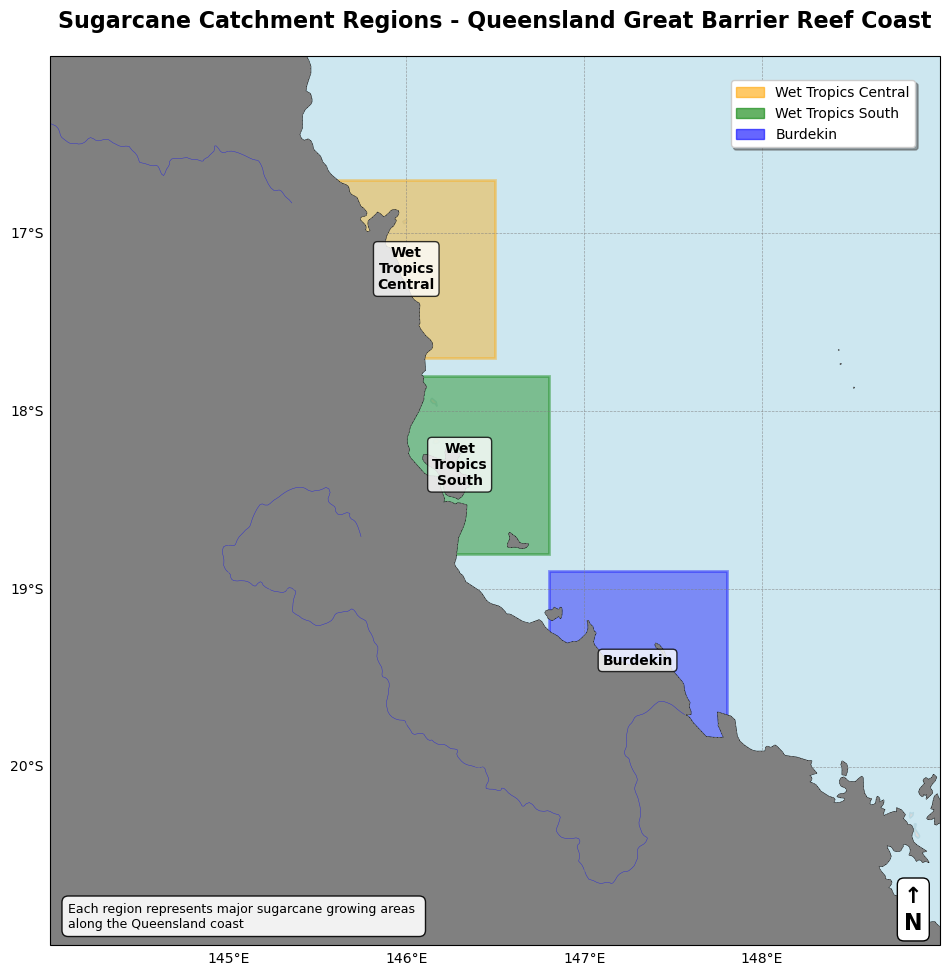

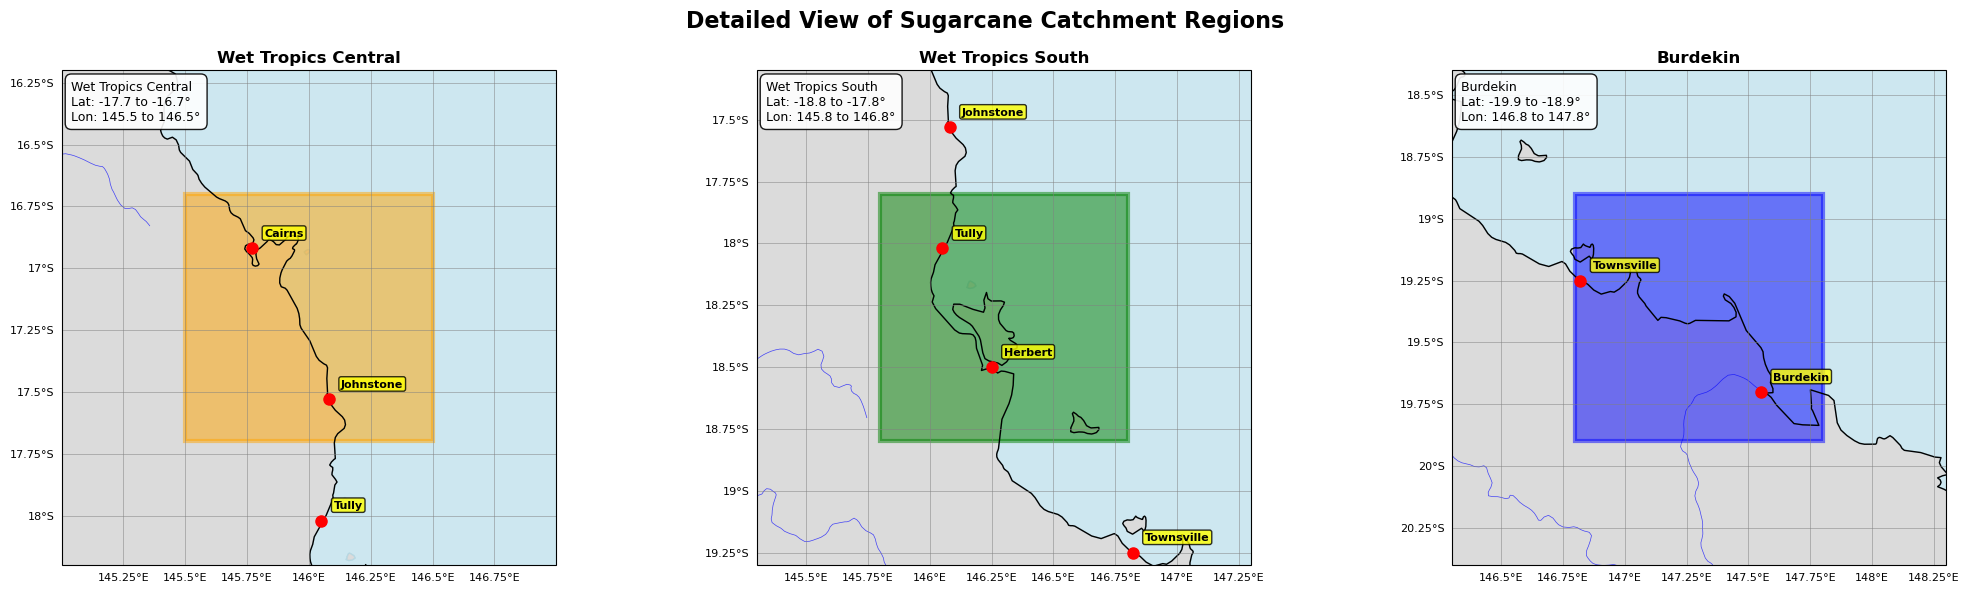

In [7]:
# Main execution
if __name__ == "__main__":
    
    # Print summary information
    print_region_summary()
    
    # Create overview map
    print("\nCreating overview map of all sugarcane regions...")
    create_sugarcane_regions_map(sugarcane_regions, reference_cities=None, map_extent=map_extent, region_colors=region_colors)
    
    # Create detailed view of each region
    print("\nCreating detailed view of individual regions...")
    create_detailed_region_map(sugarcane_regions, reference_cities, region_colors)

# Time Series Plots

## Variable Concentration Time Series

In [4]:
def get_var_metadata(ncdata, var_name):
    """
    Extract metadata attributes of a variable in a NetCDF dataset into a dictionary.

    Parameters
    ----------
    ncdata : netCDF4.Dataset
        Open NetCDF dataset.
    var_name : str
        Name of the variable (e.g., 'mean_wspeed').

    Returns
    -------
    dict
        Dictionary with all attributes of the variable.
    """
    var = ncdata[var_name]
    var_dict = {attr: getattr(var, attr) for attr in var.ncattrs()}
    
    return var_dict

In [5]:
def extract_regional_timeseries(ncdata, variable_name, region_bounds, depth_index=-1, agg_method='mean'):
    """
    Extract spatially-averaged time series data from netCDF datasets with 1D or 2D coordinate
    systems for a specified geographic region and depth layer.

    Parameters:
    -----------
    ncdata : netCDF4.Dataset.variables
        NetCDF dataset variables containing coordinates and data.
    variable_name : str
        Name of variable to extract (e.g., 'DIN', 'salt', 'temp').
    region_bounds : dict
        Dict with 'lat_range' and 'lon_range' tuples defining region bounds.
        Example: {'lat_range': (-20, -15), 'lon_range': (145, 150)}
    depth_index : int, optional
        Depth layer index (-1 for surface). Default is -1.
    agg_method : str, optional
        Aggregation method for spatial data: 'mean', 'max', 'min', 'median', 'std', 'sum'.
        Default is 'mean'.

    Returns:
    --------
    time_series : numpy.ndarray
        Array of spatially-aggregated values over time.
    dates : list
        List of datetime objects for each time step.

    Raises:
    -------
    ValueError
        If variable data has unexpected number of dimensions,
        if agg_method is not recognized, or if coordinate format is unsupported.
    KeyError
        If required coordinate variables or the specified variable_name are not found.

    Dependencies:
    -------------
    - numpy (as np) : Array operations, meshgrid creation, statistical functions
    - netCDF4 : Time conversion utilities (num2date)
    - pandas (as pd) : Datetime conversion and handling

    Notes:
    ------
    - Handles both AIMS format (1D coordinates) and standard format (2D coordinates)
    - Automatically detects coordinate dimensionality
    - For 1D: Uses meshgrid to create 2D spatial mask
    - For 2D: Directly applies mask to coordinate arrays
    - Handles both 3D (time, lat, lon) and 4D (time, depth, lat, lon) data structures
    - Converts masked arrays to regular arrays, replacing masked values with NaN
    - Uses numpy's nan-aware functions for statistics
    
    Coordinate Formats Supported:
    ------------------------------
    1D coordinates: latitude[latitude], longitude[longitude]
    2D coordinates: latitude[j, i], longitude[j, i]
    """
    
    # Define available aggregation methods
    agg_functions = {
        'mean': np.nanmean,
        'max': np.nanmax,
        'min': np.nanmin,
        'median': np.nanmedian,
        'std': np.nanstd,
        'sum': np.nansum
    }
    
    # Validate aggregation method
    if agg_method not in agg_functions:
        raise ValueError(f"Unknown agg_method '{agg_method}'. Must be one of: {list(agg_functions.keys())}")
    
    agg_func = agg_functions[agg_method]
    
    # Get coordinate arrays and detect dimensionality
    lat_data = ncdata['latitude'][:]
    lon_data = ncdata['longitude'][:]
    
    # Detect coordinate format
    if lat_data.ndim == 1 and lon_data.ndim == 1:
        # 1D coordinates (AIMS format)
        print(f"  Detected 1D coordinates: lat{lat_data.shape}, lon{lon_data.shape}")
        lat_grid, lon_grid = np.meshgrid(lat_data, lon_data, indexing='ij')
        
    elif lat_data.ndim == 2 and lon_data.ndim == 2:
        # 2D coordinates (standard format)
        print(f"  Detected 2D coordinates: lat{lat_data.shape}, lon{lon_data.shape}")
        lat_grid = lat_data
        lon_grid = lon_data
        
    else:
        raise ValueError(f"Unsupported coordinate dimensions: "
                        f"latitude is {lat_data.ndim}D, longitude is {lon_data.ndim}D. "
                        f"Expected both 1D or both 2D.")
    
    # Create 2D spatial mask (same for both 1D and 2D coordinates)
    spatial_mask = ((lat_grid >= region_bounds['lat_range'][0]) & 
                    (lat_grid <= region_bounds['lat_range'][1]) &
                    (lon_grid >= region_bounds['lon_range'][0]) & 
                    (lon_grid <= region_bounds['lon_range'][1]))
    
    print(f"  Spatial mask: {np.sum(spatial_mask)} grid points selected")
    
    # Get the variable data
    var_data = ncdata[variable_name]
    n_times = var_data.shape[0]
    
    # Determine data structure
    if var_data.ndim == 4:
        data_structure = "(time, depth, j, i)" if lat_data.ndim == 2 else "(time, depth, lat, lon)"
    elif var_data.ndim == 3:
        data_structure = "(time, j, i)" if lat_data.ndim == 2 else "(time, lat, lon)"
    else:
        raise ValueError(f"Unexpected data dimensions: {var_data.ndim}D. Expected 3D or 4D.")
    
    print(f"  Variable structure: {data_structure}, shape: {var_data.shape}")
    
    # Extract time information
    time_var = ncdata['time']
    dates = netCDF4.num2date(time_var[:], time_var.units)
    dates = [pd.to_datetime(str(date)) for date in dates]
    
    time_series = []
    
    for t in range(n_times):
        # Extract data for this time step and depth
        if var_data.ndim == 4:  # (time, depth, j, i) or (time, depth, lat, lon)
            data_slice = var_data[t, depth_index, :, :]
        elif var_data.ndim == 3:  # (time, j, i) or (time, lat, lon)
            data_slice = var_data[t, :, :]
        
        # Apply spatial mask and calculate aggregate
        regional_data = data_slice[spatial_mask]
        
        # Convert masked array to regular array, replacing masked values with NaN
        if hasattr(regional_data, 'filled'):
            regional_data = regional_data.filled(np.nan)
            
        # Calculate aggregate using specified method, ignoring NaN values
        agg_value = agg_func(regional_data)
        time_series.append(agg_value)
    
    return np.array(time_series), dates

In [6]:
# Record agg_method in metadata 
agg_method = 'mean'
import json

metadata = {
    'aggregation_method': agg_method
}

with open("timeseries_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

### Cache

In [7]:
def create_cache_filename(years, variable_name, months=None, depth_index=-1, agg_method='mean', cache_dir='data_cache'):
    """
    Generate a standardized cache filename for netCDF data storage based on 
    variable name, time period, month filtering, and aggregation method.

    Parameters:
    -----------
    years : int, list, or tuple
        Year(s) for the data. Single year or range of years.
    variable_name : str
        Name of the climate/weather variable (e.g., 'DIN', 'temperature').
    months : list or None, optional
        Specific months to include (1-12). If None, assumes all months. Default is None.
    depth_index : int, optional
        Depth layer index (-1 for surface). Default is -1.
    agg_method : str, optional
        Aggregation method used ('mean', 'max', 'min', 'median', 'std', 'sum'). Default is 'mean'.
    cache_dir : str, optional
        Directory path for cache storage. Default is 'data_cache'.

    Returns:
    --------
    str
        Complete file path with standardized naming convention.

    Notes:
    ------
    - Uses pickle format (.pkl) for efficient data serialization
    - Year ranges automatically formatted as "min_year-max_year"
    - Month numbers are sorted to ensure consistent naming
    - Filename format: "{variable}_{years}_{months}.pkl"

    Example:
    --------
    >>> create_cache_filename(2023, 'temperature')
    'data_cache/temperature_2023_all_aggmean.pkl'
    
    >>> create_cache_filename([2020, 2022], 'DIN', months=[6,7,8], agg_method='max')
    'data_cache/DIN_2020-2022_months_6-7-8_aggmax.pkl'
    """
    if isinstance(years, (list, tuple)):
        year_str = f"{min(years)}-{max(years)}" # Handle year ranges
    else:
        year_str = str(years) #Handle single year
    
    if months is None:
        month_str = "all"
    else:
        # Sort months and join with hyphens for consistent naming
        month_str = f"months_{'-'.join(map(str, sorted(months)))}"
    
    filename = f"{variable_name}_{year_str}_{month_str}_DI{depth_index}_agg{agg_method}.pkl"
    return os.path.join(cache_dir, filename)

In [8]:
def save_data_to_cache(data, dates, var_dict, years, variable_name, months=None, depth_index=-1,
                       agg_method='mean', cache_dir='data_cache'): 
    """
    Save extracted netCDF data and metadata to a pickle cache file for faster future access.

    Parameters:
    -----------
    data : numpy.ndarray
        Processed regional time series data to be cached.
    dates : list
        List of datetime objects corresponding to the time series.
    var_dict : dict
        Dictionary containing variable metadata from the original netCDF file.
    years : int, list, or tuple
        Year(s) covered by the dataset.
    variable_name : str
        Name of the cached variable (e.g., 'DIN', 'temperature').
    months : list, optional
        Specific months included in the data. Default is None (all months).
    depth_index : int, optional
        Depth layer index (-1 for surface). Default is -1.
    agg_method : str, optional
        Aggregation method used for the cached data. Default is 'mean'.
    cache_dir : str, optional
        Directory for cache storage. Default is 'data_cache'.

    Returns:
    --------
    str
        Full path to the created cache file.

    Notes:
    ------
    - Creates cache directory automatically if it doesn't exist
    - Stores processing timestamp for cache management
    - Uses pickle format for efficient serialization of numpy arrays and datetime objects
    - Cache filename follows standardized naming convention via create_cache_filename()

    Example:
    --------
    >>> cache_path = save_data_to_cache(
    ...     timeseries_data, date_list, metadata, 
    ...     [2020, 2021], 'DIN', months=[6,7,8]
    ... )
    Data cached to: data_cache/DIN_2020-2021_months_6-7-8.pkl
    """
    # Create cache directory if it doesn't exist
    Path(cache_dir).mkdir(exist_ok=True)
    
    # Generate standardized filename based on parameters
    cache_file = create_cache_filename(years, variable_name, months, depth_index, agg_method, cache_dir)


    # Bundle all data and metadata into dictionary for storage
    cache_data = {
        'regional_data': data,
        'dates': dates,
        'var_dict': var_dict, # Original netCDF metadata
        'years': years,
        'variable_name': variable_name,
        'months': months,
        'depth_index': depth_index,
        'agg_method': agg_method,
        'cache_date': pd.Timestamp.now() # Track when cache was created
    }
    
    # Serialize and save to file
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)
    
    print(f"Data cached to: {cache_file}")
    return cache_file

In [9]:
def load_data_from_cache(years, variable_name, months=None, depth_index=-1, agg_method='mean', cache_dir='data_cache'):  # EDITED: Added agg_method
    """
    Load previously cached netCDF data and metadata from pickle file if available.

    Parameters:
    -----------
    years : int, list, or tuple
        Year(s) for the cached data to retrieve.
    variable_name : str
        Name of the variable to load from cache (e.g., 'DIN', 'temperature').
    months : list or None, optional
        Specific months to load. If None, loads all months. Default is None.
    depth_index : int, optional
        Depth layer index (-1 for surface). Default is -1.
    agg_method : str, optional
        Aggregation method for the cached data to load. Default is 'mean'.
    cache_dir : str, optional
        Directory where cache files are stored. Default is 'data_cache'.

    Returns:
    --------
    tuple of (numpy.ndarray, list, dict) or (None, None, None)
        If cache exists: (regional_data, dates, var_dict)
        If cache missing or corrupted: (None, None, None)

    Notes:
    ------
    - Uses same filename convention as save_data_to_cache() for consistency
    - Displays cache creation timestamp when successfully loaded
    - Returns tuple format matches extract_regional_timeseries() output

    Example:
    --------
    >>> data, dates, metadata = load_data_from_cache(2023, 'DIN', months=[6,7,8])
    Loaded data from cache: data_cache/DIN_2023_months_6-7-8.pkl
    Cache created: 2024-03-15 14:30:22
    """
    # Generate expected cache filename using same convention
    cache_file = create_cache_filename(years, variable_name, months, depth_index, agg_method, cache_dir) 
    
    if os.path.exists(cache_file):
        try:
            # Attempt to load pickled data
            with open(cache_file, 'rb') as f:
                cache_data = pickle.load(f)
            
            # Added verification check
            cached_agg = cache_data.get('agg_method', 'mean')
            if cached_agg != agg_method:
                print(f"Warning: Cache aggregation mismatch (cached={cached_agg}, requested={agg_method})")
                return None, None, None
            cached_depth = cache_data.get('depth_index', -1)
            if cached_depth != depth_index:
                print(f"Warning: Cache depth index mismatch (cached={cached_depth}, requested={depth_index})")
                return None, None, None            
            print(f"Loaded data from cache: {cache_file}")
            print(f"Cache created: {cache_data['cache_date']}")
            print(f"Depth Index: {cached_depth}")
            print(f"Aggregation method: {cached_agg}")

            # Return the three main data components
            return (cache_data['regional_data'], 
                   cache_data['dates'], 
                   cache_data['var_dict'])
        except Exception as e:
            print(f"Error loading cache file {cache_file}: {e}") #handle corrupted file
            return None, None, None
    
    return None, None, None

In [10]:
def list_cached_files(cache_dir='data_cache'):
    """
    Display a formatted list of all cached data files with their metadata
    for easy cache management and verification.

    Parameters:
    -----------
    cache_dir : str, optional
        Directory containing cache files to list. Default is 'data_cache'.

    Returns:
    --------
    None
        Prints cache information directly to console.

    Notes:
    ------
    - Only displays .pkl files (ignores other file types)
    - Shows key metadata: variable name, time period, months, creation date
    - Files are displayed in alphabetical order for consistent presentation

    Example:
    --------
    >>> list_cached_files()
    
    Cached files in data_cache:
    --------------------------------------------------
        DIN_2020-2023_months_6-7-8.pkl
        Variable: DIN
        Years: 2020-2023
        Months: [6, 7, 8]
        Created: 2024-03-15 14:30:22
    
        temperature_2023_all.pkl
        Variable: temperature
        Years: 2023
        Months: all
        Created: 2024-03-14 09:15:45
    """
    # Check if cache directory exists
    if not os.path.exists(cache_dir):
        print(f"Cache directory {cache_dir} does not exist.")
        return

    # Filter for pickle files only
    cache_files = [f for f in os.listdir(cache_dir) if f.endswith('.pkl')]
    
    if not cache_files:
        print(f"No cache files found in {cache_dir}")
        return
    
    print(f"\nCached files in {cache_dir}:")
    print("-" * 50)
    
    # Process files in alphabetical order
    for cache_file in sorted(cache_files):
        file_path = os.path.join(cache_dir, cache_file)
        try:
            with open(file_path, 'rb') as f:
                cache_data = pickle.load(f)
            
            years = cache_data['years']
            if isinstance(years, list):
                year_str = f"{min(years)}-{max(years)}" if len(years) > 1 else str(years[0])
            else:
                year_str = str(years)
            
            # Display formatted file information
            print(f"  {cache_file}")
            print(f"    Variable: {cache_data['variable_name']}")
            print(f"    Years: {year_str}")
            print(f"    Months: {cache_data.get('months', 'all')}")
            print(f"    Depth Index: {cache_data.get('depth_index', -1)}")
            print(f"    Aggregation: {cache_data.get('agg_method', 'mean')}")
            print(f"    Created: {cache_data['cache_date']}")
            print()
            
        except Exception as e:
            print(f"  {cache_file} - Error reading: {e}")

### Multiple years time series

In [11]:
def load_multiyear_data(years, months_to_process, variable_name, dataset_template, depth_index=-1,
                       agg_method='mean', use_cache=True, cache_dir='data_cache'):
    """
    Load and combine netCDF data across multiple years and months with caching support
    for efficient data processing of large climate datasets.

    Parameters:
    -----------
    years : list or int
        Year(s) to process. Single integer or list of years (e.g., [2015, 2016, 2017]).
    months_to_process : list of int
        Month numbers to include (1-12). E.g., [1, 2, 3] for Jan-Mar.
    variable_name : str
        Variable to extract from netCDF files (e.g., 'DIN', 'temperature').
    dataset_template : str
        URL template with {datestr} placeholder for file paths.
    depth_index : int, optional
        Depth layer index (-1 for surface). Default is -1.
    agg_method : str, optional
        Aggregation method for spatial data: 'mean', 'max', 'min', 'median', 'std', 'sum'.
        Default is 'mean'.
    use_cache : bool, optional
        Whether to check for and save cached data. Default is True.
    cache_dir : str, optional
        Directory for cache storage. Default is 'data_cache'.

    Returns:
    --------
    tuple of (dict, list, dict)
        - all_regional_data: Dict with region names as keys, time series arrays as values
        - all_dates: Combined list of datetime objects across all files
        - var_dict: Variable metadata dictionary from netCDF files

    Notes:
    ------
    - Checks cache first if use_cache=True, returns cached data if available
    - Cache filenames include agg_method and depth index to prevent conflicts between different aggregations
    - Processes files in chronological order (sorted years, sequential months)
    - Combines data from all regions defined in global sugarcane_regions
    - Automatically converts data to numpy arrays with float64 for consistency
    - Saves results to cache after successful loading
    - Skips missing files or variables without stopping execution

    Example:
    --------
    >>> template = "https://data.aims.gov.au/geoserver/gbr4_v2/{datestr}.nc"
    >>> # Load data with maximum values instead of mean
    >>> data, dates, metadata = load_multiyear_data(
    ...     [2020, 2021], [6, 7, 8], 'DIN', template, agg_method='max'
    ... )
    Loading DIN data (agg: max) for years [2020, 2021]...
    Processing year 2020...
        Processing 2020-06...
        Processing 2020-07...
    ...
    Data loading completed. Total time steps: 184
    """
    # Ensure years is a list
    if isinstance(years, int):
        years = [years]
    
    # Check cache first (include agg_method in cache key)
    if use_cache:
        cached_data, cached_dates, cached_var_dict = load_data_from_cache(
            years, variable_name, months_to_process, depth_index=depth_index, agg_method=agg_method, cache_dir=cache_dir
        )
        if cached_data is not None:
            return cached_data, cached_dates, cached_var_dict
    
    # If no cache or not using cache, load from source
    all_regional_data = {region: [] for region in sugarcane_regions.keys()}
    all_dates = []
    var_dict = None
    
    print(f"Loading {variable_name} data (agg: {agg_method}) for years {years}...")
    
    # Process each year in chronological order
    for year in sorted(years):
        print(f"Processing year {year}...")
        
        for month in months_to_process:
            netCDF_datestr = f"{year}-{month:02d}"
            inputFile = dataset_template.format(datestr=netCDF_datestr)
            
            print(f"  Processing {netCDF_datestr}...")
            
            try:
                # Open the netCDF file
                with Dataset(inputFile, 'r') as nc_data:
                    ncdata = nc_data.variables
                    
                    # Check if variable exists in this file
                    if variable_name not in ncdata.keys():
                        print(f"    Warning: {variable_name} not found in {netCDF_datestr}")
                        continue

                    # Retrieve metadata based on variable (only need to do this once)
                    if var_dict is None:
                        var_dict = get_var_metadata(ncdata, variable_name)

                    # Extract data for each region
                    for region_name, bounds in sugarcane_regions.items():
                        try:
                            regional_ts, dates = extract_regional_timeseries(
                                ncdata, variable_name, bounds, depth_index=depth_index, 
                                agg_method=agg_method
                            )
                            
                            # Append to overall dataset
                            regional_ts_numeric = np.array(regional_ts)
                            all_regional_data[region_name].extend(regional_ts_numeric.tolist())
                            
                            # Only add dates once (from first region) to avoid duplicate
                            if region_name == list(sugarcane_regions.keys())[0]:
                                all_dates.extend(dates)
                                
                        except Exception as e:
                            print(f"    Error processing {region_name} for {netCDF_datestr}: {e}")
                            
            except Exception as e:
                print(f"    Error opening file for {netCDF_datestr}: {e}")
                continue
    
    # Convert lists to numpy arrays
    for region_name in all_regional_data.keys():
        try:
            all_regional_data[region_name] = np.array(all_regional_data[region_name])
        except (ValueError, TypeError) as e:
            print(f"Warning: Data type error for {region_name}, converting to float64: {e}")
            # Convert problematic values to NaN
            cleaned_data = []
            for val in all_regional_data[region_name]:
                try:
                    cleaned_data.append(float(val))
                except (ValueError, TypeError):
                    cleaned_data.append(np.nan)
            all_regional_data[region_name] = np.array(cleaned_data, dtype=np.float64)
    
    print(f"Data loading completed. Total time steps: {len(all_dates)}")
    
    # Save to cache if requested (include agg_method in cache)
    if use_cache and len(all_dates) > 0:
        save_data_to_cache(all_regional_data, all_dates, var_dict, 
                          years, variable_name, months_to_process, depth_index=depth_index,
                          agg_method=agg_method, cache_dir=cache_dir)
    
    return all_regional_data, all_dates, var_dict

In [12]:
def filter_data_by_years(all_regional_data, all_dates, target_years):
    """
    Filter multi-year time series data to retain only specified years
    for focused analysis of specific time periods.

    Parameters:
    -----------
    all_regional_data : dict
        Dictionary with region names as keys and time series arrays as values.
    all_dates : list
        List of datetime objects corresponding to the time series data.
    target_years : list, tuple, or int
        Year(s) to retain in the filtered dataset. Single year or list of years.

    Returns:
    --------
    tuple of (dict, list)
        - filtered_regional_data: Dict with same structure but filtered time series
        - filtered_dates: List of datetime objects for the retained time periods

    Notes:
    ------
    - Uses pandas datetime indexing for efficient year-based filtering
    - Handles mismatched time series lengths (shorter than date array)
    - Maintains original data structure and region names
    - Boolean masking preserves chronological order of remaining data

    Example:
    --------
    >>> # Filter 5-year dataset to only 2020-2021
    >>> filtered_data, filtered_dates = filter_data_by_years(
    ...     regional_data, date_list, [2020, 2021]
    ... )
    >>> len(filtered_dates)  # Much shorter than original
    24
    """
    # Ensure target_years is iterable for consistent processing
    if not isinstance(target_years, (list, tuple)):
        target_years = [target_years]
    
    # Convert to pandas datetime index for easier filtering
    dates_series = pd.Series(all_dates)
    year_mask = dates_series.dt.year.isin(target_years)
    
    # Filter dates using boolean mask
    filtered_dates = [all_dates[i] for i in range(len(all_dates)) if year_mask.iloc[i]]
    
    filtered_regional_data = {}
    for region_name, timeseries in all_regional_data.items():
        if len(timeseries) >= len(all_dates): # Standard case: time series matches date array length
            filtered_data = timeseries[year_mask.values]
            filtered_regional_data[region_name] = filtered_data
        else:
            # Handle case where timeseries is shorter than dates
            mask_subset = year_mask[:len(timeseries)]
            filtered_regional_data[region_name] = timeseries[mask_subset.values]
    
    return filtered_regional_data, filtered_dates

In [13]:
def calculate_multiyear_monthly_means(all_regional_data, all_dates):
    """
    Calculate long-term monthly averages across multiple years for seasonal
    analysis of regional climate patterns.

    Parameters:
    -----------
    all_regional_data : dict
        Dictionary with region names as keys and time series arrays as values.
    all_dates : list
        List of datetime objects corresponding to the time series data.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with 12 rows (months) and columns for each region.
        Index contains month abbreviations (Jan, Feb, ..., Dec).
        Values are mean concentrations/measurements across all years.

    Notes:
    ------
    - Groups data by calendar month regardless of year
    - Uses pandas groupby for efficient monthly aggregation
    - Handles regions with different data lengths by truncating to date array
    - Returns empty DataFrame if no valid data is provided
    - Month names replace numeric indices for better readability

    Example:
    --------
    >>> monthly_avg = calculate_multiyear_monthly_means(regional_data, dates)
    >>> print(monthly_avg.loc['Jun'])  # June averages for all regions
    Region_A    0.15
    Region_B    0.23
    Region_C    0.18
    Name: Jun, dtype: float64
    """
    # Create DataFrame with all data
    df_data = {}
    for region_name, timeseries in all_regional_data.items():
        if len(timeseries) > 0:
            df_data[region_name] = timeseries[:len(all_dates)]
    
    if not df_data:
        return pd.DataFrame()
    
    # Create DataFrame with datetime index
    df = pd.DataFrame(df_data, index=pd.DatetimeIndex(all_dates[:len(list(df_data.values())[0])]))
    
    # Group by month and calculate mean across all years
    monthly_means = df.groupby(df.index.month).mean()
    
    # Set month names as index
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_means.index = [month_names[i-1] for i in monthly_means.index]
    
    return monthly_means

In [21]:
def plot_multiyear_analysis(all_regional_data, all_dates, years, variable_name, var_dict, agg_method='mean',
                           plot_years=None, multiyear_monthly=False, show_aggregate='none'):
    """
    Create dual-panel visualization for multi-year climate data analysis with
    time series and monthly averaging options.

    Parameters:
    -----------
    all_regional_data : dict
        Dictionary with region names as keys and time series arrays as values.
    all_dates : list
        List of datetime objects corresponding to the time series data.
    years : list
        List of all years available in the dataset for title formatting.
    variable_name : str
        Name of the variable being plotted (e.g., 'DIN', 'temperature').
    var_dict : dict
        Variable metadata containing 'long_name' and 'units' keys.
    agg_method : str, optional
        Aggregation method used for spatial data: 'mean', 'max', 'min', 'median', 'std', 'sum'.
        Default is 'mean'.
    plot_years : list, tuple, int, or None, optional
        Specific year(s) to plot. If None, plots all available data.
    multiyear_monthly : bool, optional
        If True, creates multi-year monthly averages. If False, uses 
        standard monthly resampling. Default is False.
    show_aggregate : str, optional
        Whether to show an aggregate line across all regions:
        - 'none': No aggregate line (default)
        - 'sum': Show sum/accumulated across all regions (good for DIN)
        - 'mean': Show average across all regions (good for temp, salt)
        Default is 'none'.

    Returns:
    --------
    None
        Creates and displays matplotlib figure with two subplots and saves PNG file.

    Notes:
    ------
    - Top panel: Time series line plot for all regions (+ optional aggregate)
    - Bottom panel: Monthly averages (aggregated or resampled based on multiyear_monthly)
    - Automatically filters data when plot_years is specified
    - Uses global region_colors dictionary for region color mapping if available, 
      otherwise falls back to default 6-color cycle
    - Aggregate line (if enabled) is shown in bold black with distinct styling
    - Saves figure as PNG with descriptive filename
    - Handles empty datasets by skipping problematic regions

    Dependencies:
    -------------
    - matplotlib.pyplot (as plt) : Plotting functionality
    - pandas (as pd) : Data manipulation and resampling
    - numpy (as np) : Array operations for aggregation
    - datetime : Timestamp generation for filenames
    
    Global Variables (optional):
    -----------------------------
    - region_colors : dict, optional
        Global dictionary mapping region names to matplotlib color codes.
        Example: {'Wet Tropics Central': 'b', 'Burdekin': 'g'}
        If not defined or region not found, uses default color cycle.

    Example:
    --------
    >>> # DIN with accumulated total across regions
    >>> plot_multiyear_analysis(din_data, dates, years, 'DIN', meta, 
    ...                         agg_method='max', show_aggregate='sum')
    
    >>> # Temperature with average across regions
    >>> plot_multiyear_analysis(temp_data, dates, years, 'temp', meta,
    ...                         agg_method='mean', show_aggregate='mean')
    
    >>> # Salt without aggregate line
    >>> plot_multiyear_analysis(salt_data, dates, years, 'salt', meta,
    ...                         agg_method='min', show_aggregate='none')
    """
    
    # Validate show_aggregate parameter
    if show_aggregate not in ['none', 'sum', 'mean']:
        raise ValueError(f"show_aggregate must be 'none', 'sum', or 'mean', got '{show_aggregate}'")
    
    # Filter data if specific years requested for plotting
    if plot_years is not None:
        plot_data, plot_dates = filter_data_by_years(all_regional_data, all_dates, plot_years)
        title_years = plot_years if isinstance(plot_years, (list, tuple)) else [plot_years]
    else:
        plot_data = all_regional_data
        plot_dates = all_dates
        title_years = years
    
    # Create aggregation method label
    agg_label = agg_method.capitalize()
    var_with_agg = f"{variable_name} ({agg_label})"
    
    # Create the plot (dual-panel figure)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Time series for all regions
    # Use global region_colors if available, otherwise fall back to default colors
    default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Store data for aggregate calculation
    all_region_arrays = []
    max_length = 0
    
    for i, (region_name, timeseries) in enumerate(plot_data.items()):
        if len(timeseries) > 0:  # Only plot if we have data
            # Check if region has a defined color in global region_colors
            if 'region_colors' in globals() and region_name in region_colors:
                color = region_colors[region_name]
            else:
                color = default_colors[i % len(default_colors)]

            ax1.plot(plot_dates[:len(timeseries)], timeseries, 
                    label=region_name, color=color, 
                    linewidth=1.5, alpha=0.8)
            
            # Store for aggregate calculation
            all_region_arrays.append(timeseries)
            max_length = max(max_length, len(timeseries))
    
    # Calculate and plot aggregate line if requested
    if show_aggregate != 'none' and len(all_region_arrays) > 0:
        # Align all arrays to same length (pad with NaN)
        aligned_arrays = []
        for arr in all_region_arrays:
            if len(arr) < max_length:
                padded = np.full(max_length, np.nan)
                padded[:len(arr)] = arr
                aligned_arrays.append(padded)
            else:
                aligned_arrays.append(arr)
        
        # Stack arrays
        stacked_data = np.array(aligned_arrays)
        
        # Calculate aggregate
        if show_aggregate == 'sum':
            aggregate_values = np.nansum(stacked_data, axis=0)
            aggregate_label = f'Total Across Regions ({agg_label})'
            aggregate_color = 'black'
        elif show_aggregate == 'mean':
            aggregate_values = np.nanmean(stacked_data, axis=0)
            aggregate_label = f'Average Across Regions ({agg_label})'
            aggregate_color = 'darkred'
        
        # Plot aggregate line with distinct styling
        ax1.plot(plot_dates[:max_length], aggregate_values, 
                label=aggregate_label, color=aggregate_color, 
                linewidth=1.5, alpha=0.5, linestyle='--', zorder=5)
    
    # Format title for year range
    if len(title_years) == 1:
        year_str = str(title_years[0])
    else:
        year_str = f"{min(title_years)}-{max(title_years)}"
    
    # Configure top panel with aggregation method
    title_suffix = ""
    if show_aggregate == 'sum':
        title_suffix = " (with Total)"
    elif show_aggregate == 'mean':
        title_suffix = " (with Average)"
    
    ax1.set_title(f'{var_dict["long_name"]} ({agg_label}) in Sugarcane Catchments - {year_str}{title_suffix}', 
                 fontsize=16, fontweight='bold')
    ax1.set_ylabel(f'{var_with_agg} ({var_dict["units"]})', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Monthly averages
    if len(plot_dates) > 0:
        if multiyear_monthly:
            # Use filtered data for multi-year monthly means when plot_years is specified
            if plot_years is not None:
                # Use the filtered data for multi-year monthly averaging
                monthly_means = calculate_multiyear_monthly_means(plot_data, plot_dates)
                title_year_range = f"({min(title_years)}-{max(title_years)})"
            else:
                # Use all data for multi-year monthly averaging
                monthly_means = calculate_multiyear_monthly_means(all_regional_data, all_dates)
                title_year_range = f"({min(years)}-{max(years)})"
            
            if not monthly_means.empty:
                # Plot each region with matching colors from ax1
                for i, region_name in enumerate(monthly_means.columns):
                    if 'region_colors' in globals() and region_name in region_colors:
                        color = region_colors[region_name]
                    else:
                        color = default_colors[i % len(default_colors)]
                    
                    ax2.plot(range(len(monthly_means.index)), monthly_means[region_name], 
                            marker='o', linewidth=2, label=region_name, color=color)
                
                # Add aggregate line to bottom panel if requested
                if show_aggregate == 'sum':
                    aggregate_monthly = monthly_means.sum(axis=1)
                    ax2.plot(range(len(monthly_means.index)), aggregate_monthly,
                            marker='s', linewidth=3, label='Total Across Regions',
                            color='black', linestyle='--', markersize=8, zorder=10)
                elif show_aggregate == 'mean':
                    aggregate_monthly = monthly_means.mean(axis=1)
                    ax2.plot(range(len(monthly_means.index)), aggregate_monthly,
                            marker='s', linewidth=3, label='Average Across Regions',
                            color='darkred', linestyle='--', markersize=8, zorder=10)
                
                ax2.set_title(f'Multi-Year Monthly Average of {var_dict["long_name"]} ({agg_label}) {title_year_range}', 
                             fontsize=16, fontweight='bold')
                ax2.set_xlabel('Month', fontsize=12)
                ax2.set_xticks(range(len(monthly_means.index)))
                ax2.set_xticklabels(monthly_means.index, rotation=0)
        else:
            # Original single-year or filtered-year monthly means
            df_data = {}
            for region_name, timeseries in plot_data.items():
                if len(timeseries) > 0:
                    df_data[region_name] = timeseries[:len(plot_dates)]
            
            if df_data:
                # Create DataFrame and resample by month-end
                df = pd.DataFrame(df_data, index=plot_dates[:len(list(df_data.values())[0])])
                monthly_means = df.resample('M').mean()
                
                # Plot individual regions
                for i, region_name in enumerate(monthly_means.columns):
                    if 'region_colors' in globals() and region_name in region_colors:
                        color = region_colors[region_name]
                    else:
                        color = default_colors[i % len(default_colors)]
                    
                    ax2.plot(monthly_means.index, monthly_means[region_name],
                            marker='o', linewidth=2, label=region_name, color=color)
                
                # Add aggregate line to bottom panel if requested
                if show_aggregate == 'sum':
                    aggregate_monthly = monthly_means.sum(axis=1)
                    ax2.plot(monthly_means.index, aggregate_monthly,
                            marker='s', linewidth=1.5, label='Total Across Regions',
                            color='black', linestyle='--', markersize=8, zorder=5)
                elif show_aggregate == 'mean':
                    aggregate_monthly = monthly_means.mean(axis=1)
                    ax2.plot(monthly_means.index, aggregate_monthly,
                            marker='s', linewidth=1.5, label='Average Across Regions',
                            color='darkred', linestyle='--', markersize=8, zorder=5)
                
                ax2.set_title(f'Monthly Average of {var_dict["long_name"]} ({agg_label}) - {year_str}', 
                             fontsize=16, fontweight='bold')
                ax2.set_xlabel('Month', fontsize=12)
                ax2.tick_params(axis='x', rotation=45)

        # Configure bottom panel with aggregation method
        ax2.set_ylabel(f'Average {var_with_agg} ({var_dict["units"]})', fontsize=12)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # Include aggregation method and aggregate type in filename
    agg_suffix = f"_{show_aggregate}" if show_aggregate != 'none' else ""
    filename = f'{var_with_agg} over time ({year_str}){agg_suffix}_{timestamp}.png'

    fig.savefig(filename)

In [16]:
def print_summary_statistics(all_regional_data, years, variable_name, var_dict):
    """
    Display comprehensive statistical summary of regional time series data.

    Parameters:
    -----------
    all_regional_data : dict
        Dictionary with region names as keys and time series arrays as values.
    years : list or int
        Year(s) covered by the dataset for header formatting.
    variable_name : str
        Name of the variable for labeling (e.g., 'DIN', 'temperature').
    var_dict : dict
        Variable metadata dictionary containing 'units' key for proper labeling.

    Returns:
    --------
    None
        Prints formatted statistical summary directly to console.

    Notes:
    ------
    - Automatically excludes NaN values from statistical calculations
    - Shows data availability (number of valid data points) per region
    - Displays mean, standard deviation, minimum, and maximum values
    - Uses consistent decimal formatting (3 decimal places) for readability
    - Skips regions with no valid data points

    """
    if len(years) == 1:
        year_str = str(years[0])
    else:
        year_str = f"{min(years)}-{max(years)}"
    
    print("\n" + "="*60)
    print(f"SUMMARY STATISTICS FOR {year_str}")
    print("="*60)
    
    for region_name, timeseries in all_regional_data.items():
        if len(timeseries) > 0:
            valid_data = timeseries[~np.isnan(timeseries)]
            if len(valid_data) > 0:
                print(f"\n{region_name}:")
                print(f"  Data points: {len(valid_data)}")
                print(f"  Mean {variable_name}: {np.mean(valid_data):.3f} {var_dict['units']}")
                print(f"  Std Dev:  {np.std(valid_data):.3f} {var_dict['units']}")
                print(f"  Min:      {np.min(valid_data):.3f} {var_dict['units']}")
                print(f"  Max:      {np.max(valid_data):.3f} {var_dict['units']}")

### Execution

Step 1: Loading multi-year data (2011-2018) using max
Loaded data from cache: data_cache/DIN_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
Cache created: 2025-09-29 23:46:23.687716
Depth Index: -1
Aggregation method: max

Step 2: Multi-year plot with multi-year monthly averaging

SUMMARY STATISTICS FOR 2011-2018

Wet Tropics Central:
  Data points: 2922
  Mean DIN: 24.997 mg N m-3
  Std Dev:  32.792 mg N m-3
  Min:      0.133 mg N m-3
  Max:      329.839 mg N m-3

Wet Tropics South:
  Data points: 2922
  Mean DIN: 207.055 mg N m-3
  Std Dev:  247.628 mg N m-3
  Min:      0.251 mg N m-3
  Max:      2669.008 mg N m-3

Burdekin:
  Data points: 2922
  Mean DIN: 73.388 mg N m-3
  Std Dev:  90.787 mg N m-3
  Min:      0.188 mg N m-3
  Max:      992.902 mg N m-3

Cached files in data_cache:
--------------------------------------------------
  DIN_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
    Variable: DIN
    Years: 2011-2018
    Months: [1, 2, 3, 4, 5, 6, 7, 8

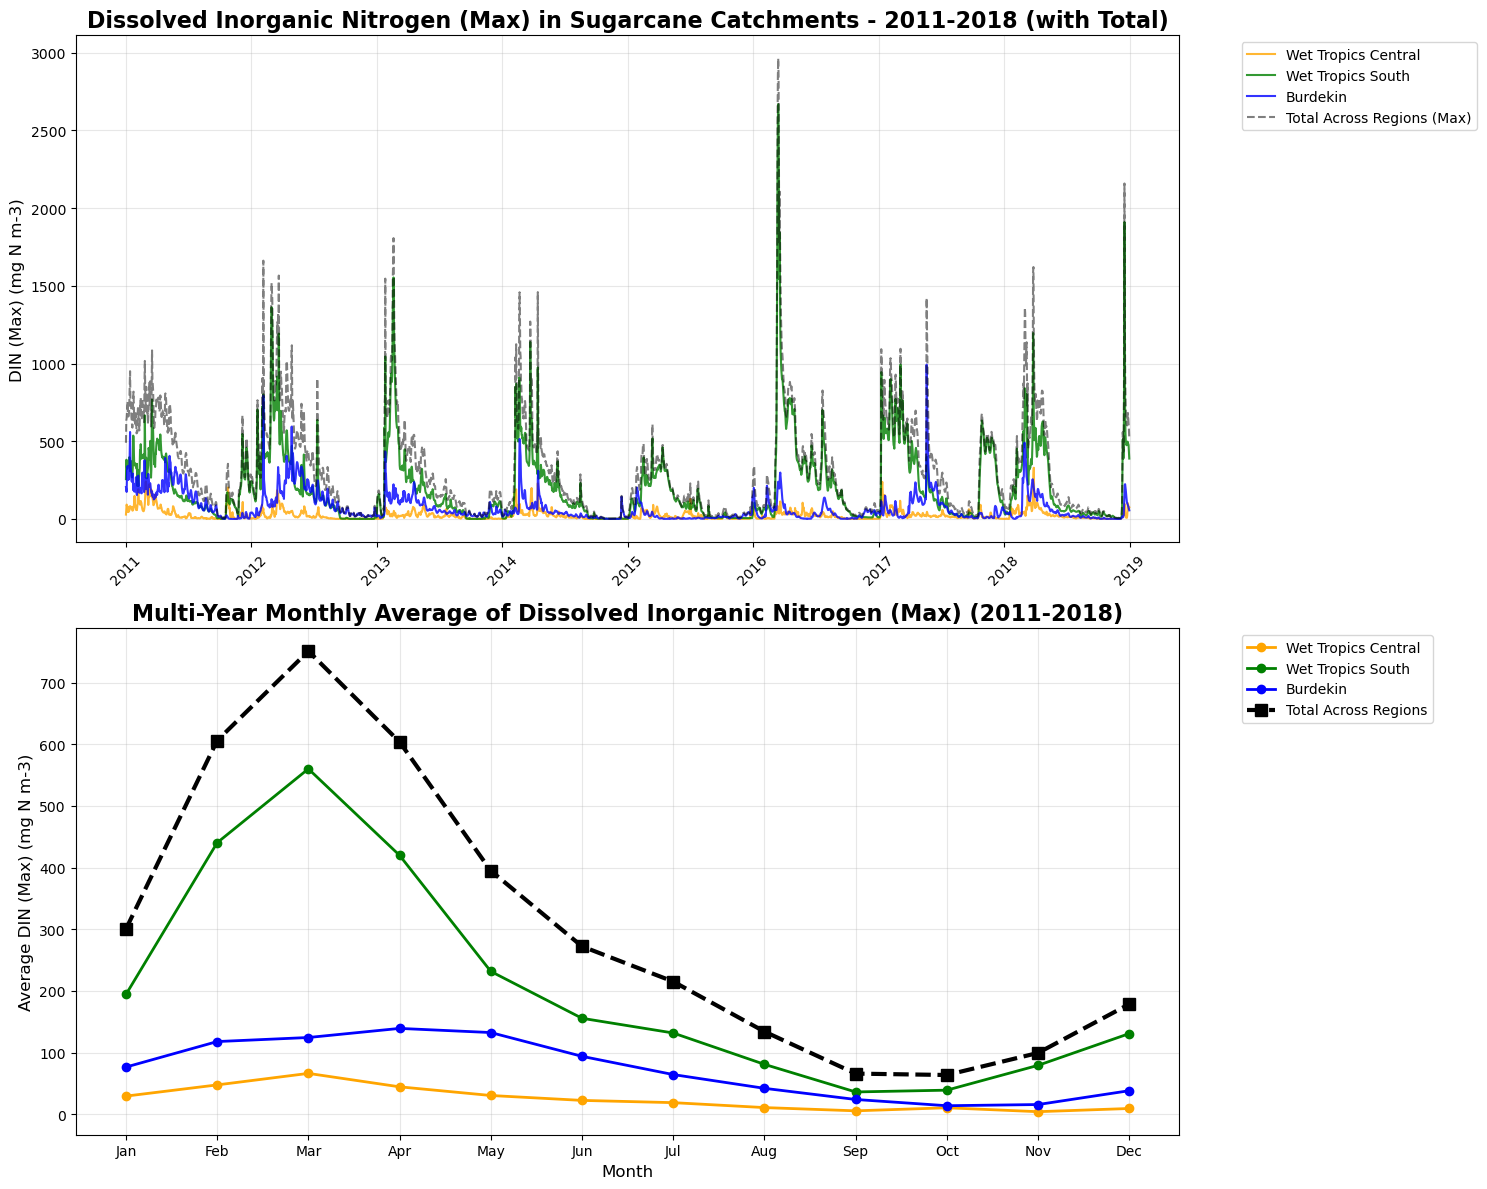

In [23]:
# Example usage and main execution
if __name__ == "__main__":
    # Define these variables based on your setup
    # sugarcane_regions = {...}  # Region definitions
    # get_var_metadata = ...     # Metadata function
    
    # Choose dataset template
    dataset_template = (
        "https://thredds.ereefs.aims.gov.au/thredds/dodsC/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/"
        "daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"
        "{datestr}.nc"
    )
    
    # Parameters
    depth_index = -1 # sea surface
    variable_name = 'DIN'
    months_to_process = list(range(1, 13))  # All months
    years_full = [2011,2012,2013,2014,2015, 2016, 2017, 2018] # All full years in dataset
    plot_years = [2012]
    #can also be multi-years
    # plot_years=[2016,2017,2018]
    
    # Choose aggregation method: 'mean', 'max', 'min', 'median', 'std', 'sum'
    agg_method = 'max'
    
    # Step 1: Load multi-year data (eg. 2011-2018) with caching
    print("="*60)
    print(f"Step 1: Loading multi-year data ({years_full[0]}-{years_full[-1]}) using {agg_method}")
    print("="*60)
    
    all_data, all_dates, var_dict = load_multiyear_data(
        years_full, months_to_process, variable_name, dataset_template, 
        depth_index=depth_index,
        agg_method=agg_method, 
        use_cache=True, 
        cache_dir='data_cache'
    )
    
    # Step 2: Plot full multi-year range with multi-year monthly averaging
    print("\n" + "="*60)
    print("Step 2: Multi-year plot with multi-year monthly averaging")
    print("="*60)
    
    plot_multiyear_analysis(
        all_data, all_dates, years_full, variable_name, var_dict, agg_method=agg_method,
        plot_years=None, multiyear_monthly=True, show_aggregate='sum'
    )

    # #  Alternative Utilisations
    # #  Alternative 1. Plot just one year from the multi-year dataset
    # print("\n" + "="*60)
    # print(f"Plotting {plot_years} data from multi-year dataset")
    # print("="*60)
    
    # plot_multiyear_analysis(
    #     all_data, all_dates, years_full, variable_name, var_dict, agg_method=agg_method,
    #     plot_years=plot_years, multiyear_monthly=False
    # )
    
    #  # Alternative 2. Plot subset of years (eg. 2016-2018) with multi-year monthly averaging
    # print("\n" + "="*60)
    # print("Subset years with multi-year monthly averaging")
    # print("="*60)
    
    # plot_multiyear_analysis(
    #     all_data, all_dates, years_full, variable_name, var_dict, agg_method=agg_method,
    #     plot_years=plot_years, multiyear_monthly=True
    # )
    
    # Print summary statistics
    print_summary_statistics(all_data, years_full, variable_name, var_dict)
    
    # List cached files
    list_cached_files('data_cache')
    

## Coral Growth Trend

In [28]:
def plot_coral_cover_trends(csv_file, year_range=None, catchments=None, group_category='hard coral',
                           highlight_maxmin=True, highlight_worst_year=False, highlight_best_year=False,
                           output_filename=None, show_plot=True, figsize=(16, 10)):
    """
    Plot coral cover trends over time by NRM region and catchment with flexible highlighting options
    
    Creates a line plot showing coral cover trends over time with configurable highlighting of
    key data points and years. Supports filtering by year range and specific catchments.
    
    Parameters:
    -----------
    csv_file : str
        Path to the coral data CSV file
    year_range : tuple of int, optional
        Year range as (start_year, end_year) inclusive. If None, uses all available years.
    catchments : list of str, optional
        List of catchment names to include. If None, includes all catchments.
        Catchment names are case-insensitive.
    group_category : str, default 'hard coral'
        Coral group category to analyze ('hard coral', 'soft coral', 'algae', 'others', 'all')
    highlight_maxmin : bool, default True
        Whether to highlight and label the maximum and minimum cover points with colored dots and text
    highlight_worst_year : bool, default False
        Whether to highlight the worst performing year with a vertical red dashed line
    highlight_best_year : bool, default False
        Whether to highlight the best performing year with a vertical green dashed line
    output_filename : str, optional
        Output filename for saved plot. If None, defaults to 'coral_cover_trends.png'.
    show_plot : bool, default True
        Whether to display the plot interactively.
    figsize : tuple, default (16, 10)
        Figure size as (width, height) in inches.
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    summary_stats : dict
        Dictionary containing comprehensive statistics:
        - max_cover: dict with value, year, region, catchment
        - min_cover: dict with value, year, region, catchment  
        - worst_year: int (year with lowest average cover)
        - best_year: int (year with highest average cover)
        - data_points: int (number of data points plotted)
        - year_range: tuple (actual min/max years in data)
        - catchments_included: list of catchment names
        - average_cover_all_years: float (overall mean)
        
    Raises:
    -------
    FileNotFoundError
        If the CSV file cannot be found
    ValueError
        If specified catchments are not found in the data or no data remains after filtering
    KeyError
        If required columns are missing from the CSV
        
    Notes:
    ------
    - Each line represents one NRM_REGION/CATCHMENT combination
    - Max/min highlighting: green dot for max, red dot for min with text labels
    - Year highlighting: vertical dashed lines (red=worst, green=best)
    - Legend positioned outside plot area on the right
    - X-axis shows years with 45° rotation
    - Grid enabled for better readability
    - Best/worst years determined by average cover across all filtered data for each year
    
    Examples:
    --------
    >>> # Basic plot with max/min highlighting
    >>> fig, stats = plot_coral_cover_trends('coraldata.csv')
    
    >>> # Focus on specific catchments with year lines
    >>> fig, stats = plot_coral_cover_trends(
            'coraldata.csv',
            year_range=(2011, 2018),
            catchments=['Burdekin', 'Tully', 'Johnstone'],
            highlight_maxmin=False,
            highlight_worst_year=True,
            highlight_best_year=True
        )
    
    >>> # All highlighting options enabled
    >>> fig, stats = plot_coral_cover_trends(
            'coraldata.csv',
            catchments=['Tully'],
            highlight_maxmin=True,
            highlight_worst_year=True,
            highlight_best_year=True
        )
    """
    
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.ticker import FuncFormatter
    
    # Set defaults
    if output_filename is None:
        output_filename = 'coral_cover_trends.png'
    
    try:
        # Load and prepare data
        df = pd.read_csv(csv_file)
        df.columns = df.columns.str.strip()
        
        # Check required columns
        required_cols = ['YEAR_CODE', 'COVER', 'GROUP_CODE', 'NRM_REGION', 'CATCHMENT']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise KeyError(f"Missing required columns: {missing_cols}")
        
        # Clean and convert year data
        df['YEAR_CODE'] = pd.to_numeric(df['YEAR_CODE'], errors='coerce')
        df = df.dropna(subset=['YEAR_CODE'])
        df['YEAR_CODE'] = df['YEAR_CODE'].astype(int)
        
        # Filter by group category
        if group_category.lower() != 'all':
            df = df[df['GROUP_CODE'].str.lower() == group_category.lower()]
            if len(df) == 0:
                available_groups = sorted(pd.read_csv(csv_file)['GROUP_CODE'].unique())
                raise ValueError(f"No data found for group '{group_category}'. Available groups: {available_groups}")
        
        # Filter by year range
        if year_range is not None:
            start_year, end_year = year_range
            df = df[(df['YEAR_CODE'] >= start_year) & (df['YEAR_CODE'] <= end_year)]
            if len(df) == 0:
                available_years = sorted(pd.read_csv(csv_file)['YEAR_CODE'].dropna().astype(int).unique())
                raise ValueError(f"No data found for years {start_year}-{end_year}. Available years: {available_years}")
        
        # Filter by catchments
        if catchments is not None:
            # Make comparison case-insensitive
            catchments_lower = [c.lower() for c in catchments]
            available_catchments = df['CATCHMENT'].unique()
            
            # Check if any requested catchments exist
            df_catchments_lower = df['CATCHMENT'].str.lower()
            mask = df_catchments_lower.isin(catchments_lower)
            
            if not mask.any():
                print(f"Error: None of the requested catchments found in data.")
                print(f"Requested: {catchments}")
                print(f"Available catchments: {sorted(available_catchments)}")
                return None, None
            
            df = df[mask]
            
            # Warn about missing catchments
            found_catchments = df['CATCHMENT'].str.lower().unique()
            missing_catchments = [c for c in catchments_lower if c not in found_catchments]
            if missing_catchments:
                print(f"Warning: Catchments not found: {missing_catchments}")
                print(f"Available catchments: {sorted(available_catchments)}")
        
        # Group by YEAR_CODE, NRM_REGION, and CATCHMENT, compute mean COVER
        grouped = df.groupby(['YEAR_CODE', 'NRM_REGION', 'CATCHMENT'], as_index=False)['COVER'].mean()
        
        if len(grouped) == 0:
            print("No data remaining after filtering")
            return None, None
        
        # Create plot
        fig = plt.figure(figsize=figsize)
        
        # Plot lines for each region/catchment combination
        for (region, catchment), group_data in grouped.groupby(['NRM_REGION', 'CATCHMENT']):
            plt.plot(
                group_data['YEAR_CODE'],
                group_data['COVER'],
                marker='o',
                label=f"{region} / {catchment}"
            )
        
        # Initialize statistics
        cover_max = grouped.loc[grouped['COVER'].idxmax()]
        cover_min = grouped.loc[grouped['COVER'].idxmin()]
        
        # Calculate best/worst years (average across all catchments for each year)
        yearly_avg = grouped.groupby('YEAR_CODE')['COVER'].mean()
        best_year = yearly_avg.idxmax()
        worst_year = yearly_avg.idxmin()
        best_year_cover = yearly_avg.max()
        worst_year_cover = yearly_avg.min()

        # Highlight max/min points if requested
        if highlight_maxmin:
            plt.scatter(cover_max['YEAR_CODE'], cover_max['COVER'], color='green', s=100, zorder=5, label='Max Cover Point')
            plt.scatter(cover_min['YEAR_CODE'], cover_min['COVER'], color='red', s=100, zorder=5, label='Min Cover Point')
            
            # Get y-limits for text positioning
            ymin, ymax = plt.ylim()
            
            # Add Max label — position within y-limit
            max_y = cover_max['COVER'] + 0.5
            if max_y > ymax:
                max_y = ymax - 1
            
            plt.text(cover_max['YEAR_CODE'], max_y,
                     f"Max: {cover_max['COVER']:.1f}%\n{cover_max['NRM_REGION']} / {cover_max['CATCHMENT']} ({int(cover_max['YEAR_CODE'])})",
                     color='green', fontsize=10, ha='center')
            
            # Add Min label — position within y-limit
            min_y = cover_min['COVER'] - 7
            if min_y < ymin:
                min_y = ymin + 0.2
            
            plt.text(cover_min['YEAR_CODE'], min_y,
                     f"Min: {cover_min['COVER']:.1f}%\n{cover_min['NRM_REGION']} / {cover_min['CATCHMENT']} ({int(cover_min['YEAR_CODE'])})",
                     color='red', fontsize=10, ha='center')
        
        # Highlight worst year if requested
        if highlight_worst_year:
            plt.axvline(x=worst_year, color='red', linestyle='--', linewidth=2, 
                       label=f'Worst Year: {int(worst_year)} ({worst_year_cover:.1f}% avg)')
        
        # Highlight best year if requested  
        if highlight_best_year:
            plt.axvline(x=best_year, color='green', linestyle='--', linewidth=2,
                       label=f'Best Year: {int(best_year)} ({best_year_cover:.1f}% avg)')
        
        # Create title with filter information
        filter_info = f"{group_category.title()}"
        if year_range:
            filter_info += f" ({year_range[0]}-{year_range[1]})"
        if catchments:
            filter_info += f" - Selected Catchments"
        
        # Add highlighting info to title
        highlight_methods = []
        if highlight_maxmin:
            highlight_methods.append("Max/Min Points")
        if highlight_worst_year or highlight_best_year:
            year_highlights = []
            if highlight_worst_year:
                year_highlights.append("Worst")
            if highlight_best_year:
                year_highlights.append("Best")
            highlight_methods.append(f"{'/'.join(year_highlights)} Years")
        
        title = f'{filter_info} Coral Cover Trends'
        if highlight_methods:
            title += f" - Highlighting: {', '.join(highlight_methods)}"
        
        plt.title(title, fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Average Coral Cover (%)', fontsize=14)
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        plt.tight_layout()
        plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
        
        # Save plot
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        
        if show_plot:
            plt.show()
        
        # Print summary based on enabled highlights
        if highlight_maxmin:
            print(f"Max cover: {cover_max['COVER']:.2f}% in {int(cover_max['YEAR_CODE'])} "
                  f"({cover_max['NRM_REGION']} / {cover_max['CATCHMENT']})")
            print(f"Min cover: {cover_min['COVER']:.2f}% in {int(cover_min['YEAR_CODE'])} "
                  f"({cover_min['NRM_REGION']} / {cover_min['CATCHMENT']})")
        
        if highlight_worst_year:
            print(f"Worst year: {int(worst_year)} with average {group_category} cover: {worst_year_cover:.2f}%")
        
        if highlight_best_year:
            print(f"Best year: {int(best_year)} with average {group_category} cover: {best_year_cover:.2f}%")
        
        # Prepare comprehensive summary statistics
        summary_stats = {
            'max_cover': {
                'value': float(cover_max['COVER']),
                'year': int(cover_max['YEAR_CODE']),
                'region': str(cover_max['NRM_REGION']),
                'catchment': str(cover_max['CATCHMENT'])
            },
            'min_cover': {
                'value': float(cover_min['COVER']),
                'year': int(cover_min['YEAR_CODE']),
                'region': str(cover_min['NRM_REGION']),
                'catchment': str(cover_min['CATCHMENT'])
            },
            'best_year': {
                'year': int(best_year),
                'average_cover': float(best_year_cover)
            },
            'worst_year': {
                'year': int(worst_year),
                'average_cover': float(worst_year_cover)
            },
            'data_points': len(grouped),
            'year_range': (int(grouped['YEAR_CODE'].min()), int(grouped['YEAR_CODE'].max())),
            'catchments_included': [str(c) for c in sorted(grouped['CATCHMENT'].unique())],
            'average_cover_all_years': float(grouped['COVER'].mean()),
            'highlighting_enabled': {
                'maxmin_points': highlight_maxmin,
                'worst_year_line': highlight_worst_year,
                'best_year_line': highlight_best_year
            }
        }
        
        return fig, summary_stats
        
    except Exception as e:
        print(f"Error creating coral cover trends plot: {e}")
        return None, None

In [29]:
# Convenience functions for common use cases
def plot_trends_with_points(csv_file, **kwargs):
    """
    Convenience function to plot trends with max/min point highlighting only
    """
    return plot_coral_cover_trends(csv_file, highlight_maxmin=True, 
                                 highlight_worst_year=False, highlight_best_year=False, **kwargs)


def plot_trends_with_year_lines(csv_file, **kwargs):
    """
    Convenience function to plot trends with best/worst year line highlighting only
    """
    return plot_coral_cover_trends(csv_file, highlight_maxmin=False, 
                                 highlight_worst_year=True, highlight_best_year=True, **kwargs)


def plot_trends_all_highlights(csv_file, **kwargs):
    """
    Convenience function to plot trends with all highlighting options enabled
    """
    return plot_coral_cover_trends(csv_file, highlight_maxmin=True, 
                                 highlight_worst_year=True, highlight_best_year=True, **kwargs)

In [30]:
# Example usage function
def analyze_three_catchments_example():
    """
    Example function showing different highlighting options for the three main catchments
    """
    catchments = ['Johnstone', 'Tully', 'Burdekin']
    years = (2011, 2018)
    
    print("=== Analysis 1: Max/Min Points Only ===")
    fig1, stats1 = plot_trends_with_points(
        'coraldata.csv',
        year_range=years,
        catchments=catchments,
        output_filename='three_catchments_points.png'
    )
    
    print("\n=== Analysis 2: Best/Worst Year Lines Only ===")
    fig2, stats2 = plot_trends_with_year_lines(
        'coraldata.csv',
        year_range=years,
        catchments=catchments,
        output_filename='three_catchments_years.png'
    )
    
    print("\n=== Analysis 3: All Highlights ===")
    fig3, stats3 = plot_trends_all_highlights(
        'coraldata.csv',
        year_range=years,
        catchments=catchments,
        output_filename='three_catchments_complete.png'
    )
    
    return fig1, fig2, fig3, stats1, stats2, stats3

### Execution

In [31]:
catchments = ['Johnstone', 'Tully', 'Burdekin' ]
year_range = (2011, 2018)

=== Analysis 1: Max/Min Points Only ===
Max cover: 40.83% in 2016 (Wet Tropics / Johnstone)
Min cover: 6.89% in 2012 (Wet Tropics / Tully)


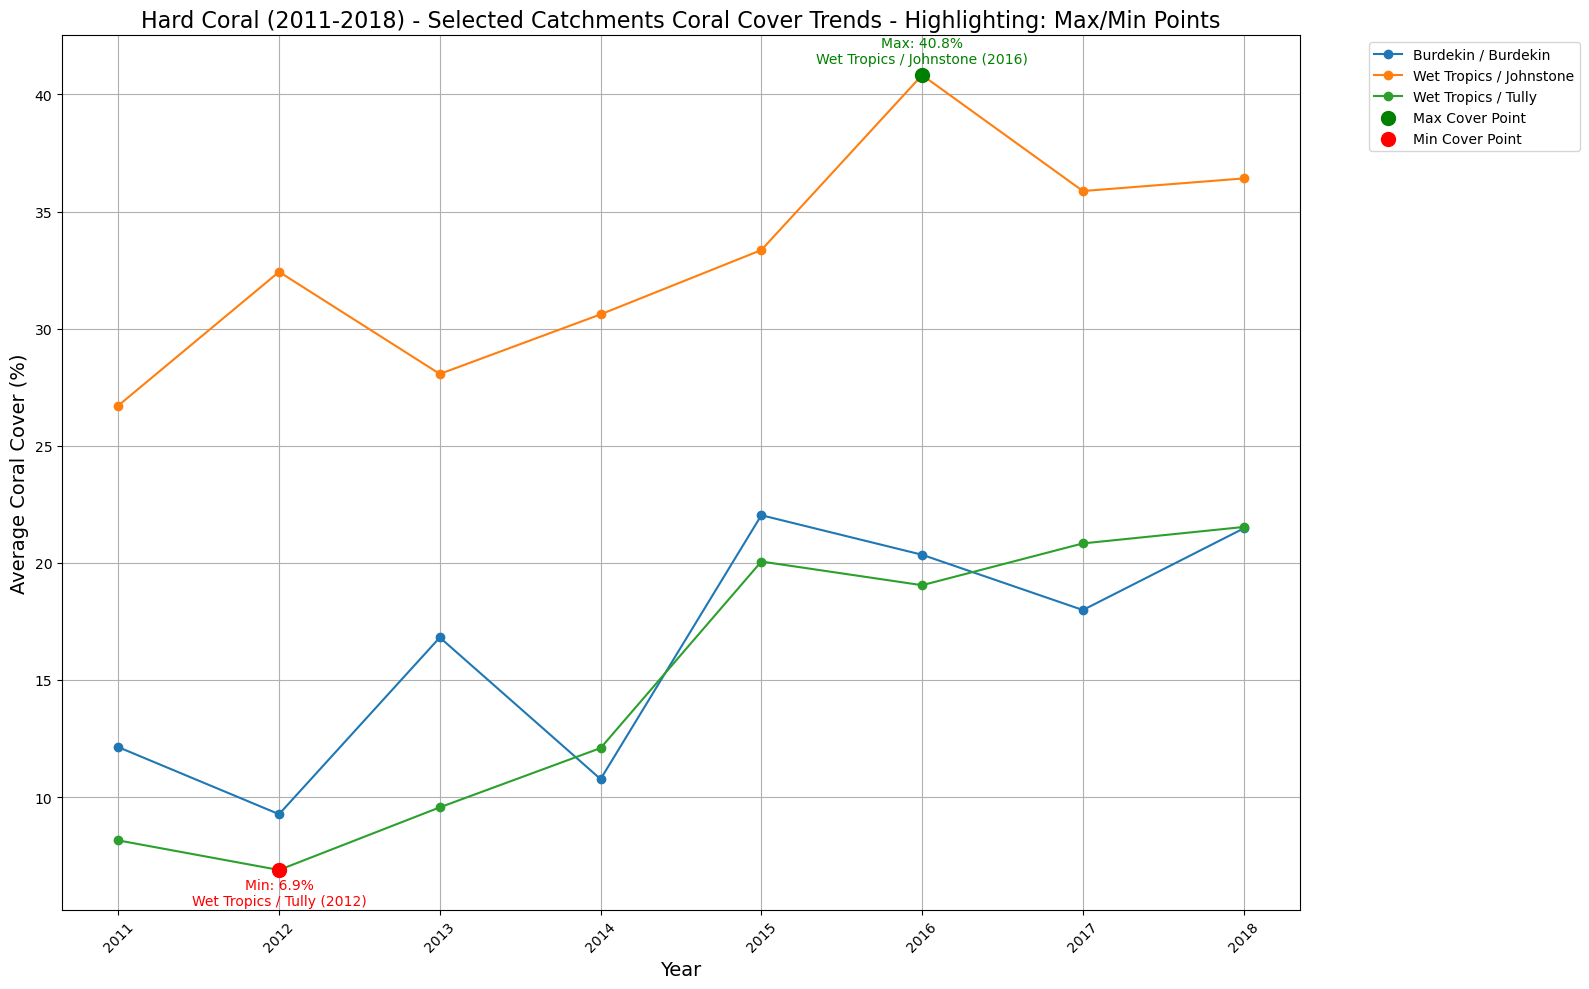

In [32]:
print("=== Analysis 1: Max/Min Points Only ===")
fig1, stats1 = plot_trends_with_points(
    'coraldata.csv',
    year_range=year_range,
    catchments=catchments,
    output_filename='coral_cover_maxmin_points.png'
)


=== Analysis 2: Best/Worst Year Lines Only ===
Worst year: 2011 with average hard coral cover: 15.67%
Best year: 2016 with average hard coral cover: 26.74%


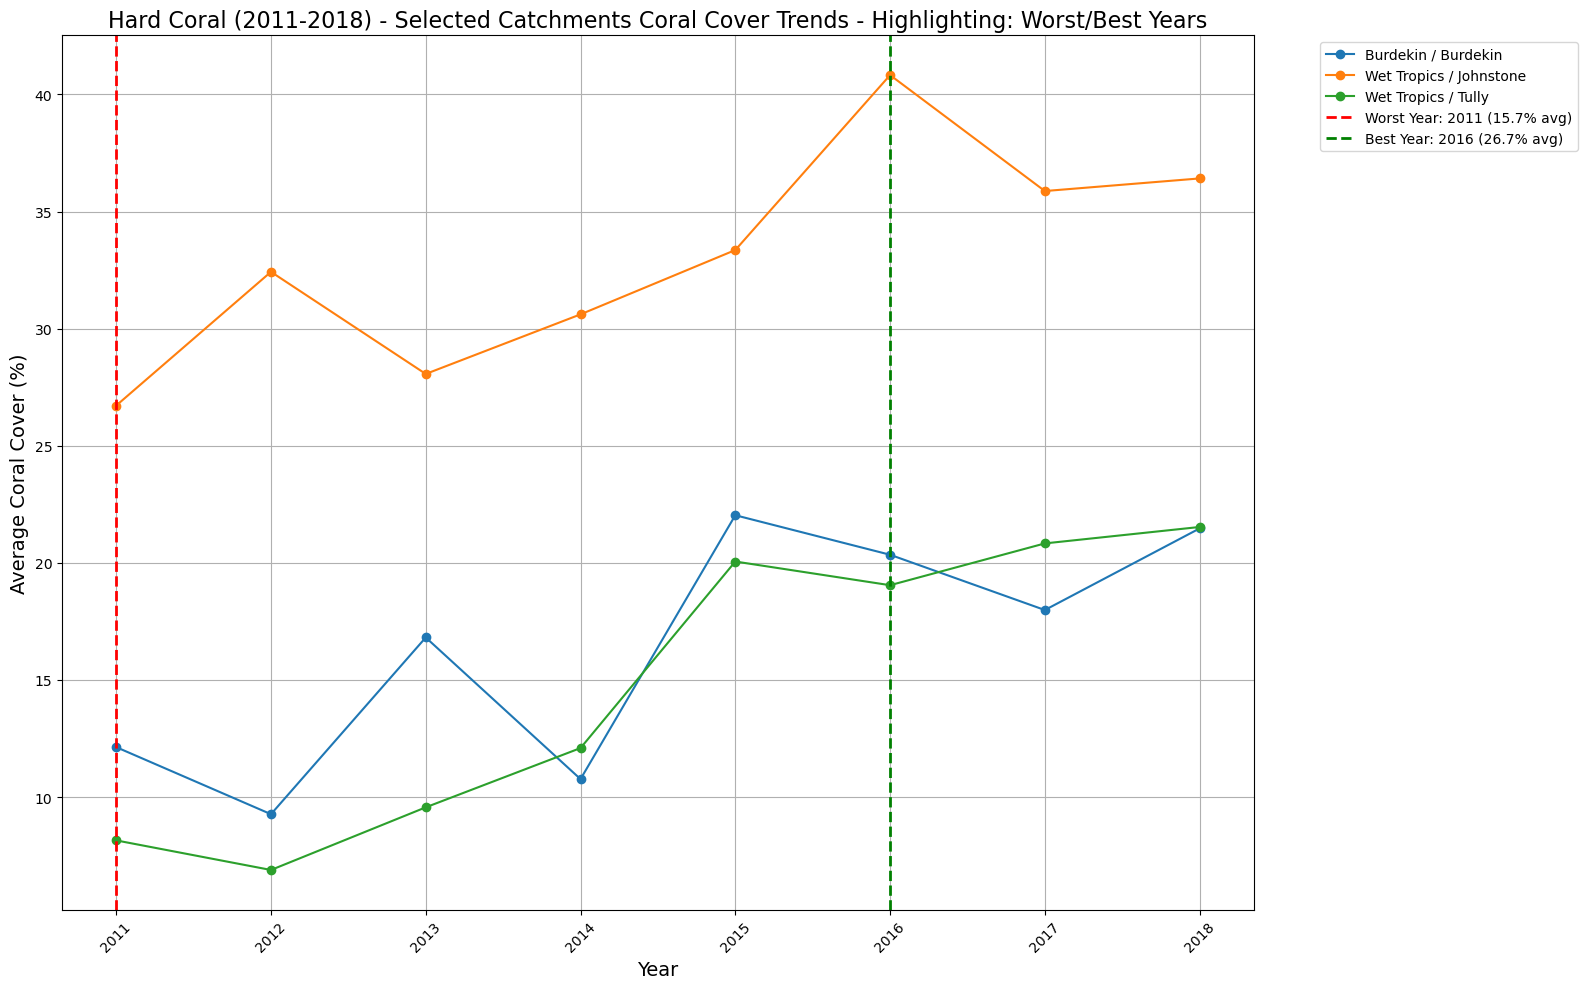

In [33]:
print("\n=== Analysis 2: Best/Worst Year Lines Only ===")
fig2, stats2 = plot_trends_with_year_lines(
    'coraldata.csv',
    year_range=year_range,
    catchments=catchments,
    output_filename='coral_cover_bestworse_years.png'
)


=== Analysis 3: All Highlights ===
Max cover: 40.83% in 2016 (Wet Tropics / Johnstone)
Min cover: 6.89% in 2012 (Wet Tropics / Tully)
Worst year: 2011 with average hard coral cover: 15.67%
Best year: 2016 with average hard coral cover: 26.74%


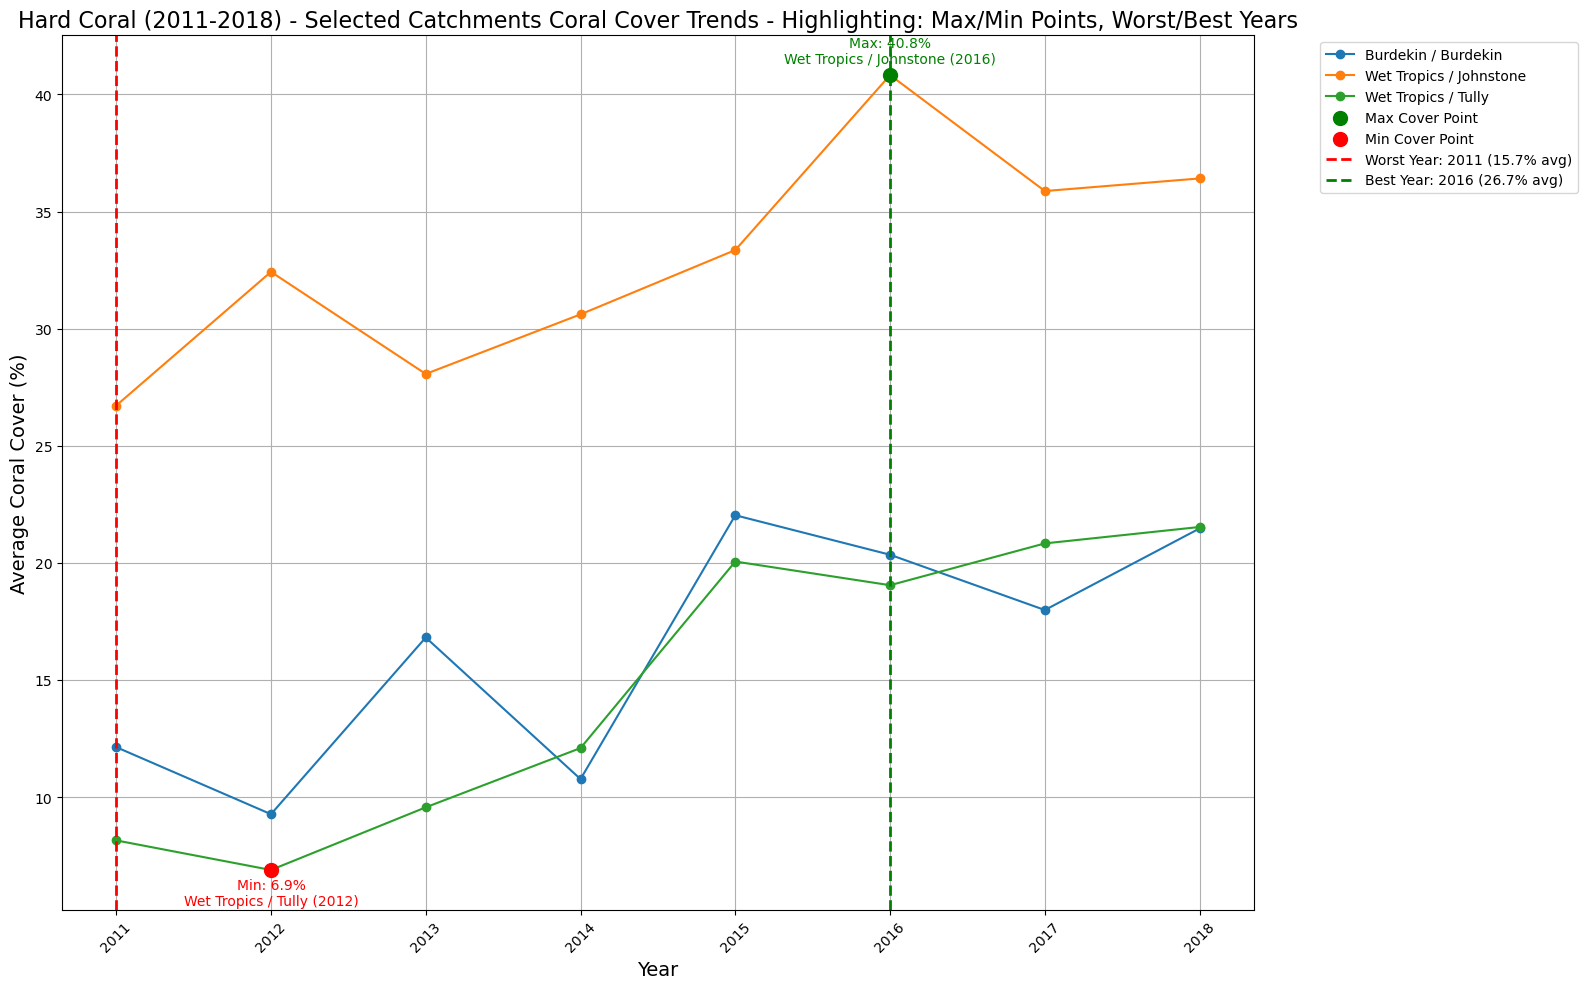

In [34]:
print("\n=== Analysis 3: All Highlights ===")
fig3, stats3 = plot_trends_all_highlights(
    'coraldata.csv',
    year_range=year_range,
    catchments=catchments,
    output_filename='coral_cover_all_highlight.png'
    )


=== Analysis 4: Worse Only ===
Max cover: 40.83% in 2016 (Wet Tropics / Johnstone)
Min cover: 6.89% in 2012 (Wet Tropics / Tully)
Worst year: 2011 with average hard coral cover: 15.67%


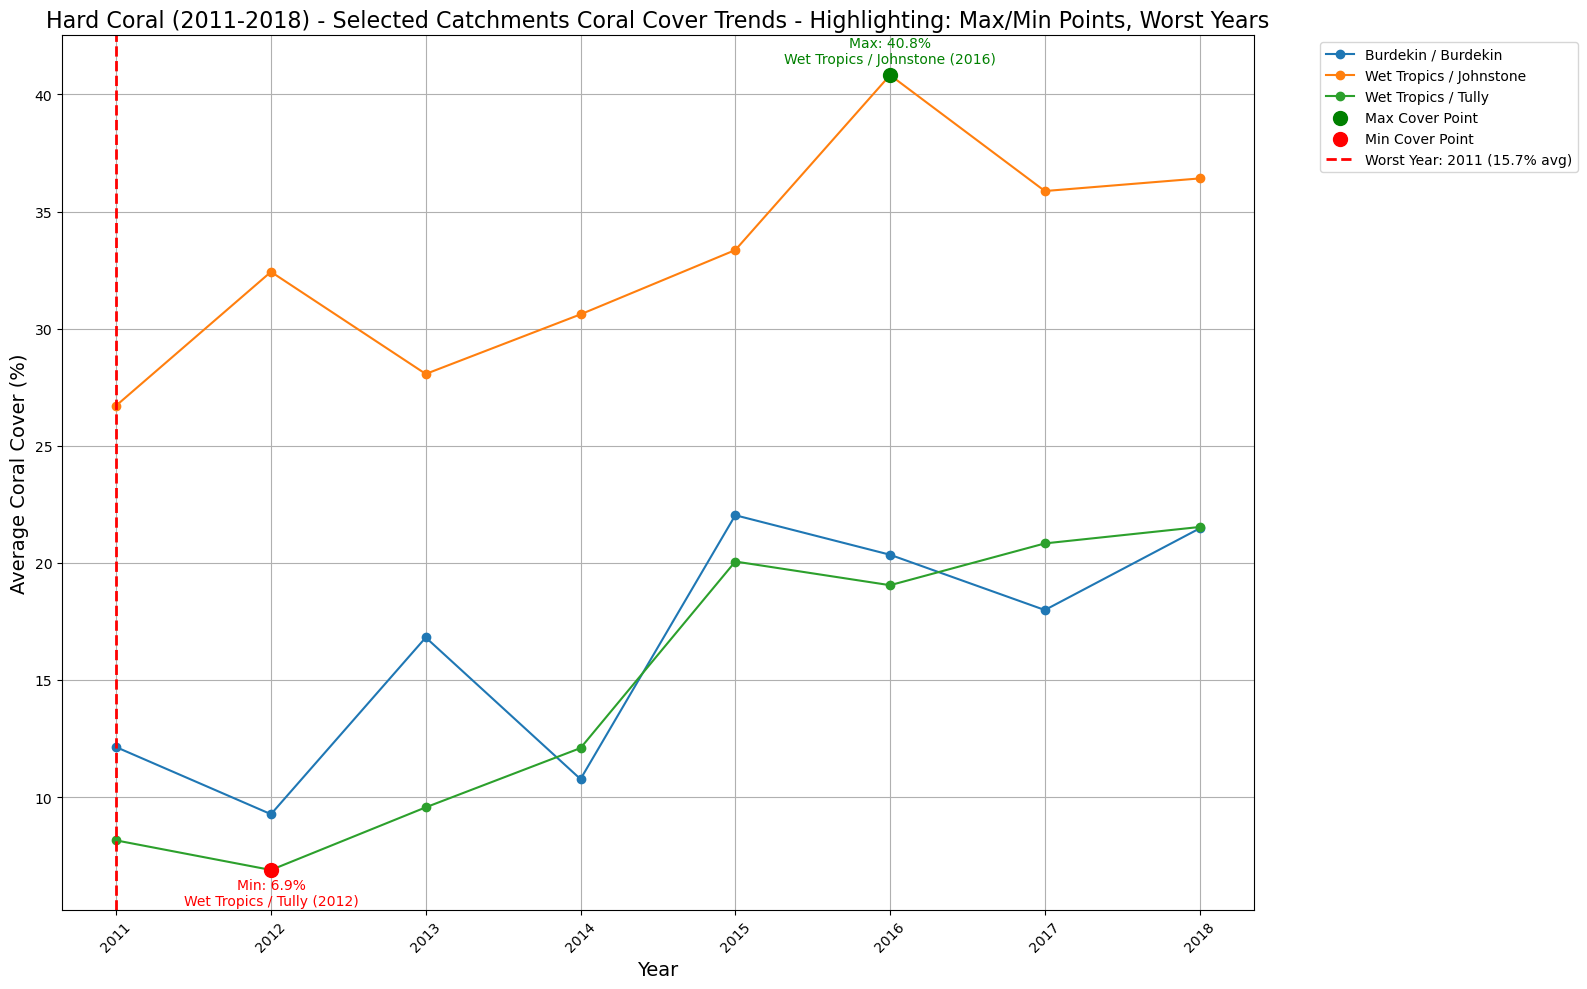

In [35]:
print("\n=== Analysis 4: Worse Only ===")
fig3, stats3 = plot_coral_cover_trends(
    'coraldata.csv',
    year_range=year_range,
    catchments=catchments,
    highlight_maxmin=True,
    highlight_worst_year=True,
    highlight_best_year=False,
    output_filename='coral_cover_worseline.png'
    )

## Variable Concentration Map overlayed with Coral Points

In [36]:
def extract_spatial_data_for_mapping(ncdata, variable_name, time_index=0, depth_index=-1, 
                                   include_currents=False, current_dataset_template=None, 
                                   year=None, month=None): 
    """
    Extract full spatial grids from netCDF data for creating geographic maps
    with optional ocean current vector overlay.

    Parameters:
    -----------
    ncdata : netCDF4.Dataset.variables
        NetCDF dataset variables containing the primary variable data.
    variable_name : str
        Name of variable to extract (e.g., 'DIN', 'temperature').
    time_index : int, optional
        Time step index to extract from the dataset. Default is 0 (first time step).
    depth_index : int, optional
        Depth layer index using negative indexing (-1 for surface). Default is -1.
    include_currents : bool, optional
        Whether to extract current vector data (u, v components). Default is False.
    current_dataset_template : str, optional
        URL template for current data files with {datestr} placeholder. Required if
        include_currents=True.
    year : int, optional
        Year for current data file path. Required if include_currents=True.
    month : int, optional
        Month for current data file path. Required if include_currents=True.

    Returns:
    --------
    tuple
        If include_currents=False: (concentration, lat_grid, lon_grid)
        If include_currents=True: (concentration, lat_grid, lon_grid, current_data)
        
        - concentration: 2D numpy array of variable values
        - lat_grid: 2D numpy array of latitude coordinates  
        - lon_grid: 2D numpy array of longitude coordinates
        - current_data: dict with 'u', 'v', 'lat_grid', 'lon_grid' keys (if requested)

    Notes:
    ------
    - Creates 2D coordinate grids using meshgrid with 'ij' indexing
    - Handles both 3D (time, lat, lon) and 4D (time, depth, lat, lon) data structures
    - Automatically converts masked arrays to regular arrays with NaN fill values
    - Interpolates current data to concentration grid if spatial dimensions differ
    - Uses scipy.interpolate.griddata for grid interpolation when needed
    - Continues execution with warnings if current data extraction fails

    Example:
    --------
    >>> # Extract concentration data only
    >>> conc, lats, lons = extract_spatial_data_for_mapping(
    ...     nc_vars, 'DIN', time_index=5
    ... )
    
    >>> # Extract with ocean currents
    >>> conc, lats, lons, currents = extract_spatial_data_for_mapping(
    ...     nc_vars, 'DIN', time_index=5, include_currents=True,
    ...     current_dataset_template="http://data.gov.au/currents/{datestr}.nc",
    ...     year=2023, month=6
    ... )
    >>> u_velocity = currents['u']
    >>> v_velocity = currents['v']
    """
    
    # # Get 1D coordinate arrays
    lat_1d = ncdata['latitude'][:]
    lon_1d = ncdata['longitude'][:]

    # Create meshgrid (2D coordinates) to find intersections
    lat_grid, lon_grid = np.meshgrid(lat_1d, lon_1d, indexing='ij')
    
    # Get variable data
    var_data = ncdata[variable_name]
    
    # Extract data for specific time and depth
    if var_data.ndim == 4:  # (time, depth, lat, lon)
        concentration = var_data[time_index, depth_index, :, :]
    elif var_data.ndim == 3:  # (time, lat, lon)
        concentration = var_data[time_index, :, :]
    else:
        raise ValueError(f"Unexpected data dimensions: {var_data.ndim}")
    
    # Convert masked arrays to regular arrays with NaN
    if hasattr(concentration, 'filled'):
        concentration = concentration.filled(np.nan)
    
    # Extract current data from separate file if requested
    current_data = None
    if include_currents and current_dataset_template is not None:
        try:
            # Build current data file path
            current_datestr = f"{year}-{month:02d}"
            current_file = current_dataset_template.format(datestr=current_datestr)
            
            # Open separate current data file
            with Dataset(current_file, 'r') as curr_nc:
                curr_ncdata = curr_nc.variables
                
                if 'u' in curr_ncdata.keys() and 'v' in curr_ncdata.keys():
                    # Get current coordinates (might be different grid)
                    curr_lat_1d = curr_ncdata['latitude'][:]
                    curr_lon_1d = curr_ncdata['longitude'][:]
                    curr_lat_grid, curr_lon_grid = np.meshgrid(curr_lat_1d, curr_lon_1d, indexing='ij')
                    
                    # Find corresponding time index in current file
                    curr_time_var = curr_ncdata['time']
                    curr_monthly_dates = netCDF4.num2date(curr_time_var[:], curr_time_var.units)
                    curr_monthly_dates = [pd.to_datetime(str(date)) for date in curr_monthly_dates]
                    
                    # Use the same time index (assumes same temporal structure)
                    curr_time_idx = time_index
                    if curr_time_idx >= len(curr_monthly_dates):
                        print(f"Warning: Time index {curr_time_idx} exceeds current data length")
                        curr_time_idx = min(time_index, len(curr_monthly_dates) - 1)
                    
                    print(f"  Loading current data for {current_datestr}-{time_index+1}...")

                    # Extract u and v components
                    u_var = curr_ncdata['u']
                    v_var = curr_ncdata['v']
                    
                    # Extract for same time and depth
                    if u_var.ndim == 4:  # (time, depth, lat, lon)
                        u = u_var[curr_time_idx, depth_index, :, :]
                        v = v_var[curr_time_idx, depth_index, :, :]
                    elif u_var.ndim == 3:  # (time, lat, lon)
                        u = u_var[curr_time_idx, :, :]
                        v = v_var[curr_time_idx, :, :]
                    else:
                        raise ValueError(f"Unexpected current data dimensions: {u_var.ndim}")
                    
                    # Convert masked arrays for current components
                    if hasattr(u, 'filled'):
                        u = u.filled(np.nan)
                    if hasattr(v, 'filled'):
                        v = v.filled(np.nan)
                    
                    # If current grid different from concentration grid, interpolate
                    if (curr_lat_grid.shape != lat_grid.shape or 
                        not np.allclose(curr_lat_grid, lat_grid, equal_nan=True)):
                        print("  Interpolating current data to concentration grid...")
                        from scipy.interpolate import griddata
                        
                        # Flatten for interpolation
                        curr_points = np.column_stack((curr_lat_grid.ravel(), curr_lon_grid.ravel()))
                        target_points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))
                        
                        # Interpolate u and v
                        u_interp = griddata(curr_points, u.ravel(), target_points, 
                                          method='linear', fill_value=np.nan)
                        v_interp = griddata(curr_points, v.ravel(), target_points, 
                                          method='linear', fill_value=np.nan)
                        
                        # Reshape back to 2D grid
                        u = u_interp.reshape(lat_grid.shape)
                        v = v_interp.reshape(lat_grid.shape)
                        
                        # Use concentration grid for current data
                        curr_lat_grid = lat_grid
                        curr_lon_grid = lon_grid
                    
                    current_data = {
                        'u': u,
                        'v': v,
                        'lat_grid': curr_lat_grid,
                        'lon_grid': curr_lon_grid
                    }
                    
                else:
                    print("Warning: Current components 'u' and 'v' not found in current dataset")
                
        except Exception as e:
            print(f"Warning: Could not extract current data: {e}")
            import traceback
            traceback.print_exc()
    
    if include_currents:
        return concentration, lat_grid, lon_grid, current_data
    else:
        return concentration, lat_grid, lon_grid

In [37]:
def create_map_plot_with_currents(concentration, lat_grid, lon_grid, variable_name, date_str,
                                  thresholds, var_dict, region_bounds, output_dir, base_color,
                                  figsize, dpi, map_extent, reference_cities=None, coral_data=None,
                                  current_data=None, show_currents=False, current_options=None):
    """
    Internal function to create map plot with coral health data, reference cities, and optional current vectors
    
    Creates a concentration map with configurable color schemes, coral health indicators,
    reference city markers, and optional current vector overlays. 
    Supports multiple concentration thresholds and customizable visualisation options.
    
    Parameters:
    -----------
    concentration : numpy.ndarray (2D)
        Concentration data values on the lat/lon grid
    lat_grid : numpy.ndarray (2D) 
        Latitude grid corresponding to concentration data
    lon_grid : numpy.ndarray (2D)
        Longitude grid corresponding to concentration data  
    variable_name : str
        Short name/code for the variable being plotted (used in filename)
    date_str : str
        Date string in format 'YYYY-MM-DD' for the data timestamp
    thresholds : dict
        Dictionary with concentration threshold values:
        - 'low' : float (low threshold boundary)
        - 'high' : float (high threshold boundary)  
        - 'very_high' : float (very high threshold boundary)
    var_dict : dict
        Variable metadata dictionary containing:
        - 'long_name' : str (descriptive name for plot title)
    region_bounds : dict
        Dictionary of region boundaries with structure:
        {region_name: {'lat_range': (min, max), 'lon_range': (min, max)}}
    output_dir : str
        Directory path where the generated map image will be saved
    base_color : str
        Base color scheme for concentration map ('purple', 'blue', 'red')
    figsize : tuple
        Figure size as (width, height) in inches
    dpi : int
        Resolution for saved figure in dots per inch
    map_extent : list
        Map boundaries as [lon_min, lon_max, lat_min, lat_max]
    reference_cities : dict, optional
        Dictionary mapping city/catchment names to (latitude, longitude) tuples.
        Format: {'City Name': (lat, lon), ...}
    coral_data : pandas.DataFrame, optional
        Coral cover data with columns:
        - 'LATITUDE' : float (coral site latitude)
        - 'LONGITUDE' : float (coral site longitude)
        - 'COVER' : float (coral cover percentage)
        - 'YEAR_CODE' : int (survey year, optional)
        - 'GROUP_CODE' : str (coral type category)
    current_data : dict, optional
        Ocean current data dictionary containing:
        - 'u' : numpy.ndarray (eastward current velocity component)
        - 'v' : numpy.ndarray (northward current velocity component) 
        - 'lat_grid' : numpy.ndarray (latitude grid for currents)
        - 'lon_grid' : numpy.ndarray (longitude grid for currents)
    show_currents : bool, default False
        Whether to overlay current vector arrows on the map
    current_options : dict, optional
        Current vector plotting options:
        - 'vecsample' : int (sample every Nth vector to reduce density)
        - 'veclength' : float (reference vector length for legend)
        - 'scale' : float (quiver scale parameter) 
        - 'curlvl' : list [min, max] (concentration range for showing vectors)
        - 'color' : str (vector arrow color)
        - 'width' : float (vector arrow width)
        - 'alpha' : float (vector transparency 0-1)
        
    Returns:
    --------
    filename : str or None
        Path to the saved map image file, or None if plotting failed
        
    Notes:
    ------
    - Coral health categories: Good (>30% cover), Moderate (10-30% cover), Bad (<10% cover)
    - Reference cities are plotted as bright orange stars with black outlines
    - Concentration categories are mapped to 4 levels based on provided thresholds
    - Current vectors are only displayed where concentration is within curlvl range
    - Map includes coastlines, land/ocean features, gridlines, and region boundary boxes
    - Output filename format: '{variable_name}_{date_str}.png'
    
    Raises:
    -------
    Exception
        If map plotting or file saving fails (logged as warning, returns None)
    """
    
    if concentration is None:
        print("Warning: No concentration data provided")
        return None
    
    # Default current plotting options
    if current_options is None:
        current_options = {
            'vecsample': 20,  # Sample every Nth vector (reduce density)
            'veclength': 0.5,  # Reference vector length for legend
            'scale': 20,      # Quiver scale parameter
            'curlvl': [0.01, 2.0],  # Only show vectors where concentration is in this range
            'color': 'white',  # Vector color
            'width': 0.003,    # Vector width
            'alpha': 0.8       # Vector transparency
        }
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create figure with cartopy projection  
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Set map extent using configurable parameter
    ax.set_extent(map_extent, ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
    
    # Create concentration categories
    concentration_categories = np.full_like(concentration, np.nan)
    
    # Apply thresholds
    low_mask = concentration < thresholds['low']
    concentration_categories[low_mask] = 1
    
    medium_mask = (concentration >= thresholds['low']) & (concentration < thresholds['high'])
    concentration_categories[medium_mask] = 2
    
    high_mask = (concentration >= thresholds['high']) & (concentration < thresholds['very_high'])
    concentration_categories[high_mask] = 3
    
    very_high_mask = concentration >= thresholds['very_high']
    concentration_categories[very_high_mask] = 4
    
    # Create colormap
    if base_color.lower() == 'purple':
        colors = ['#E6E6FA', '#9370DB', '#8A2BE2', '#4B0082']
    elif base_color.lower() == 'blue':
        colors = ['#E6F3FF', '#87CEEB', '#4169E1', '#000080']
    elif base_color.lower() == 'red':
        colors = ['#FFE6E6', '#FF6B6B', '#FF0000', '#8B0000']
    else:
        colors = ['#E6E6FA', '#9370DB', '#8A2BE2', '#4B0082']
    
    cmap = mcolors.ListedColormap(colors)
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Plot concentration data
    im = ax.contourf(lon_grid, lat_grid, concentration_categories,
                     levels=bounds, cmap=cmap, norm=norm,
                     transform=ccrs.PlateCarree(), alpha=0.8)
    
    # Add coral locations if available
    if coral_data is not None:
        try:
            # Extract year from date_str for coral data filtering
            year = int(date_str.split('-')[0])
            
            # Filter coral data for the specific year (if year column exists)
            if 'YEAR_CODE' in coral_data.columns:
                year_coral_data = coral_data[coral_data['YEAR_CODE'] == year].copy()
            else:
                # Use all coral data if no year column
                year_coral_data = coral_data.copy()
            
            if len(year_coral_data) > 0:
                # Define coral health categories and colors
                def get_coral_health(cover):
                    if cover > 30:
                        return 'Good'
                    elif cover >= 10:
                        return 'Moderate'
                    else:
                        return 'Bad'
                
                # Apply health categorization
                year_coral_data['health'] = year_coral_data['COVER'].apply(get_coral_health)
                
                # Define colors for each health category
                health_colors = {
                    'Good': '#2E8B57',      # Sea green
                    'Moderate': '#FFD700',  # Gold
                    'Bad': '#DC143C'        # Crimson
                }
                
                # Filter corals within map extent
                lon_min, lon_max, lat_min, lat_max = map_extent
                mask = ((year_coral_data['LONGITUDE'] >= lon_min) & 
                       (year_coral_data['LONGITUDE'] <= lon_max) &
                       (year_coral_data['LATITUDE'] >= lat_min) & 
                       (year_coral_data['LATITUDE'] <= lat_max))
                
                visible_corals = year_coral_data[mask]
                
                if len(visible_corals) > 0:
                    # Plot corals by health category
                    for health in ['Good', 'Moderate', 'Bad']:
                        health_corals = visible_corals[visible_corals['health'] == health]
                        if len(health_corals) > 0:
                            ax.scatter(health_corals['LONGITUDE'], 
                                     health_corals['LATITUDE'],
                                     c=health_colors[health], 
                                     s=30,  # Size of points
                                     alpha=0.8,
                                     edgecolors='black', 
                                     linewidths=0.5,
                                     label=f'Coral {health} (n={len(health_corals)})',
                                     transform=ccrs.PlateCarree(),
                                     zorder=5)  # Ensure corals appear on top
                    
                    # Add legend for coral health
                    coral_legend = ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1),
                                           frameon=True, fancybox=True, shadow=True, 
                                           fontsize=8, title=f'Coral Health ({year})')
                    coral_legend.get_title().set_fontsize(9)
                    
                    print(f"  Added {len(visible_corals)} coral sites for {year}")
                else:
                    print(f"  No coral sites found within map extent for {year}")
            else:
                print(f"  No coral data found for year {year}")
                
        except Exception as e:
            print(f"Warning: Could not plot coral locations: {e}")
            import traceback
            traceback.print_exc()

    # Add reference cities if available
    if reference_cities is not None:
        try:
            # Filter cities within map extent
            lon_min, lon_max, lat_min, lat_max = map_extent
            visible_cities = {}
            
            for city_name, (city_lat, city_lon) in reference_cities.items():
                if (lon_min <= city_lon <= lon_max and lat_min <= city_lat <= lat_max):
                    visible_cities[city_name] = (city_lat, city_lon)
            
            if visible_cities:
                # Plot cities as bright purple star for high visibility
                city_lats = [lat for lat, lon in visible_cities.values()]
                city_lons = [lon for lat, lon in visible_cities.values()]
                
                ax.scatter(city_lons, city_lats,
                          marker='*',        # Star shape
                          s=180,             # Large size for visibility
                          c='#ba07ba',       # Bright purple color
                          edgecolors='black', # Black outline
                          linewidths=1,      
                          alpha=0.9,         # Nearly opaque
                          label=f'Reference Cities (n={len(visible_cities)})',
                          transform=ccrs.PlateCarree(),
                          zorder=10)         # Highest priority to appear on top
                
                print(f"  Added {len(visible_cities)} reference cities")
                
                # Add cities to legend (create separate legend if corals exist, otherwise use main legend)
                if coral_data is not None and len(coral_data) > 0:
                    # Create a separate legend for cities below the coral legend
                    city_legend_elements = [plt.Line2D([0], [0], marker='*', color='w', 
                                                     markerfacecolor='#ba07ba', markersize=12,
                                                     markeredgecolor='black', markeredgewidth=1,
                                                     label='Reference Cities')]
                    city_legend = ax.legend(handles=city_legend_elements, 
                                          loc='upper left', bbox_to_anchor=(1.05, 0.8),
                                          frameon=True, fancybox=True, shadow=True, 
                                          fontsize=8, title='Reference Points')
                    city_legend.get_title().set_fontsize(9)
                    
                    # Keep both legends visible
                    ax.add_artist(coral_legend)
                    
            else:
                print(f"  No reference cities found within map extent")
                
        except Exception as e:
            print(f"Warning: Could not plot reference cities: {e}")
            import traceback
            traceback.print_exc()
    
    # Add current vectors if requested and available
    if show_currents and current_data is not None:
        try:
            u = current_data['u']
            v = current_data['v']
            curr_lat_grid = current_data['lat_grid']
            curr_lon_grid = current_data['lon_grid']
            
            # Find points within concentration range for vector display
            ind = np.where(np.logical_and(concentration.flatten() > current_options['curlvl'][0],
                                        concentration.flatten() < current_options['curlvl'][1]))[0]
            
            # Randomly sample vectors to avoid overcrowding
            np.random.shuffle(ind)
            Nvec = int(len(ind) / current_options['vecsample'])
            if Nvec > 0:
                idv = ind[:Nvec]
                
                # Create quiver plot
                Q = ax.quiver(curr_lon_grid.flatten()[idv],
                            curr_lat_grid.flatten()[idv],
                            u.flatten()[idv],
                            v.flatten()[idv],
                            transform=ccrs.PlateCarree(),
                            scale=current_options['scale'],
                            color=current_options['color'],
                            width=current_options['width'],
                            alpha=current_options['alpha'])
                
                # Add vector scale legend
                maxstr = f"{current_options['veclength']:.1f} m/s"
                qk = plt.quiverkey(Q, 0.1, 0.1, current_options['veclength'], maxstr, 
                                 labelpos='S', color=current_options['color'])
                
        except Exception as e:
            print(f"Warning: Could not plot current vectors: {e}")
    
    # Add region boundaries if provided
    if region_bounds:
        for region_name, bounds_dict in region_bounds.items():
            lat_min_reg, lat_max_reg = bounds_dict['lat_range']
            lon_min_reg, lon_max_reg = bounds_dict['lon_range']
            
            rect = Rectangle((lon_min_reg, lat_min_reg),
                           lon_max_reg - lon_min_reg,
                           lat_max_reg - lat_min_reg,
                           linewidth=2, edgecolor='black',
                           facecolor='none', linestyle='--',
                           transform=ccrs.PlateCarree())
            ax.add_patch(rect)
            
            ax.text(lon_min_reg + 0.1, lat_max_reg - 0.1, region_name,
                   transform=ccrs.PlateCarree(), fontsize=8,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.7)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal',
                       pad=0.05, shrink=0.8, aspect=30)
    cbar.set_ticks([1, 2, 3, 4])
    cbar.set_ticklabels([
        f'Low (< {thresholds["low"]:.2f})',
        f'Medium ({thresholds["low"]:.2f}-{thresholds["high"]:.2f})',
        f'High ({thresholds["high"]:.2f}-{thresholds["very_high"]:.2f})',
        f'Very High (> {thresholds["very_high"]:.2f})'
    ])
    cbar.set_label(f'{variable_name} Concentration Categories', fontsize=10)
    
    # Add title
    title = f'{var_dict["long_name"]} Concentration Map'
    if show_currents:
        title += ' with Current Vectors'
    title += f' - {date_str}'
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Save the map with tight layout to accommodate external legend
    filename = os.path.join(output_dir, f'{variable_name}_{date_str}.png')
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    plt.close()
    
    return filename

In [38]:
def create_maps_from_loaded_data(all_regional_data, all_dates, var_dict, variable_name,
                                dataset_template, years, months, time_indices,
                                thresholds, output_dir='maps', base_color='purple',
                                region_bounds=None, figsize=(12, 8), dpi=100, 
                                map_extent=map_extent, reference_cities=None, coral_data=None,
                                show_currents=False, current_options=None, current_dataset_template=None):
    """
    Create concentration maps with coral locations, reference cities, and optional current vectors
    
    Parameters:
    -----------
    all_regional_data : dict (from your load_multiyear_data function)
    all_dates : list (from your load_multiyear_data function)  
    var_dict : dict (from your load_multiyear_data function)
    variable_name : str
    dataset_template : str (your existing template)
    years : list (years in dataset)
    months : list (months in dataset)
    time_indices : list (which time steps to map)
    thresholds : dict with 'low', 'high', 'very_high' values
    output_dir : str
    base_color : str
    region_bounds : dict (optional)
    figsize : tuple
    dpi : int
    map_extent : list [lon_min, lon_max, lat_min, lat_max] (optional)
    reference_cities : dict, optional
        Dictionary mapping city/catchment names to (latitude, longitude) tuples.
    coral_data : pandas DataFrame (coral location and cover data)
    show_currents : bool (whether to overlay current vectors)
    current_options : dict (quiver plotting options)
    current_dataset_template : str (URL template for current data files)

    Returns:
    --------
    map_files : list of created map filenames
    """
    
    # Default extent if none provided
    if map_extent is None:
        map_extent = [142, 155, -28, -10] # [lon_min, lon_max, lat_min, lat_max] for Whole Great Barrier Reef

    os.makedirs(output_dir, exist_ok=True)
    map_files = []
    
    print(f"Creating {len(time_indices)} concentration maps...")
    if show_currents:
        print("Including current vectors in maps...")
    if reference_cities:
        print(f"Including {len(reference_cities)} reference cities...")
    
    for i, time_idx in enumerate(time_indices):
        if time_idx >= len(all_dates):
            print(f"Warning: time index {time_idx} exceeds available data length {len(all_dates)}")
            continue
            
        target_date = all_dates[time_idx]
        date_str = pd.to_datetime(str(target_date)).strftime('%Y-%m-%d')
        
        print(f"Processing {date_str} (index {time_idx})...")
        
        # Determine which monthly file contains this date
        year = pd.to_datetime(target_date).year
        month = pd.to_datetime(target_date).month
        netCDF_datestr = f"{year}-{month:02d}"
        inputFile = dataset_template.format(datestr=netCDF_datestr)
        
        try:
            with Dataset(inputFile, 'r') as nc_data:
                ncdata = nc_data.variables
                
                if variable_name not in ncdata.keys():
                    print(f"Warning: {variable_name} not found in {netCDF_datestr}")
                    continue
                
                # Find the correct time index within the monthly file
                time_var = ncdata['time']
                monthly_dates = netCDF4.num2date(time_var[:], time_var.units)
                monthly_dates = [pd.to_datetime(str(date)) for date in monthly_dates]
                
                # Find closest matching date
                monthly_time_idx = None
                for j, monthly_date in enumerate(monthly_dates):
                    if monthly_date.date() == pd.to_datetime(target_date).date():
                        monthly_time_idx = j
                        break
                
                if monthly_time_idx is None:
                    print(f"Warning: Could not find matching date in {netCDF_datestr}")
                    continue
                
                # Extract spatial data (including currents if requested)
                if show_currents:
                    concentration, lat_grid, lon_grid, current_data = extract_spatial_data_for_mapping(
                        ncdata, variable_name, monthly_time_idx, include_currents=True,
                        current_dataset_template=current_dataset_template,
                        year=year, month=month
                    )
                else:
                    concentration, lat_grid, lon_grid = extract_spatial_data_for_mapping(
                        ncdata, variable_name, monthly_time_idx, include_currents=False
                    )
                    current_data = None

                # Create map with optional currents and reference cities
                filename = create_map_plot_with_currents(
                    concentration, lat_grid, lon_grid, variable_name, date_str,
                    thresholds, var_dict, region_bounds, output_dir, base_color,
                    figsize, dpi, map_extent, reference_cities, coral_data, 
                    current_data, show_currents, current_options
                )
                
                if filename:
                    map_files.append(filename)
                    
        except Exception as e:
            print(f"Error processing {netCDF_datestr}: {e}")
            continue
    
    print(f"Created {len(map_files)} concentration maps")
    return map_files

### Coral Data extraction

In [39]:
def load_coral_data(coral_csv_path, group_category='all'):
    """
    Load and prepare coral cover data from CSV file
    
    Parameters:
    -----------
    coral_csv_path : str (path to coral CSV file)
    group_category : str (category to filter by: 'hard coral', 'soft coral', 'algae', 'others', or 'all')
                    Default is 'all'
    
    Expected CSV columns:
    - LATITUDE : float (coral site latitude)
    - LONGITUDE : float (coral site longitude) 
    - COVER : float (coral cover percentage)
    - GROUP_CODE : str (category: 'hard coral', 'soft coral', 'algae', 'others')
    - YEAR_CODE : int (survey year, optional)
    
    Returns:
    --------
    coral_data : pandas DataFrame
    """
    
    try:
        import pandas as pd
        coral_data = pd.read_csv(coral_csv_path)
        
        # Check for required columns
        required_cols = ['LATITUDE', 'LONGITUDE', 'COVER', 'GROUP_CODE']
        missing_cols = [col for col in required_cols if col not in coral_data.columns]
        
        if missing_cols:
            raise ValueError(f"Missing required columns in coral CSV: {missing_cols}")
        
        # Show available group categories
        available_groups = sorted(coral_data['GROUP_CODE'].unique())
        print(f"Available GROUP_CODE categories: {available_groups}")
        
        # Filter by group category if not 'all'
        if group_category.lower() != 'all':
            original_count = len(coral_data)
            coral_data = coral_data[coral_data['GROUP_CODE'].str.lower() == group_category.lower()]
            
            if len(coral_data) == 0:
                raise ValueError(f"No data found for group category '{group_category}'. "
                               f"Available categories: {available_groups}")
            
            print(f"Filtered to '{group_category}': {len(coral_data)} records (from {original_count} total)")
        else:
            print(f"Using all group categories: {len(coral_data)} records")
        
        # Remove rows with missing coordinates or cover data
        coral_data = coral_data.dropna(subset=['LATITUDE', 'LONGITUDE', 'COVER'])
        
        print(f"Final dataset after removing missing values: {len(coral_data)} records")
        if 'YEAR_CODE' in coral_data.columns:
            years = sorted(coral_data['YEAR_CODE'].unique())
            print(f"Available years: {years}")
        else:
            print("No YEAR column found - will use all data for each map")
            
        return coral_data
        
    except Exception as e:
        print(f"Error loading coral data: {e}")
        return None


In [40]:
def get_coral_health_summary(coral_data, year=None):
    """
    Get summary statistics of coral health for a given year
    
    Parameters:
    -----------
    coral_data : pandas DataFrame
    year : int (optional, if None uses all data)
    
    Returns:
    --------
    summary : dict with health category counts
    """
    
    if coral_data is None:
        return {}
    
    # Filter by year if specified
    if year is not None and 'YEAR_CODE' in coral_data.columns:
        data = coral_data[coral_data['YEAR_CODE'] == year]
    else:
        data = coral_data
    
    if len(data) == 0:
        return {}
    
    # Apply health categorization
    def get_coral_health(cover):
        if cover > 30:
            return 'Good'
        elif cover >= 10:
            return 'Moderate'
        else:
            return 'Bad'
    
    data = data.copy()
    data['health'] = data['COVER'].apply(get_coral_health)
    
    # Count by health category
    summary = data['health'].value_counts().to_dict()
    summary['total'] = len(data)
    summary['mean_cover'] = data['COVER'].mean()
    
    return summary

### GIF

In [41]:
def create_animated_gif(map_files, output_filename, duration=500, loop=0):
    """
    Generate an animated GIF from a sequence of map images for temporal visualization
    of environmental data changes over time.

    Parameters:
    -----------
    map_files : list of str
        List of file paths to map images (PNG format) to combine into animation.
    output_filename : str
        Path and filename for the output GIF file (should include .gif extension).
    duration : int, optional
        Time in milliseconds each frame is displayed. Default is 500ms (0.5 seconds).
    loop : int, optional
        Number of times to loop animation (0 = infinite loop). Default is 0.

    Returns:
    --------
    str or None
        Path to the created GIF file, or None if creation fails.

    Notes:
    ------
    - Automatically sorts input files alphabetically for consistent frame ordering
    - Skips missing files with warning messages but continues processing
    - Uses PIL/Pillow optimization to reduce file size
    - Requires at least one valid image file to create GIF
    - Common duration values: 200ms (fast), 500ms (medium), 1000ms (slow)

    Example:
    --------
    >>> map_files = ['DIN_2023-01-01.png', 'DIN_2023-01-02.png', 'DIN_2023-01-03.png']
    >>> gif_path = create_animated_gif(map_files, 'DIN_animation.gif', duration=300)
    Creating animated GIF with 3 frames...
    Animated GIF saved as: DIN_animation.gif
    >>> print(gif_path)
    'DIN_animation.gif'
    """
    
    if not map_files:
        print("No map files provided for GIF creation")
        return None
    
    print(f"Creating animated GIF with {len(map_files)} frames...")
    
    # Sort files alphabetically for consistent temporal ordering
    map_files_sorted = sorted(map_files)
    
    images = []
    for filename in map_files_sorted:
        if os.path.exists(filename):
            img = Image.open(filename) # Load image using PIL
            images.append(img) 
        else:
            print(f"Warning: File not found {filename}")
    
    if not images:
        print("No valid images found for GIF creation")
        return None

    # Create animated GIF using first image as base
    images[0].save(
        output_filename,
        save_all=True, # Save all frames
        append_images=images[1:], # Add remaining frames
        duration=duration, # Frame display duration
        loop=loop, # Loop count (0 = infinite)
        optimize=True # Optimize file size
    )
    
    print(f"Animated GIF saved as: {output_filename}")
    return output_filename

### Temp File

In [42]:
def cleanup_temp_maps(map_files, keep_maps=False):
    """
    Clean up temporary map files (reused from original)
    """
    if not keep_maps:
        print(f"Cleaning up {len(map_files)} temporary map files...")
        for filename in map_files:
            try:
                if os.path.exists(filename):
                    os.remove(filename)
            except Exception as e:
                print(f"Error removing {filename}: {e}")

In [43]:
def create_maps_from_existing_data(variable_name, dataset_template, years, months, thresholds,
                                base_color='red', coral_csv_path=None, show_currents=False,
                                current_options=None, current_dataset_template=None,
                                keep_individual_maps=False, regions=map_extent, reference_cities=None):
    """
    Generate concentration maps and animated GIF using existing data infrastructure
    with optional coral health indicators, reference cities, and ocean current overlays.

    Parameters:
    -----------
    variable_name : str
        Name of the variable to map (e.g., 'DIN', 'temperature').
    dataset_template : str
        URL template for netCDF data files with {datestr} placeholder.
    years : list or int
        Year(s) to process for mapping.
    months : list of int
        Month numbers to include in the analysis (1-12).
    thresholds : dict
        Concentration thresholds with keys: 'low', 'high', 'very_high'.
    base_color : str, optional
        Color scheme for maps ('red', 'blue', 'purple'). Default is 'red'.
    coral_csv_path : str, optional
        Path to CSV file containing coral survey data. Default is None.
    show_currents : bool, optional
        Whether to overlay current vectors on maps. Default is False.
    current_options : dict, optional
        Current vector plotting parameters (vecsample, scale, etc.). Default is None.
    current_dataset_template : str, optional
        URL template for current data files. Required if show_currents=True.
    keep_individual_maps : bool, optional
        Whether to retain individual map files after GIF creation. Default is False.
    regions : dict, optional
        Region boundary definitions for map overlay. Default uses map_extent.
    reference_cities : dict, optional
        Dictionary mapping city/catchment names to (latitude, longitude) tuples.

    Returns:
    --------
    None
        Creates map files, animated GIF, and prints progress information.
    """

    # Load coral data if provided
    coral_data = None
    if coral_csv_path:
        coral_data = load_coral_data(coral_csv_path, group_category='hard coral')
        if coral_data is not None:
            # Print coral health summary for the first year
            summary = get_coral_health_summary(coral_data, years[0])
            print(f"Coral health summary for {years[0]}: {summary}")

    # Set output directory based on current options
    output_dir = f'{variable_name}_concentration_maps'
    if show_currents:
        output_dir = f'{variable_name}_with_currents_maps'
    
    print(f"Starting {variable_name} mapping using existing data infrastructure...")
    if coral_csv_path:
        print(f"Coral locations will be loaded from: {coral_csv_path}")
    if reference_cities:
        print(f"Will include {len(reference_cities)} reference cities: {list(reference_cities.keys())}")
    if show_currents:
        print("Current vectors will be included in maps...")
    
    # Choose aggregation method: 'mean', 'max', 'min', 'median', 'std', 'sum'
    agg_method = 'mean'
    
    # Load data using existing function
    print("Loading data using existing cache system...")

    # This would use existing load_multiyear_data function
    all_regional_data, all_dates, var_dict = load_multiyear_data(
        years, months, variable_name, dataset_template, agg_method=agg_method,
        use_cache=True, cache_dir='data_cache'
    )
    
    # Select time indices for mapping (weekly sampling for balance)
    # Alternative options:
    # time_indices = list(range(0, 31))        # Daily maps for first month
    # time_indices = list(range(80, 96))       # Specific day range
    time_indices = list(range(0, len(all_dates), 7))  # Every 7th day (weekly)

    # Create maps using loaded existing data
    map_files = create_maps_from_loaded_data(
        all_regional_data=all_regional_data,
        all_dates=all_dates,
        var_dict=var_dict,
        variable_name=variable_name,
        dataset_template=dataset_template,
        years=years,
        months=months,
        time_indices=time_indices,
        thresholds=thresholds,
        output_dir=output_dir,
        base_color=base_color,
        region_bounds=regions,
        reference_cities=reference_cities, 
        coral_data=coral_data,
        show_currents=show_currents,     
        current_options=current_options,
        current_dataset_template=current_dataset_template
    )

    # Create animated GIF
    if map_files:
        gif_suffix = '_with_currents' if show_currents else ''
        gif_filename = f'{agg_method}_{variable_name}_concentration{gif_suffix}_animation_{years[0]}.gif'
        create_animated_gif(map_files, gif_filename, duration=500, loop=0)
        
        # cleanup to save disk space
        cleanup_temp_maps(map_files, keep_maps=keep_individual_maps)
        
        print(f"Animation completed! GIF saved as: {gif_filename}")

    return None


### Execution

In [44]:
# Example integration with existing workflow
if __name__ == "__main__":
    
    # Configuration
    # ===============================
    
    # Use existing dataset template
    dataset_template = (
        "https://thredds.ereefs.aims.gov.au/thredds/dodsC/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/"
        "daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"
        "{datestr}.nc"
    )
    
    # Time period and variable
    years = [2012]
    months = [1, 2, 3, 4, 5]  # Jan to May
    variable_name = 'DIN'
    
    # Concentration thresholds
    thresholds = {
        'low': 0.4,
        'high': 1.0, 
        'very_high': 2.0
    }

    # Coral Data
    coral_csv_path='coraldata.csv'

    # Ocean Current Data
    current_dataset_template = (
        "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/"
        "ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"
        "{datestr}.nc"
    )
    
    current_options = {
        'vecsample': 25,      # Sample every 25th vector (adjust for density)
        'veclength': 0.3,     # Reference vector length for legend (m/s)
        'scale': 15,          # Quiver scale (lower = longer vectors)
        'curlvl': [0.1, 3.0], # Only show vectors where concentration is in this range
        'color': 'black',     # Vector color (white shows well on colored background)
        'width': 0.004,       # Vector width
        'alpha': 0.9          # Vector transparency
    }

    # Output settings
    base_color = 'blue'  # can be purple, red or blue
    keep_individual_maps = True
    show_currents = True

    create_maps_from_existing_data(
        variable_name,
        dataset_template,
        years,
        months,
        thresholds,
        base_color,
        coral_csv_path,
        show_currents,
        current_options,
        current_dataset_template,
        keep_individual_maps,
        regions=sugarcane_regions,
        reference_cities=reference_cities 
    )

Available GROUP_CODE categories: ['Algae', 'Hard Coral', 'Other', 'Soft Coral']
Filtered to 'hard coral': 1980 records (from 7920 total)
Final dataset after removing missing values: 1980 records
Available years: [np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Coral health summary for 2012: {'Good': 37, 'Bad': 30, 'Moderate': 30, 'total': 97, 'mean_cover': np.float64(24.352577319587628)}
Starting DIN mapping using existing data infrastructure...
Coral locations will be loaded from: coraldata.csv
Will include 6 reference cities: ['Cairns', 'Townsville', 'Herbert', 'Burdekin', 'Tully', 'Johnstone']
Current vectors will be included in maps...
Loading data using existing cache system...
Loaded data from cache: data_cache/DIN_2012-2012_mon

# Multi Variable Model Building

## Import

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
import warnings
import pickle
import joblib
from datetime import datetime

## Multi-Var Building Function

In [25]:
def prepare_multivariable_coral_data(all_regional_data_dict, all_dates, coral_csv_file, 
                                   years_to_analyze=None, catchments=None, 
                                   coral_group='hard coral', aggregation_method='annual',
                                   variable_aggregation=None, use_log_din=False): 
    """
    Prepare matched multi-variable oceanographic data and coral cover data for modeling
    
    Parameters:
    -----------
    all_regional_data_dict : dict
        Dictionary with keys like 'DIN', 'temp', 'salt', each containing regional time series
    all_dates : list
        Datetime objects corresponding to oceanographic data
    coral_csv_file : str
        Path to coral cover CSV file
    years_to_analyze : list, optional
        Years to include in analysis. If None, uses overlapping years.
    catchments : list, optional
        Catchments to include. If None, uses all available.
    coral_group : str
        Coral group to analyze ('hard coral', 'soft coral', etc.)
    aggregation_method : str
        How to aggregate data ('annual', 'seasonal', 'monthly')
    variable_aggregation : dict, optional
        Dictionary specifying aggregation method for each variable.
        Format: {'DIN': 'max', 'temp': 'max', 'salt': 'mean'}
        Options: 'max', 'mean', 'min', 'std', 'median'
        If None, defaults to 'mean' for all variables.
        If a variable is not specified, defaults to 'mean'.
    use_log_din : bool, optional
        If True, adds log-transformed DIN as an additional variable (ln_din)
        
    Returns:
    --------
    matched_data : pd.DataFrame
        DataFrame with columns: year, region, catchment, din_conc, temp, salt, coral_cover
        (and ln_din if use_log_din=True)
    data_summary : dict
        Summary of data preparation process
    """
    
    # Set default aggregation methods
    if variable_aggregation is None:
        variable_aggregation = {}
    
    # Default to 'mean' for any unspecified variables
    expected_vars = ['DIN', 'temp', 'salt']
    for var in expected_vars:
        if var not in variable_aggregation:
            variable_aggregation[var] = 'mean'
    
    # Validate aggregation methods
    valid_methods = ['max', 'mean', 'min', 'std', 'median']
    for var, method in variable_aggregation.items():
        if method not in valid_methods:
            raise ValueError(f"Invalid aggregation method '{method}' for variable '{var}'. Must be one of: {valid_methods}")
    
    # Load coral data
    try:
        coral_df = pd.read_csv(coral_csv_file)
        coral_df.columns = coral_df.columns.str.strip()
        
        # Clean coral data
        coral_df['YEAR_CODE'] = pd.to_numeric(coral_df['YEAR_CODE'], errors='coerce')
        coral_df = coral_df.dropna(subset=['YEAR_CODE'])
        coral_df['YEAR_CODE'] = coral_df['YEAR_CODE'].astype(int)
        
        # Filter by coral group
        if coral_group.lower() != 'all':
            coral_df = coral_df[coral_df['GROUP_CODE'].str.lower() == coral_group.lower()]
        
        # Aggregate coral data by year, region, catchment
        coral_agg = coral_df.groupby(['YEAR_CODE', 'NRM_REGION', 'CATCHMENT'])['COVER'].mean().reset_index()
        
    except Exception as e:
        raise ValueError(f"Error loading coral data: {e}")
    
    # Convert dates to DataFrame for easier manipulation
    dates_df = pd.DataFrame({
        'datetime': all_dates,
        'year': [d.year for d in all_dates],
        'month': [d.month for d in all_dates]
    })
    
    # Aggregate all variables by region
    variables_aggregated = {}
    
    available_vars = list(all_regional_data_dict.keys())
    
    print(f"Available variables: {available_vars}")
    print(f"Expected variables: {expected_vars}")
    if use_log_din and 'DIN' in available_vars:
        print(f"Log transformation: DIN will be log-transformed (ln_din)")
    print(f"Variable-specific aggregation methods:")
    for var in expected_vars:
        if var in all_regional_data_dict:
            method = variable_aggregation.get(var, 'mean')
            print(f"  - {var}: {method.upper()}")
    
    # Check which variables are available
    missing_vars = [var for var in expected_vars if var not in available_vars]
    if missing_vars:
        print(f"Warning: Missing variables: {missing_vars}")
    
    for var_name, regional_data in all_regional_data_dict.items():
        if var_name not in expected_vars:
            print(f"Skipping unexpected variable: {var_name}")
            continue
            
        variables_aggregated[var_name] = {}
        
        # Get aggregation method for this variable
        agg_method = variable_aggregation.get(var_name, 'mean')
        
        for region_name, timeseries in regional_data.items():
            if len(timeseries) == 0:
                continue
                
            # Create temporary DataFrame for this region and variable
            temp_df = pd.DataFrame({
                'datetime': all_dates[:len(timeseries)],
                'year': [d.year for d in all_dates[:len(timeseries)]],
                'month': [d.month for d in all_dates[:len(timeseries)]],
                f'{var_name.lower()}': timeseries
            })
            
            # Remove NaN values
            temp_df = temp_df.dropna(subset=[f'{var_name.lower()}'])
            
            # Apply variable-specific aggregation method
            if aggregation_method == 'annual':
                if agg_method == 'max':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].max().reset_index()
                elif agg_method == 'min':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].min().reset_index()
                elif agg_method == 'std':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].std().reset_index()
                elif agg_method == 'median':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].median().reset_index()
                else:  # default to mean
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].mean().reset_index()
                    
            elif aggregation_method == 'seasonal':
                # Seasonal aggregation (wet season Nov-Apr, dry season May-Oct)
                temp_df['season'] = temp_df['month'].apply(
                    lambda x: 'wet' if x in [11, 12, 1, 2, 3, 4] else 'dry'
                )
                if agg_method == 'max':
                    region_agg = temp_df.groupby(['year', 'season'])[f'{var_name.lower()}'].max().reset_index()
                elif agg_method == 'min':
                    region_agg = temp_df.groupby(['year', 'season'])[f'{var_name.lower()}'].min().reset_index()
                elif agg_method == 'std':
                    region_agg = temp_df.groupby(['year', 'season'])[f'{var_name.lower()}'].std().reset_index()
                elif agg_method == 'median':
                    region_agg = temp_df.groupby(['year', 'season'])[f'{var_name.lower()}'].median().reset_index()
                else:  # default to mean
                    region_agg = temp_df.groupby(['year', 'season'])[f'{var_name.lower()}'].mean().reset_index()
                    
            else:  # monthly
                if agg_method == 'max':
                    region_agg = temp_df.groupby(['year', 'month'])[f'{var_name.lower()}'].max().reset_index()
                elif agg_method == 'min':
                    region_agg = temp_df.groupby(['year', 'month'])[f'{var_name.lower()}'].min().reset_index()
                elif agg_method == 'std':
                    region_agg = temp_df.groupby(['year', 'month'])[f'{var_name.lower()}'].std().reset_index()
                elif agg_method == 'median':
                    region_agg = temp_df.groupby(['year', 'month'])[f'{var_name.lower()}'].median().reset_index()
                else:  # default to mean
                    region_agg = temp_df.groupby(['year', 'month'])[f'{var_name.lower()}'].mean().reset_index()
            
            variables_aggregated[var_name][region_name] = region_agg
    
    # Region-catchment mapping (same as before)
    region_catchment_mapping = {
        'Wet Tropics Central': ['Johnstone'],
        'Wet Tropics South': ['Tully'],
        'Burdekin': ['Burdekin']
    }
    
    # Create matched dataset
    matched_records = []
    
    # Get all available regions (use DIN as reference if available, otherwise use first available variable)
    reference_var = 'DIN' if 'DIN' in variables_aggregated else list(variables_aggregated.keys())[0]
    
    for region_name in variables_aggregated[reference_var].keys():
        # Find corresponding catchments for this region
        possible_catchments = region_catchment_mapping.get(region_name, [region_name])
        
        # Get data for this region from all variables
        region_data = {}
        for var_name in variables_aggregated.keys():
            if region_name in variables_aggregated[var_name]:
                region_data[var_name] = variables_aggregated[var_name][region_name]
        
        # If we don't have data for all variables in this region, skip
        if len(region_data) != len([v for v in expected_vars if v in all_regional_data_dict]):
            print(f"Warning: Incomplete data for region {region_name}, skipping")
            continue
        
        # Find common years across all variables for this region
        year_sets = []
        for var_name, var_data in region_data.items():
            year_sets.append(set(var_data['year'].values))
        
        common_years = set.intersection(*year_sets) if year_sets else set()
        
        for year in common_years:
            # Get values for all variables for this year
            year_values = {'year': year, 'region': region_name}
            
            for var_name, var_data in region_data.items():
                year_row = var_data[var_data['year'] == year]
                if len(year_row) > 0:
                    year_values[var_name.lower()] = year_row.iloc[0][var_name.lower()]
            
            # Only proceed if we have all variables
            expected_lower = [v.lower() for v in expected_vars if v in all_regional_data_dict]
            if all(var in year_values for var in expected_lower):
                # Find matching coral data
                for catchment in possible_catchments:
                    coral_matches = coral_agg[
                        (coral_agg['YEAR_CODE'] == year) & 
                        (coral_agg['CATCHMENT'].str.contains(catchment, case=False, na=False))
                    ]
                    
                    for _, coral_row in coral_matches.iterrows():
                        record = {
                            'year': year,
                            'din_region': region_name,
                            'coral_region': coral_row['NRM_REGION'],
                            'catchment': coral_row['CATCHMENT'],
                            'coral_cover': coral_row['COVER']
                        }
                        
                        # Add all available variables
                        for var in expected_lower:
                            if var in year_values:
                                record[var] = year_values[var]
                        
                        matched_records.append(record)
    
    # Convert to DataFrame
    matched_data = pd.DataFrame(matched_records)
    
    if len(matched_data) == 0:
        raise ValueError("No matched records found. Check variable names and data alignment.")
    
    # Apply log transformation to DIN if requested
    if use_log_din and 'din' in matched_data.columns:
        # Add small constant to avoid log(0) issues, then apply natural log
        matched_data['ln_din'] = np.log(matched_data['din'] + 0.001)
        print(f"Log transformation applied: ln_din created (range: {matched_data['ln_din'].min():.3f} to {matched_data['ln_din'].max():.3f})")
    
    # Apply filters
    if years_to_analyze is not None:
        matched_data = matched_data[matched_data['year'].isin(years_to_analyze)]
    
    if catchments is not None:
        catchments_lower = [c.lower() for c in catchments]
        matched_data = matched_data[
            matched_data['catchment'].str.lower().isin(catchments_lower)
        ]
    
    # Remove any remaining NaN values
    numeric_cols = [col for col in matched_data.columns if col not in ['year', 'din_region', 'coral_region', 'catchment']]
    matched_data = matched_data.dropna(subset=numeric_cols)
    
    # Create variable ranges for summary
    var_ranges = {}
    correlations = {}
    
    # Include ln_din in analysis if it exists
    analysis_vars = expected_lower.copy()
    if 'ln_din' in matched_data.columns:
        analysis_vars.append('ln_din')
    
    for var in analysis_vars:
        if var in matched_data.columns:
            var_ranges[var] = (matched_data[var].min(), matched_data[var].max())
            if len(matched_data) > 1:
                correlations[var] = matched_data[[var, 'coral_cover']].corr().iloc[0, 1]
    
    # Create aggregation method summary
    agg_method_summary = {}
    for var in expected_vars:
        if var in all_regional_data_dict:
            agg_method_summary[var.lower()] = variable_aggregation.get(var, 'mean')
    
    # Summary statistics
    data_summary = {
        'total_records': len(matched_data),
        'years_covered': sorted(matched_data['year'].unique()) if len(matched_data) > 0 else [],
        'regions_included': list(matched_data['din_region'].unique()) if len(matched_data) > 0 else [],
        'catchments_included': list(matched_data['catchment'].unique()) if len(matched_data) > 0 else [],
        'variable_ranges': var_ranges,
        'coral_range': (matched_data['coral_cover'].min(), matched_data['coral_cover'].max()) if len(matched_data) > 0 else (None, None),
        'correlations_with_coral': correlations,
        'available_variables': [col for col in matched_data.columns if col in analysis_vars],
        'aggregation_methods': agg_method_summary,
        'temporal_aggregation': aggregation_method,
        'log_transformed_din': use_log_din and 'ln_din' in matched_data.columns
    }
    
    return matched_data, data_summary

In [26]:
def fit_multivariable_coral_models_cv(matched_data, cv_method='auto', random_state=42):
    """
    Fit multiple models to relate multiple oceanographic variables to coral cover
    Uses cross-validation for robust performance estimates on small datasets
    
    Parameters:
    -----------
    matched_data : pd.DataFrame
        Output from prepare_multivariable_coral_data
    cv_method : str or int
        Cross-validation method:
        - 'auto': Automatically choose based on sample size
        - 'loo': Leave-One-Out Cross-Validation
        - int (e.g., 5): K-Fold Cross-Validation with k folds
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    models : dict
        Dictionary of fitted models (trained on full dataset)
    results : dict
        Model performance metrics from cross-validation
    feature_importance : dict
        Variable importance for applicable models
    cv_predictions : dict
        Out-of-sample predictions from cross-validation
    """
    
    n_samples = len(matched_data)
    
    if n_samples < 10:
        raise ValueError(f"Insufficient data for modeling: only {n_samples} records available")
    
    # Identify available predictor variables
    potential_vars = ['din', 'ln_din', 'temp', 'salt']
    available_vars = [var for var in potential_vars if var in matched_data.columns]
    
    # If both din and ln_din are available, prioritize ln_din
    if 'ln_din' in available_vars and 'din' in available_vars:
        available_vars.remove('din')
        print(f"Using log-transformed DIN (ln_din) instead of regular DIN")
    
    if len(available_vars) == 0:
        raise ValueError("No predictor variables found in data")
    
    print(f"Using predictor variables: {available_vars}")
    print(f"Sample size: {n_samples}")
    
    # Determine cross-validation strategy
    if cv_method == 'auto':
        if n_samples < 20:
            cv = LeaveOneOut()
            cv_name = "Leave-One-Out CV"
        elif n_samples < 30:
            cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
            cv_name = "5-Fold CV"
        else:
            cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
            cv_name = "10-Fold CV"
    elif cv_method == 'loo':
        cv = LeaveOneOut()
        cv_name = "Leave-One-Out CV"
    elif isinstance(cv_method, int):
        cv = KFold(n_splits=cv_method, shuffle=True, random_state=random_state)
        cv_name = f"{cv_method}-Fold CV"
    else:
        raise ValueError("cv_method must be 'auto', 'loo', or an integer")
    
    print(f"Using {cv_name} for model evaluation")
    print(f"Number of CV iterations: {cv.get_n_splits(matched_data)}\n")
    
    # Prepare features and target
    X = matched_data[available_vars].values
    y = matched_data['coral_cover'].values
    
    # Create extended features for polynomial model
    feature_names = available_vars.copy()
    X_extended = X.copy()
    
    # Add log transformations
    for i, var in enumerate(available_vars):
        if var == 'ln_din':
            continue
        elif var == 'din':
            log_vals = np.log(X[:, i] + 0.001)
        else:
            log_vals = np.log(np.maximum(X[:, i], 0.001))
        X_extended = np.column_stack([X_extended, log_vals])
        feature_names.append(f'log_{var}')
    
    # Add squared terms
    for i, var in enumerate(available_vars):
        X_extended = np.column_stack([X_extended, X[:, i] ** 2])
        feature_names.append(f'{var}_squared')
    
    # Add interaction terms
    if len(available_vars) > 1:
        for i in range(len(available_vars)):
            for j in range(i + 1, len(available_vars)):
                interaction = X[:, i] * X[:, j]
                X_extended = np.column_stack([X_extended, interaction])
                feature_names.append(f'{available_vars[i]}_{available_vars[j]}_interaction')
    
    # Initialize storage
    models = {}
    results = {}
    feature_importance = {}
    cv_predictions = {}
    
    models['feature_names'] = feature_names
    models['available_vars'] = available_vars
    
    print("Fitting and evaluating models with cross-validation...")
    print("=" * 60)
    
    # 1. Multiple Linear Regression
    print("\n1. Multiple Linear Regression")
    linear_model = LinearRegression()
    
    # Cross-validation scores
    cv_scores = cross_val_score(linear_model, X, y, cv=cv, scoring='r2')
    cv_rmse = np.sqrt(-cross_val_score(linear_model, X, y, cv=cv, scoring='neg_mean_squared_error'))
    cv_mae = -cross_val_score(linear_model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    
    # Get out-of-sample predictions
    y_pred_cv = cross_val_predict(linear_model, X, y, cv=cv)
    
    # Fit on full dataset for coefficients and final model
    linear_model.fit(X, y)
    y_pred_train = linear_model.predict(X)
    
    models['linear'] = linear_model
    feature_importance['linear'] = dict(zip(available_vars, linear_model.coef_))
    cv_predictions['linear'] = y_pred_cv
    
    results['linear'] = {
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'cv_r2_all': cv_scores,
        'cv_rmse_mean': cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std(),
        'cv_mae_mean': cv_mae.mean(),
        'cv_mae_std': cv_mae.std(),
        'train_r2': r2_score(y, y_pred_train),
        'train_rmse': np.sqrt(mean_squared_error(y, y_pred_train)),
        'predictions_cv': y_pred_cv,
        'predictions_train': y_pred_train
    }
    
    print(f"   CV R² = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"   CV RMSE = {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}%")
    print(f"   Training R² = {results['linear']['train_r2']:.3f} (on full dataset)")
    
    # 2. Polynomial/Extended Features Regression
    print("\n2. Polynomial Regression (with scaling)")
    
    # For polynomial, we need to scale within each CV fold
    # Create a custom cross-validation loop for this
    poly_cv_scores = []
    poly_cv_predictions = np.zeros(len(y))
    
    for train_idx, test_idx in cv.split(X_extended):
        X_train_fold, X_test_fold = X_extended[train_idx], X_extended[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        
        # Scale within fold
        scaler_fold = StandardScaler()
        X_train_scaled = scaler_fold.fit_transform(X_train_fold)
        X_test_scaled = scaler_fold.transform(X_test_fold)
        
        # Fit and predict
        poly_model_fold = LinearRegression()
        poly_model_fold.fit(X_train_scaled, y_train_fold)
        y_pred_fold = poly_model_fold.predict(X_test_scaled)
        
        poly_cv_predictions[test_idx] = y_pred_fold
        poly_cv_scores.append(r2_score(y_test_fold, y_pred_fold))
    
    # Fit final model on full dataset
    poly_model = LinearRegression()
    scaler = StandardScaler()
    X_extended_scaled = scaler.fit_transform(X_extended)
    poly_model.fit(X_extended_scaled, y)
    y_pred_poly_train = poly_model.predict(X_extended_scaled)
    
    models['polynomial'] = poly_model
    models['scaler'] = scaler
    cv_predictions['polynomial'] = poly_cv_predictions
    
    results['polynomial'] = {
        'cv_r2_mean': np.mean(poly_cv_scores),
        'cv_r2_std': np.std(poly_cv_scores),
        'cv_r2_all': poly_cv_scores,
        'cv_rmse_mean': np.sqrt(mean_squared_error(y, poly_cv_predictions)),
        'cv_rmse_std': np.nan,  # More complex to calculate per fold
        'train_r2': r2_score(y, y_pred_poly_train),
        'train_rmse': np.sqrt(mean_squared_error(y, y_pred_poly_train)),
        'predictions_cv': poly_cv_predictions,
        'predictions_train': y_pred_poly_train
    }
    
    print(f"   CV R² = {np.mean(poly_cv_scores):.3f} ± {np.std(poly_cv_scores):.3f}")
    print(f"   CV RMSE = {results['polynomial']['cv_rmse_mean']:.2f}%")
    print(f"   Training R² = {results['polynomial']['train_r2']:.3f} (on full dataset)")
    
    # 3. Random Forest
    print("\n3. Random Forest Regressor")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=random_state, 
                                     max_depth=5, min_samples_split=2)
    
    cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring='r2')
    cv_rmse_rf = np.sqrt(-cross_val_score(rf_model, X, y, cv=cv, scoring='neg_mean_squared_error'))
    y_pred_rf_cv = cross_val_predict(rf_model, X, y, cv=cv)
    
    # Fit on full dataset
    rf_model.fit(X, y)
    y_pred_rf_train = rf_model.predict(X)
    
    models['random_forest'] = rf_model
    feature_importance['random_forest'] = dict(zip(available_vars, rf_model.feature_importances_))
    cv_predictions['random_forest'] = y_pred_rf_cv
    
    results['random_forest'] = {
        'cv_r2_mean': cv_scores_rf.mean(),
        'cv_r2_std': cv_scores_rf.std(),
        'cv_r2_all': cv_scores_rf,
        'cv_rmse_mean': cv_rmse_rf.mean(),
        'cv_rmse_std': cv_rmse_rf.std(),
        'train_r2': r2_score(y, y_pred_rf_train),
        'train_rmse': np.sqrt(mean_squared_error(y, y_pred_rf_train)),
        'predictions_cv': y_pred_rf_cv,
        'predictions_train': y_pred_rf_train
    }
    
    print(f"   CV R² = {cv_scores_rf.mean():.3f} ± {cv_scores_rf.std():.3f}")
    print(f"   CV RMSE = {cv_rmse_rf.mean():.2f} ± {cv_rmse_rf.std():.2f}%")
    print(f"   Training R² = {results['random_forest']['train_r2']:.3f} (on full dataset)")
    
    # 4. Individual variable models
    print("\n4. Individual Variable Models")
    for var in available_vars:
        var_idx = available_vars.index(var)
        X_var = X[:, var_idx].reshape(-1, 1)
        
        var_model = LinearRegression()
        cv_scores_var = cross_val_score(var_model, X_var, y, cv=cv, scoring='r2')
        cv_rmse_var = np.sqrt(-cross_val_score(var_model, X_var, y, cv=cv, 
                                               scoring='neg_mean_squared_error'))
        y_pred_var_cv = cross_val_predict(var_model, X_var, y, cv=cv)
        
        # Fit on full dataset
        var_model.fit(X_var, y)
        y_pred_var_train = var_model.predict(X_var)
        
        models[f'{var}_only'] = var_model
        cv_predictions[f'{var}_only'] = y_pred_var_cv
        
        results[f'{var}_only'] = {
            'cv_r2_mean': cv_scores_var.mean(),
            'cv_r2_std': cv_scores_var.std(),
            'cv_r2_all': cv_scores_var,
            'cv_rmse_mean': cv_rmse_var.mean(),
            'cv_rmse_std': cv_rmse_var.std(),
            'train_r2': r2_score(y, y_pred_var_train),
            'train_rmse': np.sqrt(mean_squared_error(y, y_pred_var_train)),
            'predictions_cv': y_pred_var_cv,
            'predictions_train': y_pred_var_train
        }
        
        print(f"   {var.upper()}: CV R² = {cv_scores_var.mean():.3f} ± {cv_scores_var.std():.3f}")
    
    # Print model equation
    print(f"\n" + "=" * 60)
    print(f"Multiple Linear Regression Equation:")
    equation_parts = [f"{coef:.3f} * {var}" for var, coef in feature_importance['linear'].items()]
    print(f"Coral Cover = {models['linear'].intercept_:.3f} + {' + '.join(equation_parts)}")
    
    print(f"\nFeature Importance (Random Forest):")
    for var, importance in sorted(feature_importance['random_forest'].items(), 
                                   key=lambda x: x[1], reverse=True):
        print(f"  {var}: {importance:.3f}")
    
    # print(f"\n" + "=" * 60)
    # print(f"\nIMPORTANT: Use CV R² (not Training R²) for model comparison!")
    # print(f"Training R² is inflated because the model sees all data during training.")
    # print(f"CV R² represents true out-of-sample predictive performance.")
    
    return models, results, feature_importance, cv_predictions, X, y


def plot_cv_diagnostics(matched_data, models, results, cv_predictions, X, y, 
                       save_plots=True, output_prefix='cv_diagnostics'):
    """
    Create diagnostic plots comparing CV predictions vs training predictions
    """
    
    available_vars = models['available_vars']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    model_names = ['linear', 'polynomial', 'random_forest']
    
    for idx, model_name in enumerate(model_names):
        # Top row: CV predictions vs actual
        ax_top = axes[0, idx]
        y_pred_cv = cv_predictions[model_name]
        
        ax_top.scatter(y, y_pred_cv, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        # Perfect prediction line
        min_val = min(y.min(), y_pred_cv.min())
        max_val = max(y.max(), y_pred_cv.max())
        ax_top.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2)
        
        cv_r2 = results[model_name]['cv_r2_mean']
        cv_r2_std = results[model_name]['cv_r2_std']
        
        ax_top.set_xlabel('Actual Coral Cover (%)', fontsize=11)
        ax_top.set_ylabel('CV Predicted (%)', fontsize=11)
        ax_top.set_title(f'{model_name.title()}\nCV R² = {cv_r2:.3f} ± {cv_r2_std:.3f}', 
                        fontsize=12, fontweight='bold')
        ax_top.grid(True, alpha=0.3)
        
        # Add text box
        ax_top.text(0.05, 0.95, f'Out-of-sample\npredictions', 
                   transform=ax_top.transAxes, fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3),
                   verticalalignment='top')
        
        # Bottom row: Training predictions vs actual
        ax_bottom = axes[1, idx]
        y_pred_train = results[model_name]['predictions_train']
        
        ax_bottom.scatter(y, y_pred_train, alpha=0.6, s=60, edgecolors='black', 
                         linewidth=0.5, color='green')
        ax_bottom.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2)
        
        train_r2 = results[model_name]['train_r2']
        
        ax_bottom.set_xlabel('Actual Coral Cover (%)', fontsize=11)
        ax_bottom.set_ylabel('Training Predicted (%)', fontsize=11)
        ax_bottom.set_title(f'Training R² = {train_r2:.3f}\n(Inflated - DO NOT USE)', 
                           fontsize=12, fontweight='bold', color='red')
        ax_bottom.grid(True, alpha=0.3)
        
        # Add warning text
        ax_bottom.text(0.05, 0.95, f'⚠️ Inflated\n(not out-of-sample)', 
                      transform=ax_bottom.transAxes, fontsize=9,
                      bbox=dict(boxstyle='round', facecolor='red', alpha=0.2),
                      verticalalignment='top')
    
    fig.suptitle('Cross-Validation vs Training Performance\n(Use CV R² for True Performance)', 
                fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'{output_prefix}_cv_diagnostics.png', dpi=300, bbox_inches='tight')
        print(f"\nSaved CV diagnostics: {output_prefix}_cv_diagnostics.png")
    
    plt.show()
    
    return fig

In [27]:
def plot_multivariable_coral_relationship(matched_data, models, results, feature_importance,
                                        X_full, y_full,
                                        save_plots=True, output_prefix='multivariable_coral_analysis',
                                        variable_aggregation=None):
    """
    Create comprehensive plots for multi-variable coral cover analysis with support
    for displaying variable-specific aggregation methods in plot labels and titles.
    
    Parameters:
    -----------
    matched_data : pandas.DataFrame
        DataFrame containing coral cover data matched with environmental variables,
        including columns for 'coral_cover', 'year', 'din_region', and all available
        environmental variables.
    models : dict
        Dictionary containing trained models with keys:
        - 'available_vars': list of variable names used in analysis
        - Model names (e.g., 'linear', 'polynomial', 'random_forest', '{var}_only')
    results : dict
        Dictionary of model performance metrics with structure:
        {model_name: {'test_r2': float, 'predictions_test': array, ...}}
    feature_importance : dict
        Dictionary containing feature importance scores, particularly for random forest:
        {'random_forest': {var_name: importance_score, ...}}
    X_full : numpy.ndarray or pandas.DataFrame
        Features for model evaluation.
    y_full : numpy.ndarray or pandas.Series
        Target values (coral cover).
    save_plots : bool, optional
        Whether to save the figure to a file. Default is True.
    output_prefix : str, optional
        Prefix for the output filename. Default is 'multivariable_coral_analysis'.
    variable_aggregation : dict, optional
        Dictionary mapping variable names to their aggregation methods (e.g., 
        {'DIN': 'max', 'temp': 'mean', 'salt': 'median'}). Used for labeling plots
        to indicate which aggregation method was used for each variable. If None,
        defaults to 'mean' for all variables (with 'ln(mean)' for ln_din).
        Default is None.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated figure object containing all subplots.
    
    Notes:
    ------
    - Creates a 3x4 grid of subplots (12 total) showing various analytical perspectives
    - Handles special case of 'ln_din' variable with appropriate labeling
    - Aggregation method information is displayed in plot titles and axis labels
    - Output filename includes aggregation methods when variable_aggregation is provided
    - Automatically normalizes variables for temporal trend comparison
    - Color codes model performance bars (green for R² ≥ 0, red for R² < 0)
    
    Generated Plots:
    ----------------
    1. Variable correlation matrix heatmap
    2. Model performance comparison (R² scores)
    3. Feature importance (Random Forest)
    4. Residuals plot for best model
    5-7. Individual variable vs coral cover scatter plots with trend lines
    8. Predicted vs actual coral cover for best model
    9. Temporal trends (normalized time series)
    10. Regional comparison of variables and coral cover
    
    Example:
    --------
    >>> var_agg = {'DIN': 'max', 'temp': 'mean', 'salt': 'median'}
    >>> fig = plot_multivariable_coral_relationship(
    ...     matched_data, models, results, feature_importance,
    ...     X_test, y_test, X_train, y_train,
    ...     variable_aggregation=var_agg,
    ...     output_prefix='coral_analysis_mixed_agg'
    ... )
    # Creates plots with labels showing: DIN(MAX), TEMP(MEAN), SALT(MEDIAN)
    # Saves to: coral_analysis_mixed_agg_dinmax_tempmean_saltmedian_comprehensive_analysis.png
    """
    
    available_vars = models['available_vars']
    
    # Create aggregation method text for titles
    if variable_aggregation:
        agg_methods = {}
        for var in available_vars:
            # Handle ln_din specially
            if var == 'ln_din':
                # Check if DIN was in original variable_aggregation
                if 'DIN' in variable_aggregation:
                    agg_methods[var] = f"LN({variable_aggregation['DIN'].upper()})"
                elif 'din' in variable_aggregation:
                    agg_methods[var] = f"LN({variable_aggregation['din'].upper()})"
                else:
                    agg_methods[var] = 'LN(MEAN)'
            else:
                var_upper = var.upper()
                if var_upper in variable_aggregation:
                    agg_methods[var] = variable_aggregation[var_upper].upper()
                elif var in variable_aggregation:
                    agg_methods[var] = variable_aggregation[var].upper()
                else:
                    agg_methods[var] = 'MEAN'
        agg_text = f" ({', '.join([f'{var.upper()}:{method}' for var, method in agg_methods.items()])})"
    else:
        agg_methods = {}
        for var in available_vars:
            if var == 'ln_din':
                agg_methods[var] = 'LN(MEAN)'
            else:
                agg_methods[var] = 'MEAN'
        agg_text = " (All: MEAN, DIN: LN(MEAN))" if 'ln_din' in available_vars else " (All: MEAN)"
    
    # Create figure with more subplots for multi-variable analysis
    fig = plt.figure(figsize=(24, 20))
    
    # 1. Correlation matrix
    ax1 = plt.subplot(3, 4, 1)
    
    # Create correlation matrix
    numeric_cols = available_vars + ['coral_cover']
    corr_matrix = matched_data[numeric_cols].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, ax=ax1, cbar_kws={'shrink': 0.8})
    ax1.set_title(f'Variable Correlation Matrix\n{agg_text}', fontsize=14, fontweight='bold')
    
    # 2. Model performance comparison
    ax2 = plt.subplot(3, 4, 2)
    
    model_names = ['linear', 'polynomial', 'random_forest'] + [f'{var}_only' for var in available_vars]
    model_r2s = []
    model_labels = []
    
    for model_name in model_names:
        if model_name in results:
            model_r2s.append(results[model_name].get('cv_r2_mean', results[model_name].get('cv_r2_mean', 0)))
            if '_only' in model_name:
                var_name = model_name.replace('_only', '')
                method = agg_methods.get(var_name, 'MEAN')
                model_labels.append(f"{var_name.upper()}({method}) Only")
            else:
                model_labels.append(model_name.title())
    
    colors_bars = ['green' if r2 >= 0 else 'red' for r2 in model_r2s]
    bars = ax2.bar(range(len(model_r2s)), model_r2s, color=colors_bars, alpha=0.7)
    
    # Add value labels
    for i, (bar, r2) in enumerate(zip(bars, model_r2s)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{r2:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax2.set_xlabel('Model Type', fontsize=12)
    ax2.set_ylabel('R² Score', fontsize=12)
    ax2.set_title(f'Model Performance Comparison\n{agg_text}', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(model_labels)))
    ax2.set_xticklabels(model_labels, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 3. Feature importance (Random Forest)
    ax3 = plt.subplot(3, 4, 3)
    
    if 'random_forest' in feature_importance:
        vars_sorted = sorted(feature_importance['random_forest'].items(), 
                           key=lambda x: x[1], reverse=True)
        var_names, importances = zip(*vars_sorted)
        
        # Create labels with aggregation methods
        var_labels = [f"{var.upper()}\n({agg_methods.get(var, 'MEAN')})" for var in var_names]
        
        bars = ax3.bar(var_labels, importances, color='skyblue', alpha=0.7)
        
        # Add value labels
        for bar, importance in zip(bars, importances):
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{importance:.3f}', ha='center', va='bottom', fontweight='bold')
        
        ax3.set_xlabel('Variables', fontsize=12)
        ax3.set_ylabel('Importance', fontsize=12)
        ax3.set_title(f'Feature Importance\n(Random Forest)', fontsize=14, fontweight='bold')
        ax3.set_xticklabels(var_labels, rotation=0)
        ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Residuals plot (best model)
    ax4 = plt.subplot(3, 4, 4)
    
    best_model = max(results.keys(), key=lambda x: results[x]['cv_r2_mean'])
    residuals = y_full - results[best_model]['predictions_cv']
    
    ax4.scatter(results[best_model]['predictions_cv'], residuals, alpha=0.6)
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Predicted Coral Cover (%)', fontsize=12)
    ax4.set_ylabel('Residuals (%)', fontsize=12)
    ax4.set_title(f'Residuals Plot\n({best_model.title()} Model)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5-7. Individual variable scatter plots
    for i, var in enumerate(available_vars):
        ax = plt.subplot(3, 4, 5 + i)
        
        scatter = ax.scatter(matched_data[var], matched_data['coral_cover'], 
                           c=matched_data['year'], cmap='viridis', alpha=0.7, s=50)
        
        # Add trend line using single variable model
        if f'{var}_only' in models:
            var_range = np.linspace(matched_data[var].min(), matched_data[var].max(), 100)
            y_trend = models[f'{var}_only'].predict(var_range.reshape(-1, 1))
            ax.plot(var_range, y_trend, 'r-', linewidth=2, alpha=0.7)
        
        # Enhanced axis labels with aggregation method
        if var == 'ln_din':
            unit = "(ln mg/m3)"
            method = agg_methods.get(var, 'LN(MEAN)')
            var_label = f'LN(DIN) {unit}\n[{method} Values]'
            title = f'LN(DIN) vs Coral Cover'
        else:
            unit = "(mg/m3)" if var == "din" else "(°C)" if var == "temp" else "(PSU)"
            method = agg_methods.get(var, 'MEAN')
            var_label = f'Max {var.upper()} {unit}\n[{method} Values]'
            title = f'MAX {var.upper()}({method}) vs Coral Cover'
        
        ax.set_xlabel(var_label, fontsize=12)
        ax.set_ylabel('Coral Cover (%)', fontsize=12)
        ax.set_title(f'MAX {var.upper()}({method}) vs Coral Cover', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add correlation coefficient
        if len(matched_data) > 1:
            corr_coef = matched_data[[var, 'coral_cover']].corr().iloc[0, 1]
            ax.text(0.05, 0.95, f'r = {corr_coef:.3f}', 
                   transform=ax.transAxes, fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 8. Predicted vs Actual (best model)
    ax8 = plt.subplot(3, 4, 8)
    
    y_pred_best = results[best_model]['predictions_cv']
    ax8.scatter(y_full, y_pred_best, alpha=0.6)
    
    # Add perfect prediction line
    min_val = min(y_full.min(), y_pred_best.min())
    max_val = max(y_full.max(), y_pred_best.max())
    ax8.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
    
    ax8.set_xlabel('Actual Coral Cover (%)', fontsize=12)
    ax8.set_ylabel('Predicted Coral Cover (%)', fontsize=12)
    ax8.set_title(f'Predicted vs Actual\n({best_model.title()} Model)', fontsize=14, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    
    # Add R² annotation
    r2_val = results[best_model]['cv_r2_mean']
    ax8.text(0.05, 0.95, f'R² = {r2_val:.3f}', 
            transform=ax8.transAxes, fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 9. Time series of all variables
    ax9 = plt.subplot(3, 4, 9)
    
    yearly_data = matched_data.groupby('year')[available_vars + ['coral_cover']].mean().reset_index()
    
    # Normalize data for plotting
    for var in available_vars:
        normalized = (yearly_data[var] - yearly_data[var].min()) / (yearly_data[var].max() - yearly_data[var].min())
        method = agg_methods.get(var, 'MEAN')
        # Special label for ln_din
        if var == 'ln_din':
            label = f'LN(DIN)({method})'
        else:
            label = f'{var.upper()}({method})'
            
        ax9.plot(yearly_data['year'], normalized, 'o-', linewidth=2, 
                label=label, markersize=6)
    
    # Add coral cover
    coral_normalized = (yearly_data['coral_cover'] - yearly_data['coral_cover'].min()) / (yearly_data['coral_cover'].max() - yearly_data['coral_cover'].min())
    ax9.plot(yearly_data['year'], coral_normalized, 's-', linewidth=3, label='CORAL', markersize=8, color='red')
    
    ax9.set_xlabel('Year', fontsize=12)
    ax9.set_ylabel('Normalized Values (0-1)', fontsize=12)
    ax9.set_title(f'Temporal Trends\n(All Variables Normalized)', fontsize=14, fontweight='bold')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    # 10. Regional comparison with error bars
    if len(available_vars) >= 1:
        ax10 = plt.subplot(3, 4, 10)
        
        # Regional averages with standard deviations
        regional_stats = matched_data.groupby('din_region')[available_vars + ['coral_cover']].agg(['mean', 'std'])
        
        # Create a scatter plot with error bars
        if len(available_vars) >= 2:
            var1 = available_vars[0]
            var1_means = regional_stats[(var1, 'mean')]
            var1_stds = regional_stats[(var1, 'std')]
            coral_means = regional_stats[('coral_cover', 'mean')]
            coral_stds = regional_stats[('coral_cover', 'std')]
            
            # Plot with error bars
            ax10.errorbar(var1_means, coral_means, 
                         xerr=var1_stds, yerr=coral_stds,
                         fmt='o', markersize=10, capsize=5, alpha=0.7,
                         color='blue', ecolor='gray')
            
            # Add region labels
            for i, region in enumerate(regional_stats.index):
                ax10.annotate(region, 
                            (var1_means.iloc[i], coral_means.iloc[i]),
                            xytext=(5, 5), textcoords='offset points', fontsize=9)
            
            method = agg_methods.get(var1, 'MEAN')
            ax10.set_xlabel(f'Max {var1.upper()} ({method} Values)', fontsize=12)
        else:
            # Bar plot with error bars if only one variable
            coral_means = regional_stats[('coral_cover', 'mean')]
            coral_stds = regional_stats[('coral_cover', 'std')]
            
            x_pos = range(len(coral_means))
            ax10.bar(x_pos, coral_means, yerr=coral_stds, 
                    alpha=0.7, capsize=5, color='blue')
            ax10.set_xticks(x_pos)
            ax10.set_xticklabels(regional_stats.index, rotation=45, ha='right')
        
        ax10.set_ylabel('Mean Coral Cover (%)', fontsize=12)
        ax10.set_title('Regional Comparison\n(with std dev error bars)', fontsize=14, fontweight='bold')
        ax10.grid(True, alpha=0.3)

    plt.tight_layout()
    
    if save_plots:
        # Create descriptive filename
        if variable_aggregation:
            agg_desc = '_'.join([f"{var}{method}" for var, method in agg_methods.items()])
            plt.savefig(f'{output_prefix}_{agg_desc}_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(f'{output_prefix}_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig

In [28]:
def analyze_multivariable_coral_relationship(all_regional_data_dict, all_dates, coral_csv_file,
                                           years_to_analyze=None, catchments=None,
                                           coral_group='hard coral', aggregation_method='annual',
                                           variable_aggregation=None,
                                           use_log_din=False, 
                                           save_outputs=True, output_prefix='multivariable_coral_analysis'):
    """
    Complete analysis pipeline for multivariable coral cover relationship
    
    Parameters:
    -----------
    all_regional_data_dict : dict
        Dictionary with keys like 'DIN', 'temp', 'salt', each containing regional time series
    all_dates : list
        Datetime objects corresponding to oceanographic data
    coral_csv_file : str
        Path to coral cover CSV file
    years_to_analyze : list, optional
        Years to include in analysis
    catchments : list, optional
        Catchments to include
    coral_group : str
        Coral group to analyze
    aggregation_method : str
        How to aggregate data ('annual', 'seasonal', 'monthly')
    variable_aggregation : dict, optional
        Dictionary specifying aggregation method for each variable.
        Format: {'DIN': 'max', 'temp': 'max', 'salt': 'mean'}
        Options: 'max', 'mean', 'min', 'std', 'median'
    use_log_din : bool, optional
        If True, adds log-transformed DIN as an additional variable (ln_din)
    save_outputs : bool
        Whether to save plots and results
    output_prefix : str
        Prefix for output files
        
    Returns:
    --------
    results_package : dict
        Complete analysis results including data, models, predictions, and statistical analysis
    """
    
    # Import required libraries
    import numpy as np
    import pandas as pd
    from scipy import stats
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("=== Multivariable Coral Cover Relationship Analysis ===")
    available_vars = list(all_regional_data_dict.keys())
    
    # Create aggregation summary text
    if variable_aggregation:
        agg_summary = []
        for var in ['DIN', 'temp', 'salt']:
            if var in all_regional_data_dict:
                method = variable_aggregation.get(var, 'mean').upper()
                agg_summary.append(f"{var}({method})")
        agg_text = ', '.join(agg_summary)
    else:
        agg_text = 'MEAN values for all variables'
    
    print(f"Analyzing {coral_group} coral cover vs {agg_text}")
    if years_to_analyze:
        print(f"Years: {years_to_analyze}")
    if catchments:
        print(f"Catchments: {catchments}")
    print(f"Temporal aggregation: {aggregation_method}")
    print()
    
    # Prepare matched data
    print("1. Preparing matched multivariable and coral data...")
    matched_data, data_summary = prepare_multivariable_coral_data(
        all_regional_data_dict, all_dates, coral_csv_file,
        years_to_analyze, catchments, coral_group, aggregation_method,
        variable_aggregation, use_log_din 
    )
    
    if use_log_din and 'ln_din' in matched_data.columns:
        print(f"   Log-transformed DIN correlation with coral cover: {data_summary['correlations_with_coral'].get('ln_din', 'N/A'):.3f}")
        print(f"   Regular DIN correlation with coral cover: {data_summary['correlations_with_coral'].get('din', 'N/A'):.3f}")

    print(f"   Data summary:")
    print(f"   - Total matched records: {data_summary['total_records']}")
    print(f"   - Years covered: {data_summary['years_covered']}")
    print(f"   - Regions: {data_summary['regions_included']}")
    print(f"   - Available variables: {data_summary['available_variables']}")
    
    # Print variable-specific aggregation methods
    if 'aggregation_methods' in data_summary:
        print(f"   - Variable aggregation methods:")
        for var, method in data_summary['aggregation_methods'].items():
            print(f"     * {var.upper()}: {method.upper()}")
    
    for var, (min_val, max_val) in data_summary['variable_ranges'].items():
        unit = "(mg/m3)" if var == "din" else "(°C)" if var == "temp" else "(PSU)" if var == "salt" else ""
        method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
        print(f"   - {var.upper()} range ({method}): {min_val:.3f} - {max_val:.3f} {unit}")
    
    coral_min, coral_max = data_summary['coral_range']
    print(f"   - Coral cover range: {coral_min:.1f} - {coral_max:.1f}%")
    
    print(f"   - Individual correlations with coral cover:")
    for var, corr in data_summary['correlations_with_coral'].items():
        method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
        print(f"     * {var.upper()} ({method}): {corr:.3f}")
    print()
    
    if len(matched_data) < 15:
        print("Warning: Limited data available for multivariable modeling!")
        if len(matched_data) < 5:
            print("Error: Insufficient data for analysis!")
            return None
    
    # Fit models
    # print("2. Fitting multivariable predictive models...")
    # models, model_results, feature_importance, X_test, y_test, X_train, y_train = fit_multivariable_coral_models(
    #     matched_data, test_size=0.2 if len(matched_data) >= 20 else 0.1
    # )
    
    # print("   Model performance (Test R²):")
    # model_names = ['linear', 'polynomial', 'random_forest'] + [f'{var}_only' for var in models['available_vars']]
    # for model_name in model_names:
    #     if model_name in model_results:
    #         metrics = model_results[model_name]
    #         print(f"   - {model_name.replace('_', ' ').title()}: {metrics['test_r2']:.3f} (RMSE: {metrics['test_rmse']:.2f}%)")
    # print()
    
    # Fit models with cross-validation
    print("2. Fitting multivariable predictive models with cross-validation...")
    models, model_results, feature_importance, cv_predictions, X_full, y_full = fit_multivariable_coral_models_cv(
        matched_data, cv_method='auto'  # Will use Leave-One-Out for n=24
    )

    print("   Model performance (CV R² - TRUE out-of-sample performance):")
    model_names = ['linear', 'polynomial', 'random_forest'] + [f'{var}_only' for var in models['available_vars']]
    for model_name in model_names:
        if model_name in model_results:
            metrics = model_results[model_name]
            print(f"   - {model_name.replace('_', ' ').title()}: "
                f"CV R² = {metrics['cv_r2_mean']:.3f} ± {metrics['cv_r2_std']:.3f} "
                f"(CV RMSE: {metrics['cv_rmse_mean']:.2f}%)")
    print()

    # Add diagnostic plot
    print("   Creating cross-validation diagnostic plots...")
    plot_cv_diagnostics(matched_data, models, model_results, cv_predictions, X_full, y_full,
                    save_plots=save_outputs, output_prefix=f'{output_prefix}_cv')
    # Detailed Statistical Analysis
    print("3. Comprehensive statistical analysis...")
    
    # Individual variable correlations with p-values
    individual_stats = {}
    available_vars = models['available_vars']
    
    for var in available_vars:
        if var in matched_data.columns:
            # Pearson correlation
            r_pearson, p_pearson = stats.pearsonr(matched_data[var], matched_data['coral_cover'])
            
            # Spearman correlation
            r_spearman, p_spearman = stats.spearmanr(matched_data[var], matched_data['coral_cover'])
            
            # Significance and effect size
            if p_pearson < 0.001:
                significance = "highly significant (p < 0.001)"
            elif p_pearson < 0.01:
                significance = "very significant (p < 0.01)"
            elif p_pearson < 0.05:
                significance = "significant (p < 0.05)"
            else:
                significance = "not significant (p ≥ 0.05)"
            
            if abs(r_pearson) > 0.7:
                effect_size = "strong"
            elif abs(r_pearson) > 0.5:
                effect_size = "moderate"
            elif abs(r_pearson) > 0.3:
                effect_size = "weak"
            else:
                effect_size = "very weak"
            
            individual_stats[var] = {
                'pearson_r': r_pearson,
                'pearson_p': p_pearson,
                'spearman_r': r_spearman,
                'spearman_p': p_spearman,
                'significance': significance,
                'effect_size': effect_size,
                'direction': "negative" if r_pearson < 0 else "positive"
            }
            
            method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
            print(f"   {var.upper()} ({method}):")
            print(f"   - Pearson r: {r_pearson:.3f} (p = {p_pearson:.3f}) - {significance}")
            print(f"   - Spearman r: {r_spearman:.3f} (p = {p_spearman:.3f})")
            print(f"   - Effect: {effect_size} {individual_stats[var]['direction']} relationship")
    
    # Multiple regression statistical analysis
    print(f"\n   Multiple Linear Regression Statistics:")
    if 'linear' in models and len(available_vars) > 0:
        linear_model = models['linear']
        
        # Calculate additional statistics using full dataset
        X_full = matched_data[available_vars].values
        y_full = matched_data['coral_cover'].values
        n = len(y_full)
        k = len(available_vars)  # number of predictors
        
        # Predictions for full dataset
        y_pred_full = linear_model.predict(X_full)
        
        # R-squared and adjusted R-squared
        r2_full = r2_score(y_full, y_pred_full)
        adj_r2 = 1 - (1 - r2_full) * (n - 1) / (n - k - 1)
        
        # F-statistic and p-value
        mse_residual = mean_squared_error(y_full, y_pred_full)
        mse_total = np.var(y_full, ddof=1)
        f_statistic = (r2_full / k) / ((1 - r2_full) / (n - k - 1))
        f_pvalue = 1 - stats.f.cdf(f_statistic, k, n - k - 1)
        
        # Standard errors and t-tests for coefficients
        # Calculate residuals
        residuals = y_full - y_pred_full
        mse_residual = np.sum(residuals**2) / (n - k - 1)
        
        # Design matrix with intercept
        X_with_intercept = np.column_stack([np.ones(n), X_full])
        
        try:
            # Covariance matrix of coefficients
            cov_matrix = mse_residual * np.linalg.inv(X_with_intercept.T @ X_with_intercept)
            std_errors = np.sqrt(np.diag(cov_matrix))
            
            # t-statistics and p-values for coefficients
            coefficients = np.array([linear_model.intercept_] + list(linear_model.coef_))
            t_stats = coefficients / std_errors
            t_pvalues = 2 * (1 - stats.t.cdf(np.abs(t_stats), n - k - 1))
            
            print(f"   - Multiple R²: {r2_full:.3f}")
            print(f"   - Adjusted R²: {adj_r2:.3f}")
            print(f"   - F-statistic: {f_statistic:.3f} (p = {f_pvalue:.3f})")
            print(f"   - Overall model significance: {'Yes' if f_pvalue < 0.05 else 'No'}")
            
            print(f"   - Coefficient significance:")
            print(f"     * Intercept: {coefficients[0]:.3f} (SE: {std_errors[0]:.3f}, p = {t_pvalues[0]:.3f})")
            for i, var in enumerate(available_vars):
                coef_idx = i + 1
                method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
                sig_indicator = "***" if t_pvalues[coef_idx] < 0.001 else "**" if t_pvalues[coef_idx] < 0.01 else "*" if t_pvalues[coef_idx] < 0.05 else ""
                print(f"     * {var.upper()} ({method}): {coefficients[coef_idx]:.3f} (SE: {std_errors[coef_idx]:.3f}, p = {t_pvalues[coef_idx]:.3f}) {sig_indicator}")
            
        except np.linalg.LinAlgError:
            print(f"   - Multiple R²: {r2_full:.3f}")
            print(f"   - Adjusted R²: {adj_r2:.3f}")
            print(f"   - F-statistic: {f_statistic:.3f} (p = {f_pvalue:.3f})")
            print("   - Note: Could not calculate coefficient standard errors (possible multicollinearity)")
    
    print()
    
    # Create comprehensive plots
    print("4. Creating comprehensive visualization plots...")
    fig = plot_multivariable_coral_relationship(
        matched_data, models, model_results, feature_importance,
        X_full, y_full,
        save_outputs, output_prefix, variable_aggregation 
    )
    
    # Generate predictions for management scenarios
    print("5. Generating predictions for management scenarios...")
    
    best_model = max(model_results.keys(), key=lambda x: model_results[x]['cv_r2_mean'])
    print(f"   Using {best_model} model for predictions...")
    
    # Create scenarios based on current data
    scenarios = {}
    scenario_predictions = {}
    
    # Current levels
    current_levels = {}
    for var in available_vars:
        current_levels[var] = matched_data[var].mean()
    scenarios['current_levels'] = current_levels.copy()
    
    # Reduction scenarios
    for reduction in [10, 25, 50]:
        scenario_name = f'reduced_{reduction}_percent'
        scenario_levels = {}
        for var in available_vars:
            if var == 'din':  # Only reduce nutrients
                scenario_levels[var] = current_levels[var] * (1 - reduction/100)
            else:  # Keep other variables constant
                scenario_levels[var] = current_levels[var]
        scenarios[scenario_name] = scenario_levels
    
    # Water quality target scenario (if DIN is available)
    if 'din' in available_vars:
        target_scenario = current_levels.copy()
        target_scenario['din'] = 0.05  # Example target
        scenarios['water_quality_target'] = target_scenario
    
    # Generate predictions
    for scenario_name, var_levels in scenarios.items():
        # Create input array
        input_array = np.array([[var_levels[var] for var in available_vars]])
        
        # Make prediction based on best model
        if best_model == 'linear':
            prediction = models['linear'].predict(input_array)[0]
        elif best_model == 'polynomial':
            # Create extended features
            input_extended = input_array.copy()
            # Add log terms
            for i, var in enumerate(available_vars):
                if var == 'din':
                    log_val = np.log(input_array[0, i] + 0.001)
                else:
                    log_val = np.log(max(input_array[0, i], 0.001))
                input_extended = np.column_stack([input_extended, [[log_val]]])
            # Add squared terms
            for i in range(len(available_vars)):
                input_extended = np.column_stack([input_extended, [[input_array[0, i] ** 2]]])
            # Add interaction terms if multiple variables
            if len(available_vars) > 1:
                for i in range(len(available_vars)):
                    for j in range(i + 1, len(available_vars)):
                        interaction = input_array[0, i] * input_array[0, j]
                        input_extended = np.column_stack([input_extended, [[interaction]]])
            
            input_scaled = models['scaler'].transform(input_extended)
            prediction = models['polynomial'].predict(input_scaled)[0]
        elif best_model == 'random_forest':
            prediction = models['random_forest'].predict(input_array)[0]
        else:
            # Single variable model
            var_name = best_model.replace('_only', '')
            var_idx = available_vars.index(var_name)
            prediction = models[best_model].predict(input_array[:, var_idx].reshape(-1, 1))[0]
        
        change_from_current = prediction - scenario_predictions.get('current_levels', {}).get('predicted_coral_cover', prediction)
        
        scenario_predictions[scenario_name] = {
            'variable_levels': var_levels,
            'predicted_coral_cover': prediction,
            'change_from_current': change_from_current if scenario_name != 'current_levels' else 0
        }
    
    print(f"   Management scenario predictions:")
    for scenario, pred in scenario_predictions.items():
        change_text = f"({pred['change_from_current']:+.1f}%)" if scenario != 'current_levels' else ''
        var_texts = []
        for var, level in pred['variable_levels'].items():
            method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
            var_texts.append(f"{var.upper()}({method})={level:.3f}")
        var_text = ', '.join(var_texts)
        print(f"   - {scenario.replace('_', ' ').title()}:")
        print(f"     Variables: {var_text}")
        print(f"     Predicted coral cover: {pred['predicted_coral_cover']:.1f}% {change_text}")
    print()
    
    # Variable Importance Analysis
    print("6. Variable importance analysis...")
    if 'random_forest' in feature_importance:
        print("   Random Forest Feature Importance:")
        sorted_importance = sorted(feature_importance['random_forest'].items(), 
                                 key=lambda x: x[1], reverse=True)
        for var, importance in sorted_importance:
            method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
            print(f"   - {var.upper()} ({method}): {importance:.3f}")
    
    if 'linear' in feature_importance:
        print("   Linear Model Coefficients:")
        for var, coef in feature_importance['linear'].items():
            direction = "increases" if coef > 0 else "decreases"
            method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
            print(f"   - {var.upper()} ({method}): {coef:.3f} (coral cover {direction} by {abs(coef):.3f}% per unit increase)")
    print()
    
    # Package all results
    results_package = {
        'matched_data': matched_data,
        'data_summary': data_summary,
        'models': models,
        'model_results': model_results,
        'feature_importance': feature_importance,
        'best_model': best_model,
        'individual_variable_stats': individual_stats,
        'scenario_predictions': scenario_predictions,
        'figure': fig,
        'variable_aggregation': variable_aggregation  # STORE THE AGGREGATION SETTINGS
    }
    
    # Add multiple regression statistics if available
    if 'linear' in models:
        try:
            results_package['multiple_regression_stats'] = {
                'r_squared': r2_full,
                'adjusted_r_squared': adj_r2,
                'f_statistic': f_statistic,
                'f_pvalue': f_pvalue,
                'coefficients': coefficients,
                'coefficient_pvalues': t_pvalues,
                'standard_errors': std_errors
            }
        except:
            pass
    
    # Save results
    if save_outputs:
        print("7. Saving results...")
        
        # Create aggregation method description for file names and content
        if variable_aggregation:
            agg_desc = '_'.join([f"{var}{method}" for var, method in variable_aggregation.items() if var.lower() in ['din', 'temp', 'salt']])
        else:
            agg_desc = 'mean_all'
        
        # Save comprehensive summary to text file
        with open(f'{output_prefix}_{agg_desc}_comprehensive_summary.txt', 'w') as f:
            f.write(f"Multivariable Coral Cover Relationship Analysis Summary\n")
            if variable_aggregation:
                f.write("Variable-specific aggregation methods:\n")
                for var, method in variable_aggregation.items():
                    if var in all_regional_data_dict:
                        f.write(f"  - {var}: {method.upper()}\n")
            else:
                f.write("Using MEAN values for all oceanographic variables\n")
            f.write("=" * 60 + "\n\n")
            
            # Data summary
            f.write("DATA SUMMARY:\n")
            f.write(f"Total records: {data_summary['total_records']}\n")
            f.write(f"Years: {data_summary['years_covered']}\n")
            f.write(f"Regions: {data_summary['regions_included']}\n")
            f.write(f"Available variables: {data_summary['available_variables']}\n")
            f.write(f"Temporal aggregation: {data_summary['temporal_aggregation']}\n\n")
            
            f.write("Variable Ranges and Aggregation Methods:\n")
            for var, (min_val, max_val) in data_summary['variable_ranges'].items():
                unit = "(mg/m3)" if var == "din" else "(°C)" if var == "temp" else "(PSU)" if var == "salt" else ""
                method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
                f.write(f"  {var.upper()} ({method}): {min_val:.3f} - {max_val:.3f} {unit}\n")
            f.write(f"  Coral Cover: {coral_min:.1f} - {coral_max:.1f}%\n\n")
            
            # Individual correlations
            f.write("INDIVIDUAL VARIABLE CORRELATIONS:\n")
            for var, stats_dict in individual_stats.items():
                method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
                f.write(f"{var.upper()} ({method}):\n")
                f.write(f"  Pearson r: {stats_dict['pearson_r']:.3f} (p = {stats_dict['pearson_p']:.3f})\n")
                f.write(f"  Spearman r: {stats_dict['spearman_r']:.3f} (p = {stats_dict['spearman_p']:.3f})\n")
                f.write(f"  Relationship: {stats_dict['effect_size']} {stats_dict['direction']} ({stats_dict['significance']})\n\n")
            
            # Model performance
            f.write("MODEL PERFORMANCE:\n")
            for model_name in model_names:
                if model_name in model_results:
                    metrics = model_results[model_name]
                    f.write(f"{model_name.replace('_', ' ').title()}:\n")
                    f.write(f"  R² = {metrics['cv_r2_mean']:.3f}\n")
                    f.write(f"  RMSE = {metrics['cv_rmse_mean']:.2f}%\n")
                    #f.write(f"  MAE = {metrics['test_mae']:.2f}%\n\n")
            
            f.write(f"Best model: {best_model}\n\n")
            
            # Multiple regression statistics
            if 'multiple_regression_stats' in results_package:
                mrs = results_package['multiple_regression_stats']
                f.write("MULTIPLE REGRESSION STATISTICS:\n")
                f.write(f"  Multiple R²: {mrs['r_squared']:.3f}\n")
                f.write(f"  Adjusted R²: {mrs['adjusted_r_squared']:.3f}\n")
                f.write(f"  F-statistic: {mrs['f_statistic']:.3f} (p = {mrs['f_pvalue']:.3f})\n")
                f.write(f"  Overall significance: {'Yes' if mrs['f_pvalue'] < 0.05 else 'No'}\n\n")
                
                f.write("  Coefficients:\n")
                f.write(f"    Intercept: {mrs['coefficients'][0]:.3f} (p = {mrs['coefficient_pvalues'][0]:.3f})\n")
                for i, var in enumerate(available_vars):
                    coef_idx = i + 1
                    method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
                    f.write(f"    {var.upper()} ({method}): {mrs['coefficients'][coef_idx]:.3f} (p = {mrs['coefficient_pvalues'][coef_idx]:.3f})\n")
                f.write("\n")
            
            # Management scenarios
            f.write(f"MANAGEMENT SCENARIOS:\n")
            for scenario, pred in scenario_predictions.items():
                change_text = f" ({pred['change_from_current']:+.1f}%)" if scenario != 'current_levels' else ''
                f.write(f"{scenario.replace('_', ' ').title()}:\n")
                for var, level in pred['variable_levels'].items():
                    unit = " mg/m3" if var == "din" else " °C" if var == "temp" else " PSU" if var == "salt" else ""
                    method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
                    f.write(f"  {var.upper()} ({method}): {level:.3f}{unit}\n")
                f.write(f"  Predicted coral cover: {pred['predicted_coral_cover']:.1f}%{change_text}\n\n")
            
            # Feature importance
            if 'random_forest' in feature_importance:
                f.write("FEATURE IMPORTANCE (Random Forest):\n")
                sorted_importance = sorted(feature_importance['random_forest'].items(), 
                                         key=lambda x: x[1], reverse=True)
                for var, importance in sorted_importance:
                    method = data_summary.get('aggregation_methods', {}).get(var, 'unknown').upper()
                    f.write(f"  {var.upper()} ({method}): {importance:.3f}\n")
        
        # Save matched data
        matched_data.to_csv(f'{output_prefix}_{agg_desc}_matched_data.csv', index=False)
        
        # Save detailed predictions
        predictions_df = pd.DataFrame()
        for scenario, pred in scenario_predictions.items():
            row_data = {'scenario': scenario, 'predicted_coral_cover': pred['predicted_coral_cover'], 
                       'change_from_current': pred['change_from_current']}
            row_data.update(pred['variable_levels'])
            predictions_df = pd.concat([predictions_df, pd.DataFrame([row_data])], ignore_index=True)
        
        predictions_df.to_csv(f'{output_prefix}_{agg_desc}_scenario_predictions.csv', index=False)
        
        print(f"   Results saved:")
        print(f"   - Comprehensive plot: {output_prefix}_comprehensive_analysis.png")
        print(f"   - Detailed summary: {output_prefix}_{agg_desc}_comprehensive_summary.txt")
        print(f"   - Matched data: {output_prefix}_{agg_desc}_matched_data.csv")
        print(f"   - Scenario predictions: {output_prefix}_{agg_desc}_scenario_predictions.csv")
    
    print("\n=== Analysis Complete ===")
    return results_package

## Execution

### Load Data

In [29]:
# # Choose dataset template
# dataset_template = (
#         "https://thredds.ereefs.aims.gov.au/thredds/dodsC/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/"
#         "daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"
#         "{datestr}.nc"
# )
# Load all three variables with different aggregation methods
# Choose aggregation method: 'mean', 'max', 'min', 'median', 'std', 'sum'
variables_to_load = ['DIN', 'temp', 'salt']
variable_aggregation_methods = {
    'DIN': 'max',
    'temp': 'max', 
    'salt': 'min'
}
all_data = {}
# months_to_process = list(range(1, 13))  # All months
# years_full = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018] # All full years in dataset
    
for var_name in variables_to_load:
    agg_method = variable_aggregation_methods[var_name]
    
    regional_data, dates, var_dict = load_multiyear_data(
        years_full, months_to_process, var_name, dataset_template, 
        agg_method=agg_method,
        use_cache=True, 
        cache_dir='data_cache'  
    )
    all_data[var_name] = regional_data
    
    print(f"Loaded {var_name} with {agg_method.upper()} aggregation")

coral_csv_file = 'coraldata.csv'

Loaded data from cache: data_cache/DIN_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
Cache created: 2025-09-29 23:46:23.687716
Depth Index: -1
Aggregation method: max
Loaded DIN with MAX aggregation
Loaded data from cache: data_cache/temp_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
Cache created: 2025-09-30 09:44:01.106132
Depth Index: -1
Aggregation method: max
Loaded temp with MAX aggregation
Loaded data from cache: data_cache/salt_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmin.pkl
Cache created: 2025-10-01 12:50:24.640208
Depth Index: -1
Aggregation method: min
Loaded salt with MIN aggregation


### Run Model

=== Multivariable Coral Cover Relationship Analysis ===
Analyzing hard coral coral cover vs DIN(MEAN), temp(MEAN), salt(MEAN)
Years: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Temporal aggregation: annual

1. Preparing matched multivariable and coral data...
Available variables: ['DIN', 'temp', 'salt']
Expected variables: ['DIN', 'temp', 'salt']
Variable-specific aggregation methods:
  - DIN: MEAN
  - temp: MEAN
  - salt: MEAN
   Data summary:
   - Total matched records: 24
   - Years covered: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018)]
   - Regions: ['Wet Tropics Central', 'Wet Tropics South', 'Burdekin']
   - Available variables: ['din', 'temp', 'salt']
   - Variable aggregation methods:
     * DIN: MEAN
     * TEMP: MEAN
     * SALT: MEAN
   - DIN range (MEAN): 17.434 - 282.504 (mg/m3)
   - TEMP range (MEAN): 27.087 - 29.265 (°C)
   - SALT range (MEAN): 25.600 - 34.616 (PSU)
   - Coral cover r

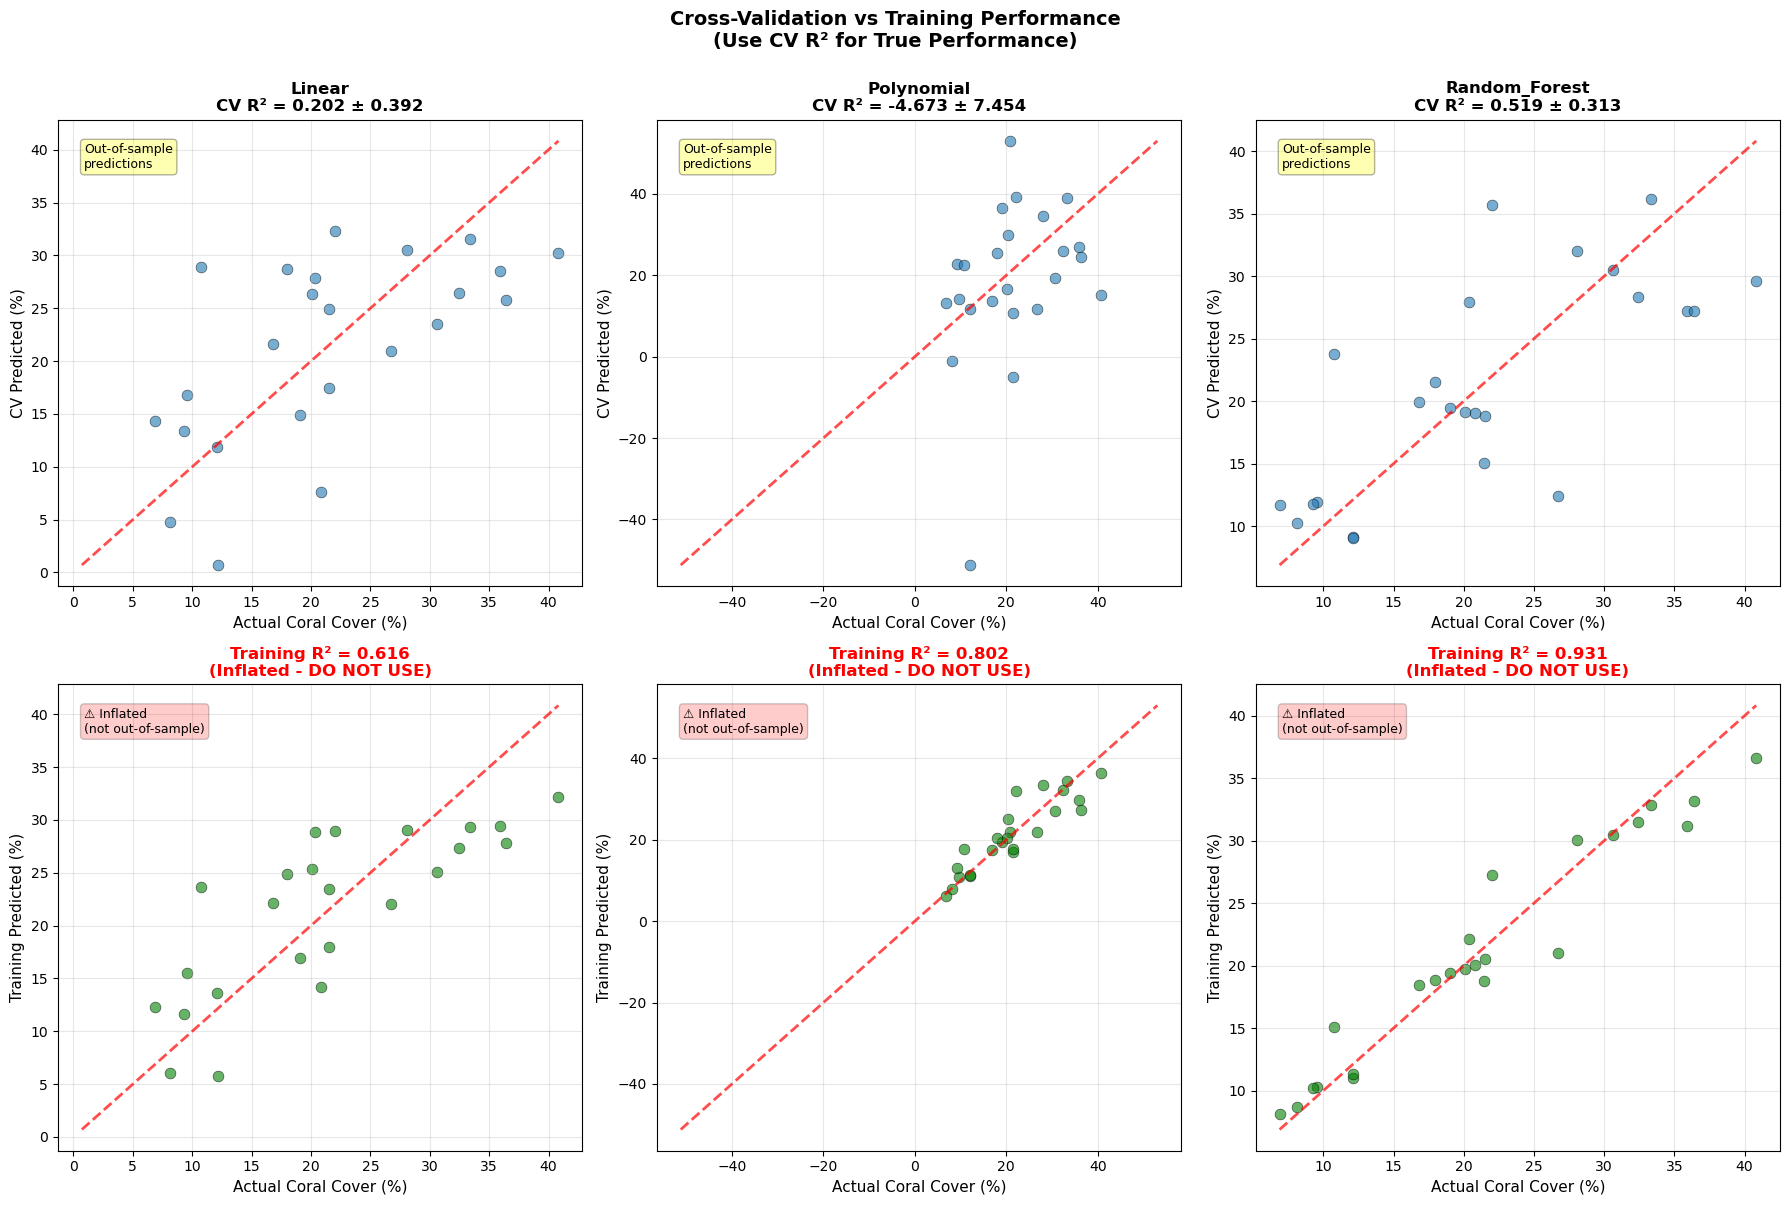

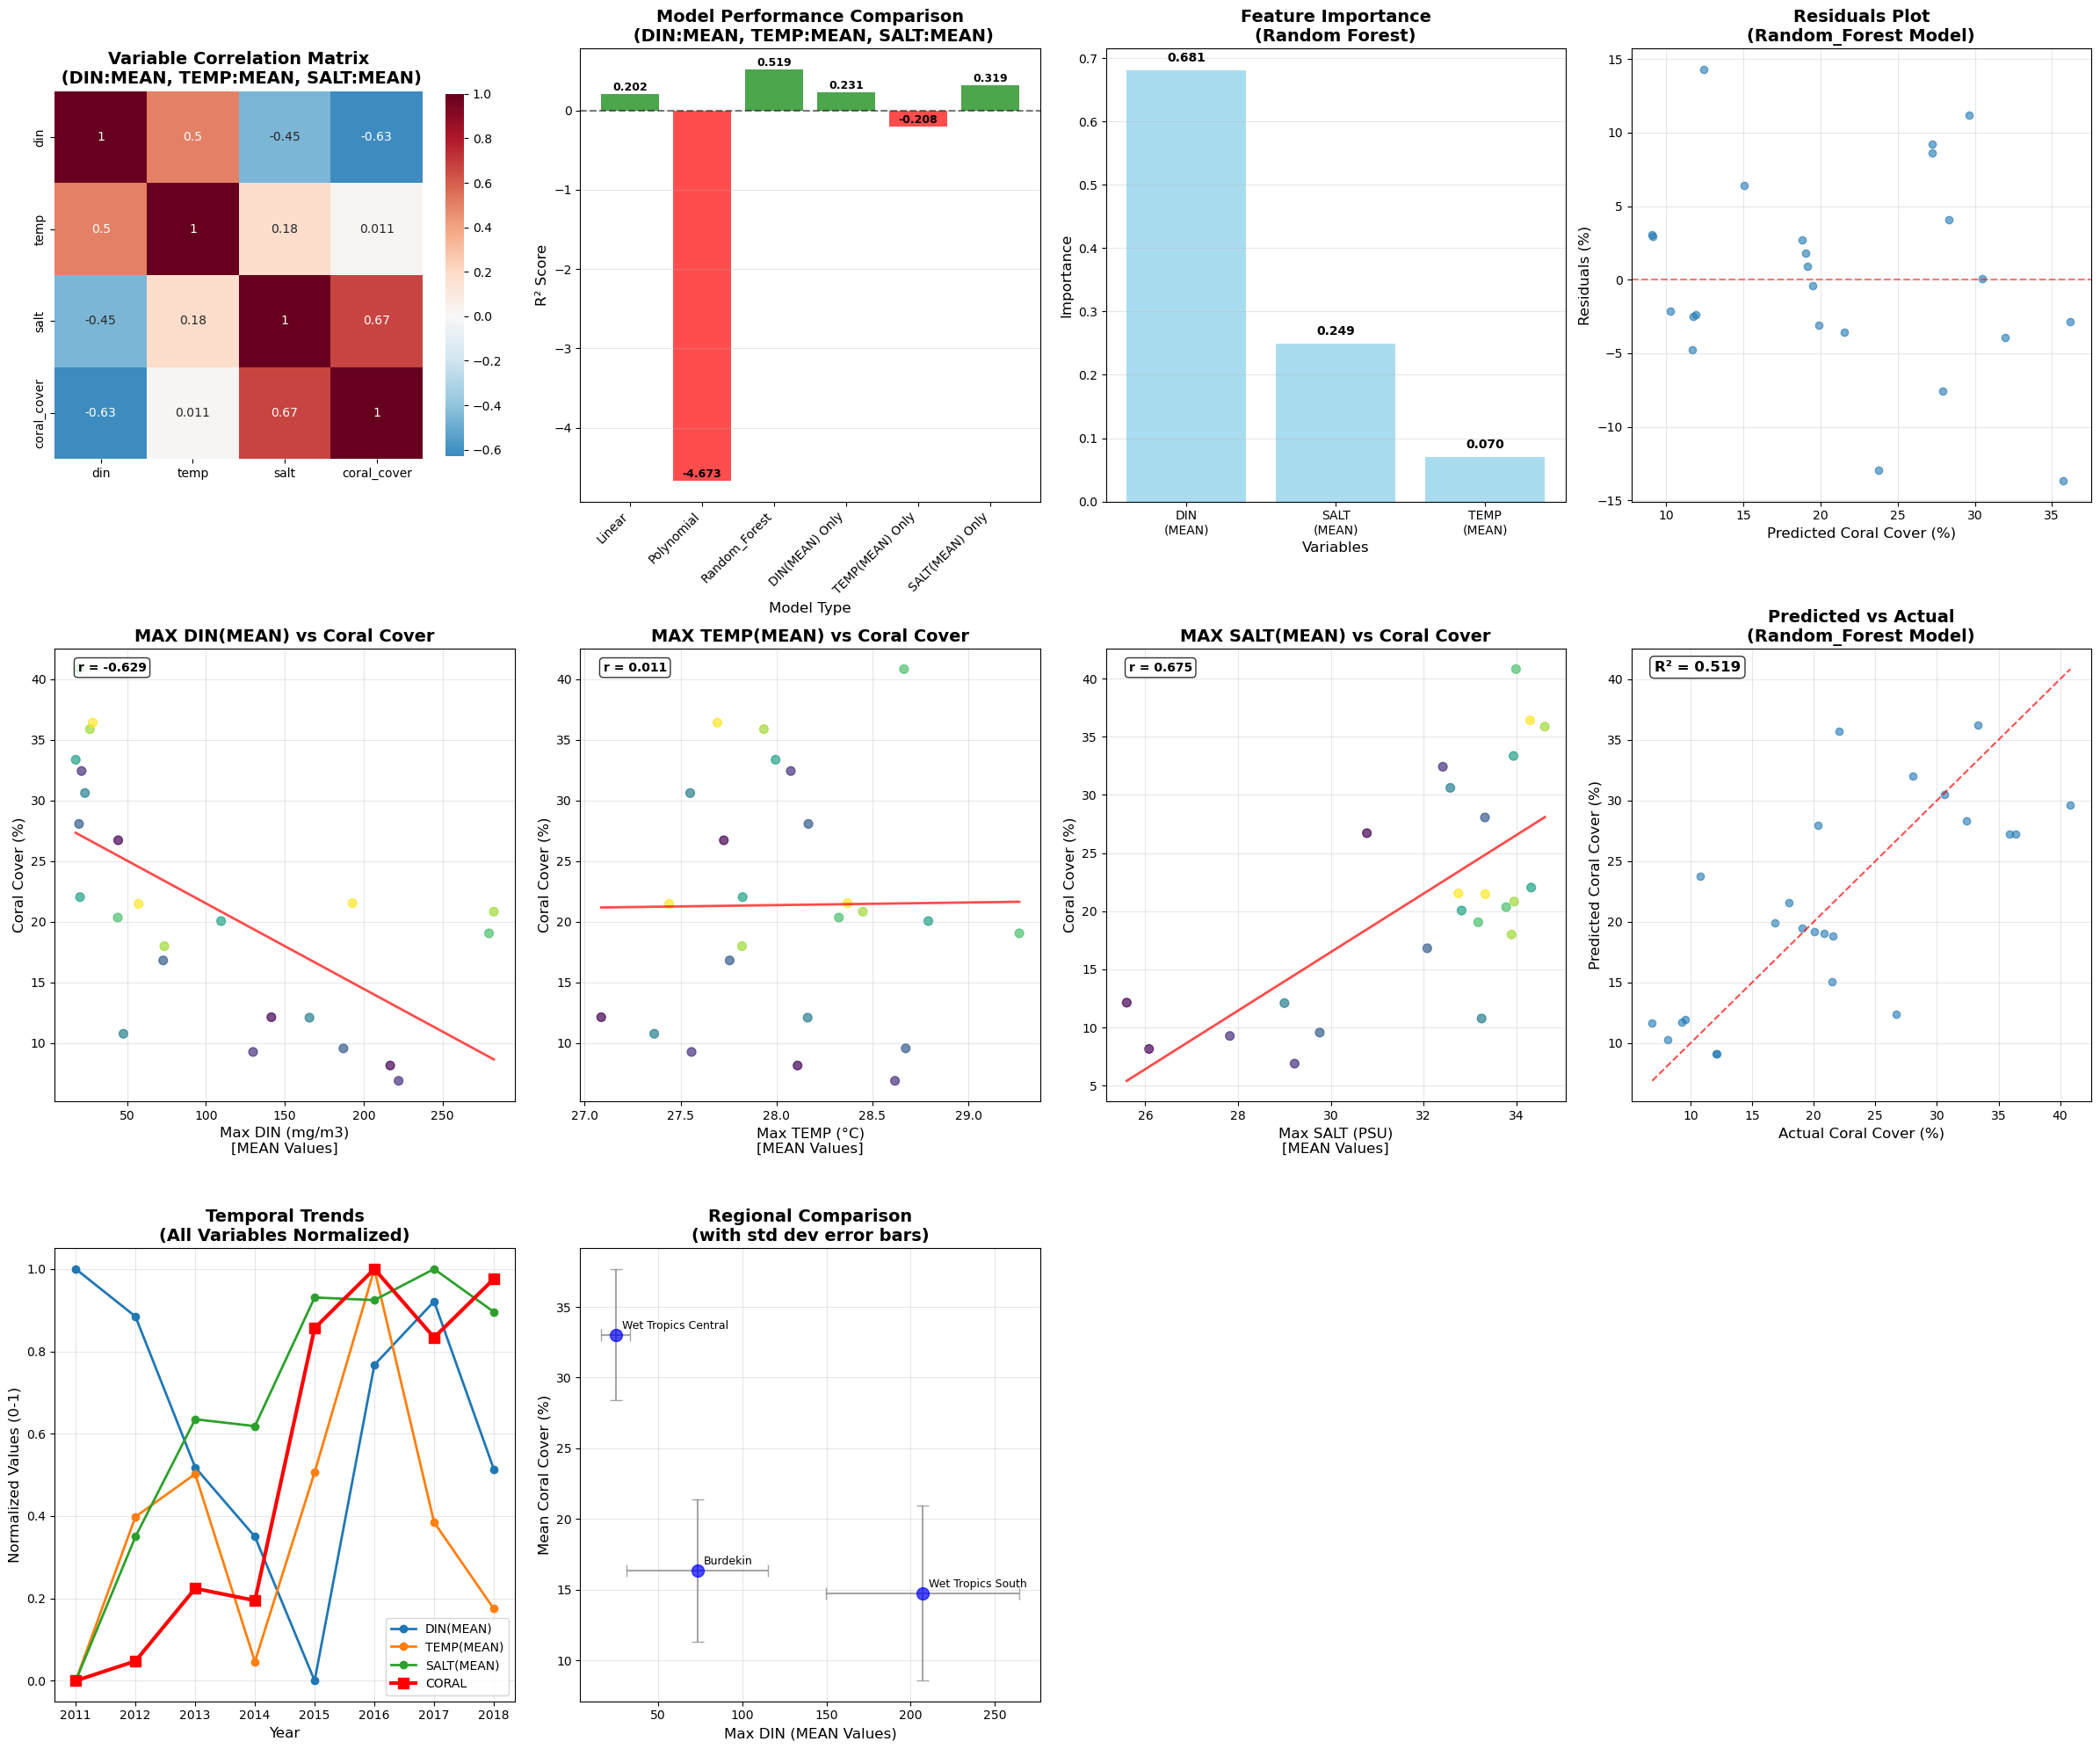

In [30]:
# Example usage
# Use different aggregation methods
variable_aggregation = {
    'DIN': 'mean',      
    'temp': 'mean',     
    'salt': 'mean'   
}
results = analyze_multivariable_coral_relationship(
    all_regional_data_dict=all_data,
    all_dates=all_dates,
    coral_csv_file='coraldata.csv',
    years_to_analyze=years_full,
    coral_group='hard coral',
    variable_aggregation=variable_aggregation,
    use_log_din=False,  # Enable log transformation
    save_outputs=True,
    output_prefix='my_cv_multivariable_analysis'
)


## Build Time Lag Model

In [31]:
def analyze_multivariable_time_lag(all_regional_data_dict, all_dates, coral_csv_file,
                                   max_lag_years=5, coral_group='hard coral',
                                   years_to_analyze=None, catchments=None,
                                   aggregation_method='annual',
                                   variable_aggregation=None):
    """
    Analyze time lag effects for multivariable model (DIN, temp, salt vs coral)
    
    Tests different lag periods to find when environmental conditions best predict
    future coral cover. For example, a 2-year lag means environmental data from year X
    is used to predict coral cover in year X+2.
    
    Parameters:
    -----------
    all_regional_data_dict : dict
        Dictionary with keys 'DIN', 'temp', 'salt' containing regional time series
    all_dates : list
        Datetime objects for environmental data
    coral_csv_file : str
        Path to coral CSV file
    max_lag_years : int, optional
        Maximum lag to test (in years). Default is 5.
    coral_group : str, optional
        Coral group to analyze. Default is 'hard coral'.
    years_to_analyze : list, optional
        Years to include in analysis
    catchments : list, optional
        Catchments to include
    aggregation_method : str, optional
        Temporal aggregation: 'annual', 'seasonal', 'monthly'. Default is 'annual'.
    variable_aggregation : dict, optional
        Variable-specific aggregation methods (e.g., {'DIN': 'max', 'temp': 'mean'})
        
    Returns:
    --------
    tuple of (dict, int, pd.DataFrame)
        - lag_results: dict with results for each lag period
        - best_lag: optimal lag period in years
        - lag_summary: DataFrame summarizing all lags tested
    """
    
    print("=== Multivariable Time Lag Analysis ===")
    print(f"Testing lags from 0 to {max_lag_years} years...")
    print(f"Variables: {list(all_regional_data_dict.keys())}")
    
    if variable_aggregation:
        print("Variable-specific aggregation methods:")
        for var, method in variable_aggregation.items():
            print(f"  - {var}: {method.upper()}")
    
    lag_results = {}
    correlation_summary = []
    
    for lag in range(max_lag_years + 1):
        print(f"\n  Testing {lag}-year lag...")
        
        try:
            # Prepare environmental data (will be shifted backward in time)
            # For lag=2: environmental year X predicts coral year X+2
            matched_data_lag, summary_lag = prepare_multivariable_coral_data_with_lag(
                all_regional_data_dict, 
                all_dates, 
                coral_csv_file,
                lag_years=lag,
                years_to_analyze=years_to_analyze,
                catchments=catchments,
                coral_group=coral_group,
                aggregation_method=aggregation_method,
                variable_aggregation=variable_aggregation,
                use_log_din=False
            )
            
            if len(matched_data_lag) < 10:
                print(f"    Insufficient data for {lag}-year lag: {len(matched_data_lag)} records")
                continue
            
            print(f"    Matched {len(matched_data_lag)} records")
            
            # Fit multivariable models for this lag 
            models_lag, results_lag, feature_importance_lag, cv_predictions, X_full, y_full = \
                fit_multivariable_coral_models_cv(matched_data_lag, cv_method='auto')
            
            # Get best model performance
            best_model_lag = max(results_lag.keys(), key=lambda x: results_lag[x]['cv_r2_mean'])
            best_r2_lag = results_lag[best_model_lag]['cv_r2_mean']
            best_rmse_lag = results_lag[best_model_lag]['cv_rmse_mean']
            
            # Calculate correlations for each variable
            var_correlations = {}
            for var in models_lag['available_vars']:
                if var in matched_data_lag.columns:
                    corr, p_val = stats.pearsonr(matched_data_lag[var], 
                                                 matched_data_lag['coral_cover'])
                    var_correlations[var] = {'correlation': corr, 'p_value': p_val}
            
            # Store results
            lag_results[lag] = {
                'matched_data': matched_data_lag,
                'models': models_lag,
                'results': results_lag,
                'feature_importance': feature_importance_lag,
                'best_model': best_model_lag,
                'best_r2': best_r2_lag,
                'best_rmse': best_rmse_lag,
                'variable_correlations': var_correlations,
                'n_records': len(matched_data_lag),
                'data_summary': summary_lag
            }
            
            # Add to summary
            summary_row = {
                'lag_years': lag,
                'best_model': best_model_lag,
                'best_r2': best_r2_lag,
                'best_rmse': best_rmse_lag,
                'n_records': len(matched_data_lag)
            }
            
            # Add variable-specific correlations
            for var, corr_info in var_correlations.items():
                summary_row[f'{var}_correlation'] = corr_info['correlation']
                summary_row[f'{var}_p_value'] = corr_info['p_value']
            
            correlation_summary.append(summary_row)
            
            print(f"    Best model: {best_model_lag} (R² = {best_r2_lag:.3f}, RMSE = {best_rmse_lag:.2f}%)")
            for var, corr_info in var_correlations.items():
                method = variable_aggregation.get(var.upper(), 'mean').upper() if variable_aggregation else 'MEAN'
                print(f"    {var.upper()}({method}) correlation: r = {corr_info['correlation']:.3f} (p = {corr_info['p_value']:.3f})")
            
        except Exception as e:
            print(f"    Error processing {lag}-year lag: {e}")
            continue
    
    # Find best lag
    lag_summary_df = pd.DataFrame(correlation_summary)
    
    if len(lag_summary_df) > 0:
        # Best lag based on R² (model performance)
        best_lag_idx = lag_summary_df['best_r2'].idxmax()
        best_lag = int(lag_summary_df.loc[best_lag_idx, 'lag_years'])
        best_r2 = lag_summary_df.loc[best_lag_idx, 'best_r2']
        best_model_name = lag_summary_df.loc[best_lag_idx, 'best_model']
        
        print(f"\n{'='*60}")
        print(f"BEST LAG PERIOD: {best_lag} years")
        print(f"Best model: {best_model_name}")
        print(f"Best R²: {best_r2:.3f}")
        print(f"RMSE: {lag_summary_df.loc[best_lag_idx, 'best_rmse']:.2f}%")
        print(f"Sample size: {int(lag_summary_df.loc[best_lag_idx, 'n_records'])} records")
        
        print(f"\nInterpretation: Environmental conditions from year X")
        print(f"best predict coral cover in year X+{best_lag}")
        print(f"{'='*60}")
    else:
        best_lag = 0
        print("\nWarning: No valid lag periods found")
    
    return lag_results, best_lag, lag_summary_df


def prepare_multivariable_coral_data_with_lag(all_regional_data_dict, all_dates, coral_csv_file,
                                              lag_years=0, years_to_analyze=None, catchments=None,
                                              coral_group='hard coral', aggregation_method='annual',
                                              variable_aggregation=None, use_log_din=False):
    """
    Prepare multivariable data with time lag applied
    
    This is a modified version of prepare_multivariable_coral_data that applies
    a time lag: environmental data from year X is matched with coral data from year X+lag
    
    Parameters:
    -----------
    lag_years : int
        Number of years to lag environmental data before coral response
        lag_years=0: no lag (same year)
        lag_years=2: env year X predicts coral year X+2
    
    [Other parameters same as prepare_multivariable_coral_data]
    
    Returns:
    --------
    Same as prepare_multivariable_coral_data
    """
    
    # [Most of the function is identical to prepare_multivariable_coral_data]
    # Key difference is in the matching logic:
    
    # Set default aggregation methods
    if variable_aggregation is None:
        variable_aggregation = {}
    
    expected_vars = ['DIN', 'temp', 'salt']
    for var in expected_vars:
        if var not in variable_aggregation:
            variable_aggregation[var] = 'mean'
    
    # Load coral data (same as before)
    coral_df = pd.read_csv(coral_csv_file)
    coral_df.columns = coral_df.columns.str.strip()
    coral_df['YEAR_CODE'] = pd.to_numeric(coral_df['YEAR_CODE'], errors='coerce')
    coral_df = coral_df.dropna(subset=['YEAR_CODE'])
    coral_df['YEAR_CODE'] = coral_df['YEAR_CODE'].astype(int)
    
    if coral_group.lower() != 'all':
        coral_df = coral_df[coral_df['GROUP_CODE'].str.lower() == coral_group.lower()]
    
    coral_agg = coral_df.groupby(['YEAR_CODE', 'NRM_REGION', 'CATCHMENT'])['COVER'].mean().reset_index()
    
    # Prepare environmental data (same aggregation as before)
    dates_df = pd.DataFrame({
        'datetime': all_dates,
        'year': [d.year for d in all_dates],
        'month': [d.month for d in all_dates]
    })
    
    variables_aggregated = {}
    available_vars = list(all_regional_data_dict.keys())
    
    for var_name, regional_data in all_regional_data_dict.items():
        if var_name not in expected_vars:
            continue
            
        variables_aggregated[var_name] = {}
        agg_method = variable_aggregation.get(var_name, 'mean')
        
        for region_name, timeseries in regional_data.items():
            if len(timeseries) == 0:
                continue
            
            temp_df = pd.DataFrame({
                'datetime': all_dates[:len(timeseries)],
                'year': [d.year for d in all_dates[:len(timeseries)]],
                'month': [d.month for d in all_dates[:len(timeseries)]],
                f'{var_name.lower()}': timeseries
            })
            
            temp_df = temp_df.dropna(subset=[f'{var_name.lower()}'])
            
            # Apply aggregation (same as before)
            if aggregation_method == 'annual':
                if agg_method == 'max':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].max().reset_index()
                elif agg_method == 'min':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].min().reset_index()
                elif agg_method == 'median':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].median().reset_index()
                else:
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].mean().reset_index()
            
            variables_aggregated[var_name][region_name] = region_agg
    
    # Region-catchment mapping
    region_catchment_mapping = {
        'Wet Tropics Central': ['Johnstone'],
        'Wet Tropics South': ['Tully'],
        'Burdekin': ['Burdekin']
    }
    
    # Create matched dataset WITH LAG
    matched_records = []
    reference_var = 'DIN' if 'DIN' in variables_aggregated else list(variables_aggregated.keys())[0]
    
    for region_name in variables_aggregated[reference_var].keys():
        possible_catchments = region_catchment_mapping.get(region_name, [region_name])
        
        region_data = {}
        for var_name in variables_aggregated.keys():
            if region_name in variables_aggregated[var_name]:
                region_data[var_name] = variables_aggregated[var_name][region_name]
        
        if len(region_data) != len([v for v in expected_vars if v in all_regional_data_dict]):
            continue
        
        year_sets = [set(var_data['year'].values) for var_data in region_data.values()]
        common_years = set.intersection(*year_sets) if year_sets else set()
        
        for env_year in common_years:
            # KEY DIFFERENCE: Apply time lag
            coral_year = env_year + lag_years  # Environmental year X predicts coral year X+lag
            
            year_values = {'env_year': env_year, 'coral_year': coral_year, 'region': region_name}
            
            # Get environmental values from env_year
            for var_name, var_data in region_data.items():
                year_row = var_data[var_data['year'] == env_year]
                if len(year_row) > 0:
                    year_values[var_name.lower()] = year_row.iloc[0][var_name.lower()]
            
            expected_lower = [v.lower() for v in expected_vars if v in all_regional_data_dict]
            if all(var in year_values for var in expected_lower):
                # Find coral data for coral_year (lagged)
                for catchment in possible_catchments:
                    coral_matches = coral_agg[
                        (coral_agg['YEAR_CODE'] == coral_year) &  # Match to lagged year
                        (coral_agg['CATCHMENT'].str.contains(catchment, case=False, na=False))
                    ]
                    
                    for _, coral_row in coral_matches.iterrows():
                        record = {
                            'year': coral_year,  # Store coral year as primary year
                            'env_year': env_year,
                            'lag_years': lag_years,
                            'din_region': region_name,
                            'coral_region': coral_row['NRM_REGION'],
                            'catchment': coral_row['CATCHMENT'],
                            'coral_cover': coral_row['COVER']
                        }
                        
                        for var in expected_lower:
                            if var in year_values:
                                record[var] = year_values[var]
                        
                        matched_records.append(record)
    
    matched_data = pd.DataFrame(matched_records)
    
    if len(matched_data) == 0:
        raise ValueError(f"No matched records found for {lag_years}-year lag")
    
    # Apply log transformation if requested
    if use_log_din and 'din' in matched_data.columns:
        matched_data['ln_din'] = np.log(matched_data['din'] + 0.001)
    
    # Apply filters
    if years_to_analyze is not None:
        matched_data = matched_data[matched_data['env_year'].isin(years_to_analyze)]
    
    if catchments is not None:
        catchments_lower = [c.lower() for c in catchments]
        matched_data = matched_data[matched_data['catchment'].str.lower().isin(catchments_lower)]
    
    matched_data = matched_data.dropna()
    
    # Create summary
    var_ranges = {}
    correlations = {}
    analysis_vars = expected_lower.copy()
    
    for var in analysis_vars:
        if var in matched_data.columns:
            var_ranges[var] = (matched_data[var].min(), matched_data[var].max())
            if len(matched_data) > 1:
                correlations[var] = matched_data[[var, 'coral_cover']].corr().iloc[0, 1]
    
    data_summary = {
        'total_records': len(matched_data),
        'env_years_covered': sorted(matched_data['env_year'].unique()) if len(matched_data) > 0 else [],
        'coral_years_covered': sorted(matched_data['year'].unique()) if len(matched_data) > 0 else [],
        'lag_years': lag_years,
        'regions_included': list(matched_data['din_region'].unique()) if len(matched_data) > 0 else [],
        'catchments_included': list(matched_data['catchment'].unique()) if len(matched_data) > 0 else [],
        'variable_ranges': var_ranges,
        'coral_range': (matched_data['coral_cover'].min(), matched_data['coral_cover'].max()) if len(matched_data) > 0 else (None, None),
        'correlations_with_coral': correlations,
        'available_variables': [col for col in matched_data.columns if col in analysis_vars],
        'aggregation_methods': {var.lower(): variable_aggregation.get(var, 'mean') for var in expected_vars},
        'temporal_aggregation': aggregation_method
    }
    
    return matched_data, data_summary

In [32]:
def plot_lag_analysis_results(lag_results, best_lag, lag_summary_df, 
                              save_plot=True, output_prefix='lag_analysis'):
    """
    Create comprehensive visualization of time lag analysis results
    
    Parameters:
    -----------
    lag_results : dict
        Results from analyze_multivariable_time_lag
    best_lag : int
        Optimal lag period in years
    lag_summary_df : pd.DataFrame
        Summary DataFrame with all lag periods
    save_plot : bool
        Whether to save figures
    output_prefix : str
        Prefix for output files
    """
    
    # Create 2x3 grid of subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # ========== 1. R² by Lag Period ==========
    ax1 = fig.add_subplot(gs[0, 0])
    
    lags = lag_summary_df['lag_years'].values
    r2_scores = lag_summary_df['best_r2'].values
    
    # Plot with markers
    ax1.plot(lags, r2_scores, 'o-', linewidth=3, markersize=12, color='steelblue', 
             markerfacecolor='lightblue', markeredgewidth=2, markeredgecolor='steelblue')
    
    # Highlight best lag
    best_idx = lag_summary_df['lag_years'] == best_lag
    best_r2 = lag_summary_df.loc[best_idx, 'best_r2'].values[0]
    ax1.scatter(best_lag, best_r2, s=400, color='red', marker='*', 
                edgecolors='darkred', linewidths=2, zorder=5, label=f'Best: {best_lag} years')
    
    ax1.set_xlabel('Lag Period (years)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Model R² Score', fontsize=13, fontweight='bold')
    ax1.set_title('Model Performance vs Lag Period', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    ax1.set_xticks(lags)
    
    # Add value labels
    for lag, r2 in zip(lags, r2_scores):
        ax1.text(lag, r2 + 0.02, f'{r2:.3f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    # ========== 2. RMSE by Lag Period ==========
    ax2 = fig.add_subplot(gs[0, 1])
    
    rmse_scores = lag_summary_df['best_rmse'].values
    
    bars = ax2.bar(lags, rmse_scores, color='coral', alpha=0.7, edgecolor='darkred', linewidth=1.5)
    bars[np.where(lags == best_lag)[0][0]].set_color('green')
    bars[np.where(lags == best_lag)[0][0]].set_alpha(0.8)
    
    ax2.set_xlabel('Lag Period (years)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('RMSE (%)', fontsize=13, fontweight='bold')
    ax2.set_title('Prediction Error vs Lag Period\n(Lower is Better)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticks(lags)
    
    # Add value labels
    for bar, rmse in zip(bars, rmse_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{rmse:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # ========== 3. Variable Correlations Over Lag ==========
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Extract correlation columns
    din_corrs = lag_summary_df['din_correlation'].values
    temp_corrs = lag_summary_df['temp_correlation'].values
    salt_corrs = lag_summary_df['salt_correlation'].values
    
    ax3.plot(lags, din_corrs, 'o-', linewidth=2, markersize=8, label='DIN', color='blue')
    ax3.plot(lags, temp_corrs, 's-', linewidth=2, markersize=8, label='Temperature', color='red')
    ax3.plot(lags, salt_corrs, '^-', linewidth=2, markersize=8, label='Salinity', color='green')
    
    # Highlight best lag
    ax3.axvline(x=best_lag, color='gray', linestyle='--', linewidth=2, alpha=0.7, 
                label=f'Best lag ({best_lag} yr)')
    
    ax3.set_xlabel('Lag Period (years)', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Correlation with Coral Cover', fontsize=13, fontweight='bold')
    ax3.set_title('Variable Correlations vs Lag Period', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=10)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_xticks(lags)
    
    # ========== 4. Model Comparison at Best Lag ==========
    ax4 = fig.add_subplot(gs[1, 0])
    
    best_lag_results = lag_results[best_lag]['results']
    model_names = list(best_lag_results.keys())
    model_r2s = [best_lag_results[m]['cv_r2_mean'] for m in model_names]
    
    # Sort by R²
    sorted_indices = np.argsort(model_r2s)[::-1]
    model_names_sorted = [model_names[i] for i in sorted_indices]
    model_r2s_sorted = [model_r2s[i] for i in sorted_indices]
    
    colors = ['green' if r2 >= 0 else 'red' for r2 in model_r2s_sorted]
    bars = ax4.barh(model_names_sorted, model_r2s_sorted, color=colors, alpha=0.7, 
                    edgecolor='black', linewidth=1.5)
    
    ax4.set_xlabel('R² Score', fontsize=13, fontweight='bold')
    ax4.set_title(f'Model Comparison at {best_lag}-Year Lag', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    ax4.axvline(x=0, color='black', linestyle='-', linewidth=1)
    
    # Add value labels
    for i, (bar, r2) in enumerate(zip(bars, model_r2s_sorted)):
        width = bar.get_width()
        ax4.text(width + 0.02, bar.get_y() + bar.get_height()/2.,
                f'{r2:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    # ========== 5. Feature Importance at Best Lag ==========
    ax5 = fig.add_subplot(gs[1, 1])
    
    if 'random_forest' in lag_results[best_lag]['feature_importance']:
        feature_imp = lag_results[best_lag]['feature_importance']['random_forest']
        vars_sorted = sorted(feature_imp.items(), key=lambda x: x[1], reverse=True)
        var_names, importances = zip(*vars_sorted)
        
        bars = ax5.bar(range(len(var_names)), importances, color='skyblue', 
                      alpha=0.7, edgecolor='steelblue', linewidth=2)
        
        ax5.set_ylabel('Feature Importance', fontsize=13, fontweight='bold')
        ax5.set_title(f'Variable Importance at {best_lag}-Year Lag\n(Random Forest)', 
                     fontsize=14, fontweight='bold')
        ax5.set_xticks(range(len(var_names)))
        ax5.set_xticklabels([v.upper() for v in var_names], fontsize=11)
        ax5.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, imp in zip(bars, importances):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{imp:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # ========== 6. Summary Statistics Table ==========
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    # Create summary table
    best_lag_info = lag_results[best_lag]
    var_corrs = best_lag_info['variable_correlations']
    
    table_data = [
        ['Metric', 'Value'],
        ['', ''],
        ['OPTIMAL LAG', f'{best_lag} years'],
        ['Best Model', best_lag_info['best_model'].title()],
        ['R² Score', f"{best_lag_info['best_r2']:.3f}"],
        ['RMSE', f"{best_lag_info['best_rmse']:.2f}%"],
        ['Sample Size', f"{best_lag_info['n_records']}"],
        ['', ''],
        ['VARIABLE CORRELATIONS', ''],
    ]
    
    for var, corr_info in var_corrs.items():
        sig = '***' if corr_info['p_value'] < 0.001 else '**' if corr_info['p_value'] < 0.01 else '*' if corr_info['p_value'] < 0.05 else ''
        table_data.append([f'{var.upper()}', f"{corr_info['correlation']:.3f}{sig}"])
    
    table_data.append(['', ''])
    table_data.append(['INTERPRETATION', ''])
    table_data.append(['Env Year X predicts', ''])
    table_data.append([f'Coral Year X+{best_lag}', ''])
    
    table = ax6.table(cellText=table_data[1:], colLabels=table_data[0],
                     cellLoc='left', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8)
    
    # Style header
    for i in range(2):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Highlight key rows
    for i in [2, 8, 11]:
        if i < len(table_data):
            table[(i, 0)].set_facecolor('#e6f2ff')
            table[(i, 0)].set_text_props(weight='bold')
    
    ax6.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)
    
    # Overall title
    fig.suptitle(f'Time Lag Analysis: Environmental Conditions → Coral Cover Response\n'
                 f'Optimal Lag = {best_lag} Years (R² = {best_lag_info["best_r2"]:.3f})', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(f'{output_prefix}_visualization.png', dpi=300, bbox_inches='tight')
        print(f"\nVisualization saved: {output_prefix}_visualization.png")
    
    plt.show()
    
    return fig

### Run Time Lag Model

=== Multivariable Time Lag Analysis ===
Testing lags from 0 to 5 years...
Variables: ['DIN', 'temp', 'salt']

  Testing 0-year lag...
    Matched 24 records
Using predictor variables: ['din', 'temp', 'salt']
Sample size: 24
Using 5-Fold CV for model evaluation
Number of CV iterations: 5

Fitting and evaluating models with cross-validation...

1. Multiple Linear Regression
   CV R² = 0.202 ± 0.392
   CV RMSE = 7.90 ± 1.47%
   Training R² = 0.616 (on full dataset)

2. Polynomial Regression (with scaling)
   CV R² = -4.673 ± 7.454
   CV RMSE = 18.76%
   Training R² = 0.802 (on full dataset)

3. Random Forest Regressor
   CV R² = 0.519 ± 0.313
   CV RMSE = 6.16 ± 2.30%
   Training R² = 0.931 (on full dataset)

4. Individual Variable Models
   DIN: CV R² = 0.231 ± 0.332
   TEMP: CV R² = -0.208 ± 0.139
   SALT: CV R² = 0.319 ± 0.234

Multiple Linear Regression Equation:
Coral Cover = -139.770 + -0.065 * din + 4.398 * temp + 1.387 * salt

Feature Importance (Random Forest):
  din: 0.681
  sal

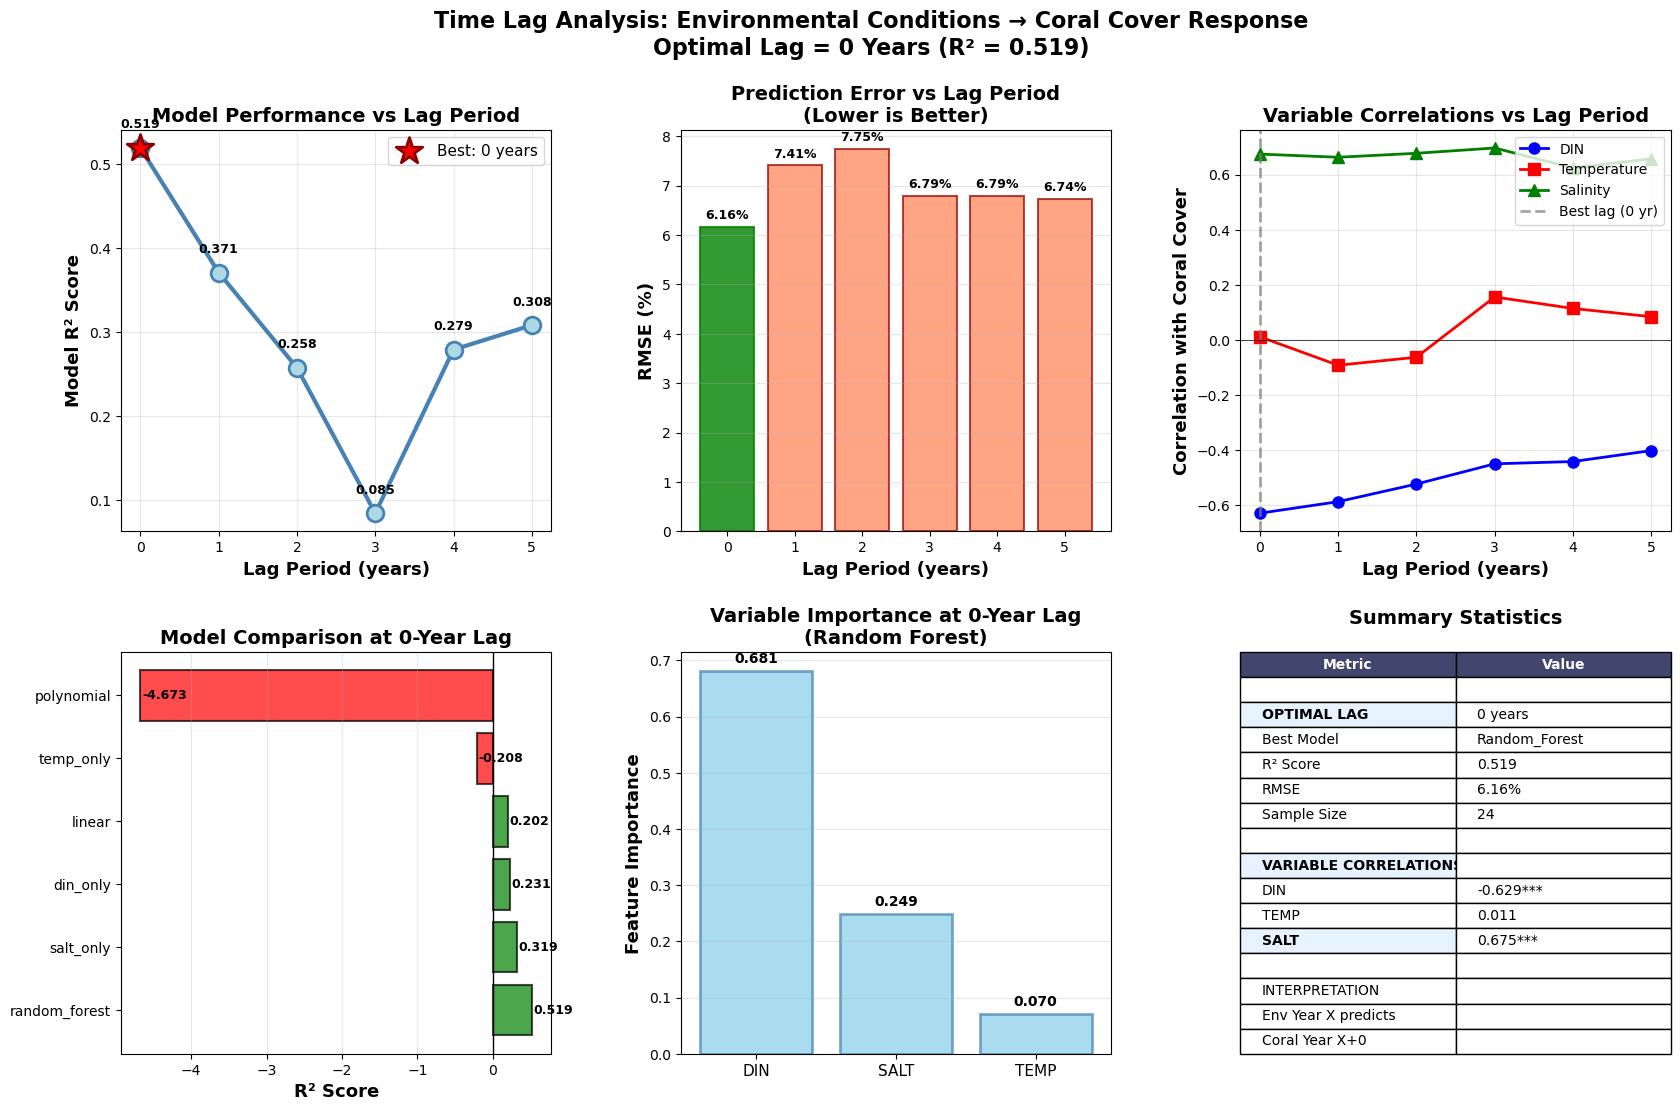

In [33]:
# 2. Run complete analysis with automatic lag detection
lag_results, best_lag, lag_summary_df = analyze_multivariable_time_lag(
    all_regional_data_dict=all_data, 
    all_dates=all_dates, 
    coral_csv_file='coraldata.csv',
    max_lag_years=5, 
    coral_group='hard coral',
    years_to_analyze=list(range(2011, 2019)), 
    catchments=None,
    aggregation_method='annual',
    variable_aggregation=None
)

# # 3. Alternative: Test specific lag if we have hypothesis
# results_2yr_lag = analyze_din_coral_with_lag(
#     all_regional_data=all_regional_data,
#     all_dates=all_dates,
#     coral_csv_file='coraldata.csv',
#     optimal_lag=2,  # Force 2-year lag
#     years_to_analyze=list(range(2011, 2019)),
#     coral_group='hard coral',
#     output_prefix='din_coral_2011_2018_lag2'
#)

# 4. Compare lag periods
print("\n=== Comparison of Lag Periods ===")
for lag in range(6):  # 0 to 5 years
    if lag in lag_results:
        lag_data = lag_results[lag]
        
        # Get correlation for first variable (DIN)
        first_var = list(lag_data['variable_correlations'].keys())[0]
        r_value = lag_data['variable_correlations'][first_var]['correlation']
        
        print(f"Lag {lag}: Best model R² = {lag_data['best_r2']:.3f}, "
              f"RMSE = {lag_data['best_rmse']:.2f}%, "
              f"n = {lag_data['n_records']}")

# 5. Get best model info
print(f"\n=== Optimal Configuration ===")
print(f"Best lag: {best_lag} years")
if best_lag in lag_results:
    best_lag_info = lag_results[best_lag]
    print(f"Best model: {best_lag_info['best_model']}")
    print(f"R²: {best_lag_info['best_r2']:.3f}")
    print(f"RMSE: {best_lag_info['best_rmse']:.2f}%")
    
    # Show variable correlations at best lag
    print(f"\nVariable correlations at {best_lag}-year lag:")
    for var, corr_info in best_lag_info['variable_correlations'].items():
        print(f"  {var.upper()}: r = {corr_info['correlation']:.3f} (p = {corr_info['p_value']:.3f})")

# 6. Display summary table
print("\n=== Summary Table ===")
print(lag_summary_df.to_string(index=False))

# 7. Access the best lag model and data for further use
best_lag_models = lag_results[best_lag]['models']
best_lag_matched_data = lag_results[best_lag]['matched_data']
best_lag_model_results = lag_results[best_lag]['results']

#8 Create comprehensive visualization
plot_lag_analysis_results(
    lag_results, 
    best_lag, 
    lag_summary_df, 
    save_plot=True, 
    output_prefix='multivariable_lag_analysis'
)

print(f"\nYou can now use the best lag ({best_lag} years) for predictions and scenarios")

## Application of Model

### Load Best Lag Data

In [34]:
# Multivariable Model Building WITH LAG
variables_to_load = ['DIN', 'temp', 'salt']
variable_aggregation_methods = {
    'DIN': 'max',
    'temp': 'max', 
    'salt': 'min'
}
all_data = {}

years_full = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
lag_year = 0
    
for var_name in variables_to_load:
    agg_method = variable_aggregation_methods[var_name]
    
    regional_data, dates, var_dict = load_multiyear_data(
        years_full, months_to_process, var_name, dataset_template, 
        agg_method=agg_method,
        use_cache=True, 
        cache_dir='data_cache'  
    )
    all_data[var_name] = regional_data
    
    print(f"Loaded {var_name} with {agg_method.upper()} aggregation")

coral_csv_file = 'coraldata.csv'

# MODIFIED: Use lag preparation function
variable_aggregation = {
    'DIN': 'mean',      
    'temp': 'mean',     
    'salt': 'mean'   
}

# Prepare data with 3-year lag
print(f"\n=== Preparing Data with {lag_year}-Year Lag ===")
matched_data_lag, summary_lag = prepare_multivariable_coral_data_with_lag(
    all_regional_data_dict=all_data,
    all_dates=all_dates,
    coral_csv_file='coraldata.csv',
    lag_years=lag_year,  # Variable lag
    years_to_analyze=years_full,
    coral_group='hard coral',
    aggregation_method='annual',
    variable_aggregation=variable_aggregation,
    use_log_din=False
)

print(f"\nData with {lag_year}-year lag:")
print(f"- Total records: {len(matched_data_lag)}")
print(f"- Environmental years: {summary_lag['env_years_covered']}")
print(f"- Coral years: {summary_lag['coral_years_covered']}")
print(f"- Interpretation: Env data from year X predicts coral in year X+{lag_year}")

# Train models on lagged data
print("\n=== Training Models on Lagged Data ===")
models, results, feature_importance, cv_predictions, X_full, y_full = \
    fit_multivariable_coral_models_cv(matched_data_lag, cv_method='auto')

# Create comprehensive analysis with lag information
results_with_lag = {
    'matched_data': matched_data_lag,
    'data_summary': summary_lag,
    'models': models,
    'model_results': results,
    'feature_importance': feature_importance,
    'best_model': max(results.keys(), key=lambda x: results[x]['cv_r2_mean']),
    'lag_years': lag_year,  # STORE LAG INFORMATION
    'variable_aggregation': variable_aggregation
}


Loaded data from cache: data_cache/DIN_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
Cache created: 2025-09-29 23:46:23.687716
Depth Index: -1
Aggregation method: max
Loaded DIN with MAX aggregation
Loaded data from cache: data_cache/temp_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
Cache created: 2025-09-30 09:44:01.106132
Depth Index: -1
Aggregation method: max
Loaded temp with MAX aggregation
Loaded data from cache: data_cache/salt_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmin.pkl
Cache created: 2025-10-01 12:50:24.640208
Depth Index: -1
Aggregation method: min
Loaded salt with MIN aggregation

=== Preparing Data with 0-Year Lag ===

Data with 0-year lag:
- Total records: 24
- Environmental years: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018)]
- Coral years: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2

### Predicted vs Actual with Lag

In [41]:
def plot_cv_predicted_vs_actual_timeseries_with_lag(results_package, cv_predictions, 
                                                     lag_years=0,
                                                     save_plot=True, 
                                                     output_prefix='coral_cv_predictions'):
    """
    Create time series plot showing CV predicted vs actual coral cover with lag consideration.
    Uses honest out-of-sample predictions from cross-validation.
    
    Parameters:
    -----------
    results_package : dict
        Output from analyze_multivariable_coral_relationship
    cv_predictions : dict
        Cross-validation predictions from fit_multivariable_coral_models_cv
    lag_years : int, optional
        Number of years of lag between environmental data and coral data. 
        Default is 0 for no lag
    save_plot : bool
        Whether to save the plot
    output_prefix : str
        Prefix for saved plot file
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    comparison_df : pd.DataFrame
        DataFrame with actual vs CV predicted values
    """
    
    matched_data = results_package['matched_data']
    models = results_package['models']
    model_results = results_package['model_results']
    best_model_name = results_package['best_model']
    available_vars = models['available_vars']
    
    # Get CV predictions (HONEST predictions)
    y_actual = matched_data['coral_cover'].values
    y_predicted_cv = cv_predictions[best_model_name]
    
    # Get CV performance metrics
    cv_r2 = model_results[best_model_name]['cv_r2_mean']
    cv_r2_std = model_results[best_model_name]['cv_r2_std']
    cv_rmse = model_results[best_model_name]['cv_rmse_mean']
    
    # Also get training metrics for comparison
    train_r2 = model_results[best_model_name]['train_r2']
    
    print(f"\n{'='*70}")
    print(f"Model Performance Summary ({best_model_name}, {lag_years}-year lag):")
    print(f"{'='*70}")
    print(f"CV R² (TRUE out-of-sample):    {cv_r2:.3f} ± {cv_r2_std:.3f}")
    print(f"CV RMSE:                       {cv_rmse:.2f}%")
    print(f"Training R² (INFLATED):        {train_r2:.3f}")
    print(f"Inflation factor:              {train_r2 - cv_r2:+.3f}")
    print(f"{'='*70}")
    print(f"\n⚠️  ALWAYS report CV R² ({cv_r2:.3f}), NOT training R² ({train_r2:.3f})")
    print(f"CV predictions represent TRUE predictive ability!\n")
    
    # Create comparison DataFrame WITH LAG INFORMATION
    if 'env_year' in matched_data.columns and 'lag_years' in matched_data.columns:
        # Data already has lag information
        comparison_df = matched_data[['year', 'env_year', 'lag_years', 
                                     'din_region', 'coral_region', 'catchment']].copy()
    else:
        # Add lag information if not present
        comparison_df = matched_data[['year', 'din_region', 'coral_region', 'catchment']].copy()
        comparison_df['env_year'] = comparison_df['year'] - lag_years
        comparison_df['lag_years'] = lag_years
    
    comparison_df['actual_coral_cover'] = y_actual
    comparison_df['predicted_coral_cover_cv'] = y_predicted_cv
    comparison_df['residuals_cv'] = y_actual - y_predicted_cv
    
    for var in available_vars:
        comparison_df[f'{var}_value'] = matched_data[var]
    
    # Create visualization with better spacing
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    
    lag_text = f'{lag_years}-Year Lag' if lag_years > 0 else 'No Lag'
    lag_subtitle = f'(Env Year X → Coral Year X+{lag_years})' if lag_years > 0 else ''
    
    fig.suptitle(f'Coral Cover: Cross-Validation Predictions with {lag_text}\n'
                 f'{lag_subtitle} | Model: {best_model_name.title()} | CV R² = {cv_r2:.3f} ± {cv_r2_std:.3f}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Time series comparison
    ax1 = axes[0, 0]
    
    # Group by CORAL year for plotting
    yearly_actual = comparison_df.groupby('year')['actual_coral_cover'].mean()
    yearly_predicted_cv = comparison_df.groupby('year')['predicted_coral_cover_cv'].mean()
    yearly_std_actual = comparison_df.groupby('year')['actual_coral_cover'].std()
    yearly_std_predicted = comparison_df.groupby('year')['predicted_coral_cover_cv'].std()
    
    coral_years = yearly_actual.index
    
    ax1.errorbar(coral_years, yearly_actual, yerr=yearly_std_actual, 
                label='Actual Coral Cover', marker='o', linewidth=2.5, 
                capsize=5, color='blue', markersize=8)
    
    if lag_years > 0:
        pred_label = f'CV Predicted (from env {lag_years} yrs prior)'
    else:
        pred_label = 'CV Predicted (out-of-sample)'
    
    ax1.errorbar(coral_years, yearly_predicted_cv, yerr=yearly_std_predicted, 
                label=pred_label, marker='s', linewidth=2.5, 
                capsize=5, color='red', markersize=8, alpha=0.8)
    
    ax1.set_xlabel('Coral Survey Year', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Mean Coral Cover (%)', fontsize=12, fontweight='bold')
    
    if lag_years > 0:
        title_text = f'Actual vs CV Predicted\n({lag_years}-year lag, out-of-sample)'
    else:
        title_text = 'Actual vs CV Predicted\n(Out-of-sample, no lag)'
    
    ax1.set_title(title_text, fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Add performance box
    if lag_years > 0:
        box_text = f'Env Year X → Coral Year X+{lag_years}\nCV R² = {cv_r2:.3f} ± {cv_r2_std:.3f}\nCV RMSE = {cv_rmse:.2f}%'
    else:
        box_text = f'CV R² = {cv_r2:.3f} ± {cv_r2_std:.3f}\nCV RMSE = {cv_rmse:.2f}%'
    
    ax1.text(0.05, 0.95, box_text, 
            transform=ax1.transAxes, fontsize=9, fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # 2. Scatter plot: CV predictions vs actual
    ax2 = axes[0, 1]
    
    scatter = ax2.scatter(y_actual, y_predicted_cv, c=comparison_df['env_year'], 
                         cmap='viridis', alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
    
    min_val = min(y_actual.min(), y_predicted_cv.min())
    max_val = max(y_actual.max(), y_predicted_cv.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2)
    
    ax2.set_xlabel('Actual Coral Cover (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('CV Predicted Coral Cover (%)', fontsize=12, fontweight='bold')
    
    if lag_years > 0:
        scatter_title = f'CV Predictions vs Actual\n(colored by env year, {lag_years}yr lag)'
    else:
        scatter_title = 'CV Predictions vs Actual\n(out-of-sample, colored by year)'
    
    ax2.set_title(scatter_title, fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Environmental Year', fontsize=10)
    
    # Add R² text
    ax2.text(0.05, 0.95, f'CV R² = {cv_r2:.3f}\n(TRUE performance)', 
            transform=ax2.transAxes, fontsize=10, fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    # 3. Lag visualization (if lag > 0) or residuals plot (if no lag)
    ax3 = axes[0, 2]
    
    if lag_years > 0:
        # Show the temporal relationship
        sample_years = comparison_df[['env_year', 'year']].drop_duplicates().sort_values('env_year')
        
        for idx, row in enumerate(sample_years.iterrows()):
            _, data = row
            y_pos = 1 + (idx % 3) * 0.3  # Stagger arrows slightly
            ax3.arrow(data['env_year'], y_pos, 
                     data['year'] - data['env_year'] - 0.2, 0,
                     head_width=0.12, head_length=0.15, 
                     fc='blue', ec='blue', alpha=0.6, linewidth=1.5)
        
        # Add labels
        unique_env_years = sample_years['env_year'].unique()[:5]  # Show first 5
        unique_coral_years = sample_years['year'].unique()[:5]
        
        for env_yr in unique_env_years:
            ax3.text(env_yr, 2.2, f"{int(env_yr)}", 
                    ha='center', fontsize=9, color='darkblue', fontweight='bold')
        
        for coral_yr in unique_coral_years:
            ax3.text(coral_yr, 0.2, f"{int(coral_yr)}", 
                    ha='center', fontsize=9, color='darkgreen', fontweight='bold')
        
        ax3.text(0.5, 0.85, 'Environmental\nData Year', transform=ax3.transAxes,
                ha='center', fontsize=11, fontweight='bold', color='darkblue')
        ax3.text(0.5, 0.05, f'Coral Survey\nYear (+{lag_years})', transform=ax3.transAxes,
                ha='center', fontsize=11, fontweight='bold', color='darkgreen')
        
        ax3.set_ylim(0, 2.5)
        ax3.set_xlim(sample_years['env_year'].min() - 0.5, 
                     sample_years['year'].max() + 0.5)
        ax3.set_title(f'{lag_years}-Year Lag Structure\n(Env → Coral)', 
                     fontsize=13, fontweight='bold')
        ax3.axis('off')
    else:
        # Residuals plot for no-lag case
        ax3.scatter(y_predicted_cv, comparison_df['residuals_cv'], 
                   alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
        ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
        
        ax3.set_xlabel('CV Predicted (%)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Residuals (Actual - Predicted) (%)', fontsize=12, fontweight='bold')
        ax3.set_title('Residual Plot\n(CV Predictions)', fontsize=13, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        residual_mean = comparison_df['residuals_cv'].mean()
        residual_std = comparison_df['residuals_cv'].std()
        ax3.text(0.05, 0.95, f'Mean: {residual_mean:.2f}%\nStd: {residual_std:.2f}%', 
                transform=ax3.transAxes, fontsize=10, fontweight='bold',
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 4. Regional comparison
    ax4 = axes[1, 0]
    
    regional_comparison = comparison_df.groupby('coral_region').agg({
        'actual_coral_cover': ['mean', 'std'],
        'predicted_coral_cover_cv': ['mean', 'std']
    }).reset_index()
    
    regional_comparison.columns = ['region', 'actual_mean', 'actual_std', 
                                   'predicted_mean', 'predicted_std']
    
    x_pos = np.arange(len(regional_comparison))
    width = 0.35
    
    ax4.bar(x_pos - width/2, regional_comparison['actual_mean'], width,
           yerr=regional_comparison['actual_std'], label='Actual', 
           alpha=0.7, color='blue', capsize=5)
    ax4.bar(x_pos + width/2, regional_comparison['predicted_mean'], width,
           yerr=regional_comparison['predicted_std'], label='CV Predicted', 
           alpha=0.7, color='red', capsize=5)
    
    ax4.set_xlabel('Region', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Mean Coral Cover (%)', fontsize=12, fontweight='bold')
    
    if lag_years > 0:
        title_text = f'Regional Comparison\n(CV predictions, {lag_years}yr lag)'
    else:
        title_text = 'Regional Comparison\n(CV predictions)'
    
    ax4.set_title(title_text, fontsize=13, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(regional_comparison['region'], rotation=30, ha='right')
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Model comparison: CV vs Training R²
    ax5 = axes[1, 1]
    
    model_names = ['linear', 'polynomial', 'random_forest']
    cv_r2_values = [model_results[m]['cv_r2_mean'] for m in model_names if m in model_results]
    train_r2_values = [model_results[m]['train_r2'] for m in model_names if m in model_results]
    model_labels = [m.title() for m in model_names if m in model_results]
    
    x_pos = np.arange(len(model_labels))
    width = 0.35
    
    bars1 = ax5.bar(x_pos - width/2, cv_r2_values, width, 
                    label='CV R² (TRUE)', alpha=0.8, color='green')
    bars2 = ax5.bar(x_pos + width/2, train_r2_values, width, 
                    label='Training R² (INFLATED)', alpha=0.6, color='red')
    
    # Add value labels
    for bar, val in zip(bars1, cv_r2_values):
        ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    for bar, val in zip(bars2, train_r2_values):
        ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold', 
                fontsize=9, color='darkred')
    
    ax5.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax5.set_title('CV vs Training R²\n(Always Report CV R²!)', fontsize=13, fontweight='bold')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(model_labels)
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.set_ylim(0, 1.0)
    
    # 6. Performance summary table
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    summary_text = f"CV PERFORMANCE SUMMARY\n"
    summary_text += f"{'='*40}\n\n"
    summary_text += f"Model: {best_model_name.title()}\n"
    if lag_years > 0:
        summary_text += f"Lag: {lag_years} years\n"
        summary_text += f"  (Env Year X → Coral Year X+{lag_years})\n\n"
    else:
        summary_text += f"Lag: None (concurrent)\n\n"
    
    summary_text += f"CV Metrics (TRUE performance):\n"
    summary_text += f"  • R² = {cv_r2:.3f} ± {cv_r2_std:.3f}\n"
    summary_text += f"  • RMSE = {cv_rmse:.2f}%\n\n"
    summary_text += f"Training Metrics (INFLATED):\n"
    summary_text += f"  • R² = {train_r2:.3f}\n"
    summary_text += f"  • Inflation = {train_r2 - cv_r2:+.3f}\n\n"
    summary_text += f"Sample Info:\n"
    summary_text += f"  • Samples: {len(comparison_df)}\n"
    summary_text += f"  • Coral years: {comparison_df['year'].min()}-{comparison_df['year'].max()}\n"
    if lag_years > 0:
        summary_text += f"  • Env years: {comparison_df['env_year'].min()}-{comparison_df['env_year'].max()}\n"
    summary_text += f"  • Regions: {len(comparison_df['coral_region'].unique())}\n\n"
    summary_text += f"⚠️ REPORT: CV R² = {cv_r2:.3f}\n"
    summary_text += f"   NOT: Train R² = {train_r2:.3f}"
    
    ax6.text(0.05, 0.98, summary_text, transform=ax6.transAxes, fontsize=9.5,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
    plt.subplots_adjust(hspace=0.35, wspace=0.25)  # Increase vertical spacing
    
    if save_plot:
        lag_suffix = f'_{lag_years}year_lag' if lag_years > 0 else '_no_lag'
        plt.savefig(f'{output_prefix}{lag_suffix}_cv_timeseries.png', 
                   dpi=300, bbox_inches='tight')
        comparison_df.to_csv(f'{output_prefix}{lag_suffix}_cv_data.csv', index=False)
        print(f"\n✓ Saved CV predictions plot: {output_prefix}{lag_suffix}_cv_timeseries.png")
        print(f"✓ Saved CV predictions data: {output_prefix}{lag_suffix}_cv_data.csv")
    
    plt.show()
    
    return fig, comparison_df


def compare_cv_vs_training_predictions(results_package, cv_predictions, model_results,
                                       save_plot=True, output_prefix='cv_vs_training'):
    """
    Create side-by-side comparison showing why training R² is inflated
    """
    
    matched_data = results_package['matched_data']
    models = results_package['models']
    best_model_name = results_package['best_model']
    
    y_actual = matched_data['coral_cover'].values
    
    # Get CV predictions
    y_pred_cv = cv_predictions[best_model_name]
    cv_r2 = model_results[best_model_name]['cv_r2_mean']
    
    # Get training predictions
    y_pred_train = model_results[best_model_name]['predictions_train']
    train_r2 = model_results[best_model_name]['train_r2']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: CV predictions (CORRECT)
    ax1 = axes[0]
    ax1.scatter(y_actual, y_pred_cv, alpha=0.7, s=80, edgecolors='black', 
               linewidth=0.5, color='green')
    min_val = min(y_actual.min(), y_pred_cv.min())
    max_val = max(y_actual.max(), y_pred_cv.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax1.set_xlabel('Actual Coral Cover (%)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Predicted Coral Cover (%)', fontsize=13, fontweight='bold')
    ax1.set_title(f'✓ CV Predictions (CORRECT)\nOut-of-Sample R² = {cv_r2:.3f}', 
                 fontsize=14, fontweight='bold', color='green')
    ax1.grid(True, alpha=0.3)
    ax1.text(0.05, 0.95, 'Use this for\nreporting!', transform=ax1.transAxes,
            fontsize=12, fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # Right: Training predictions (INFLATED)
    ax2 = axes[1]
    ax2.scatter(y_actual, y_pred_train, alpha=0.7, s=80, edgecolors='black', 
               linewidth=0.5, color='red')
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Coral Cover (%)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Predicted Coral Cover (%)', fontsize=13, fontweight='bold')
    ax2.set_title(f'✗ Training Predictions (INFLATED)\nTraining R² = {train_r2:.3f}', 
                 fontsize=14, fontweight='bold', color='red')
    ax2.grid(True, alpha=0.3)
    ax2.text(0.05, 0.95, '⚠️ DO NOT use\nfor reporting!', transform=ax2.transAxes,
            fontsize=12, fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    fig.suptitle(f'Why Training R² is Inflated: CV vs Training Predictions\n'
                 f'Difference: {train_r2 - cv_r2:.3f} (inflated by overfitting)', 
                 fontsize=15, fontweight='bold')
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(f'{output_prefix}_comparison.png', dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved comparison plot: {output_prefix}_comparison.png")
    
    plt.show()
    
    return fig


Model Performance Summary (random_forest, 0-year lag):
CV R² (TRUE out-of-sample):    0.519 ± 0.313
CV RMSE:                       6.16%
Training R² (INFLATED):        0.931
Inflation factor:              +0.412

⚠️  ALWAYS report CV R² (0.519), NOT training R² (0.931)
CV predictions represent TRUE predictive ability!


✓ Saved CV predictions plot: coral_cv_predictions_no_lag_cv_timeseries.png
✓ Saved CV predictions data: coral_cv_predictions_no_lag_cv_data.csv


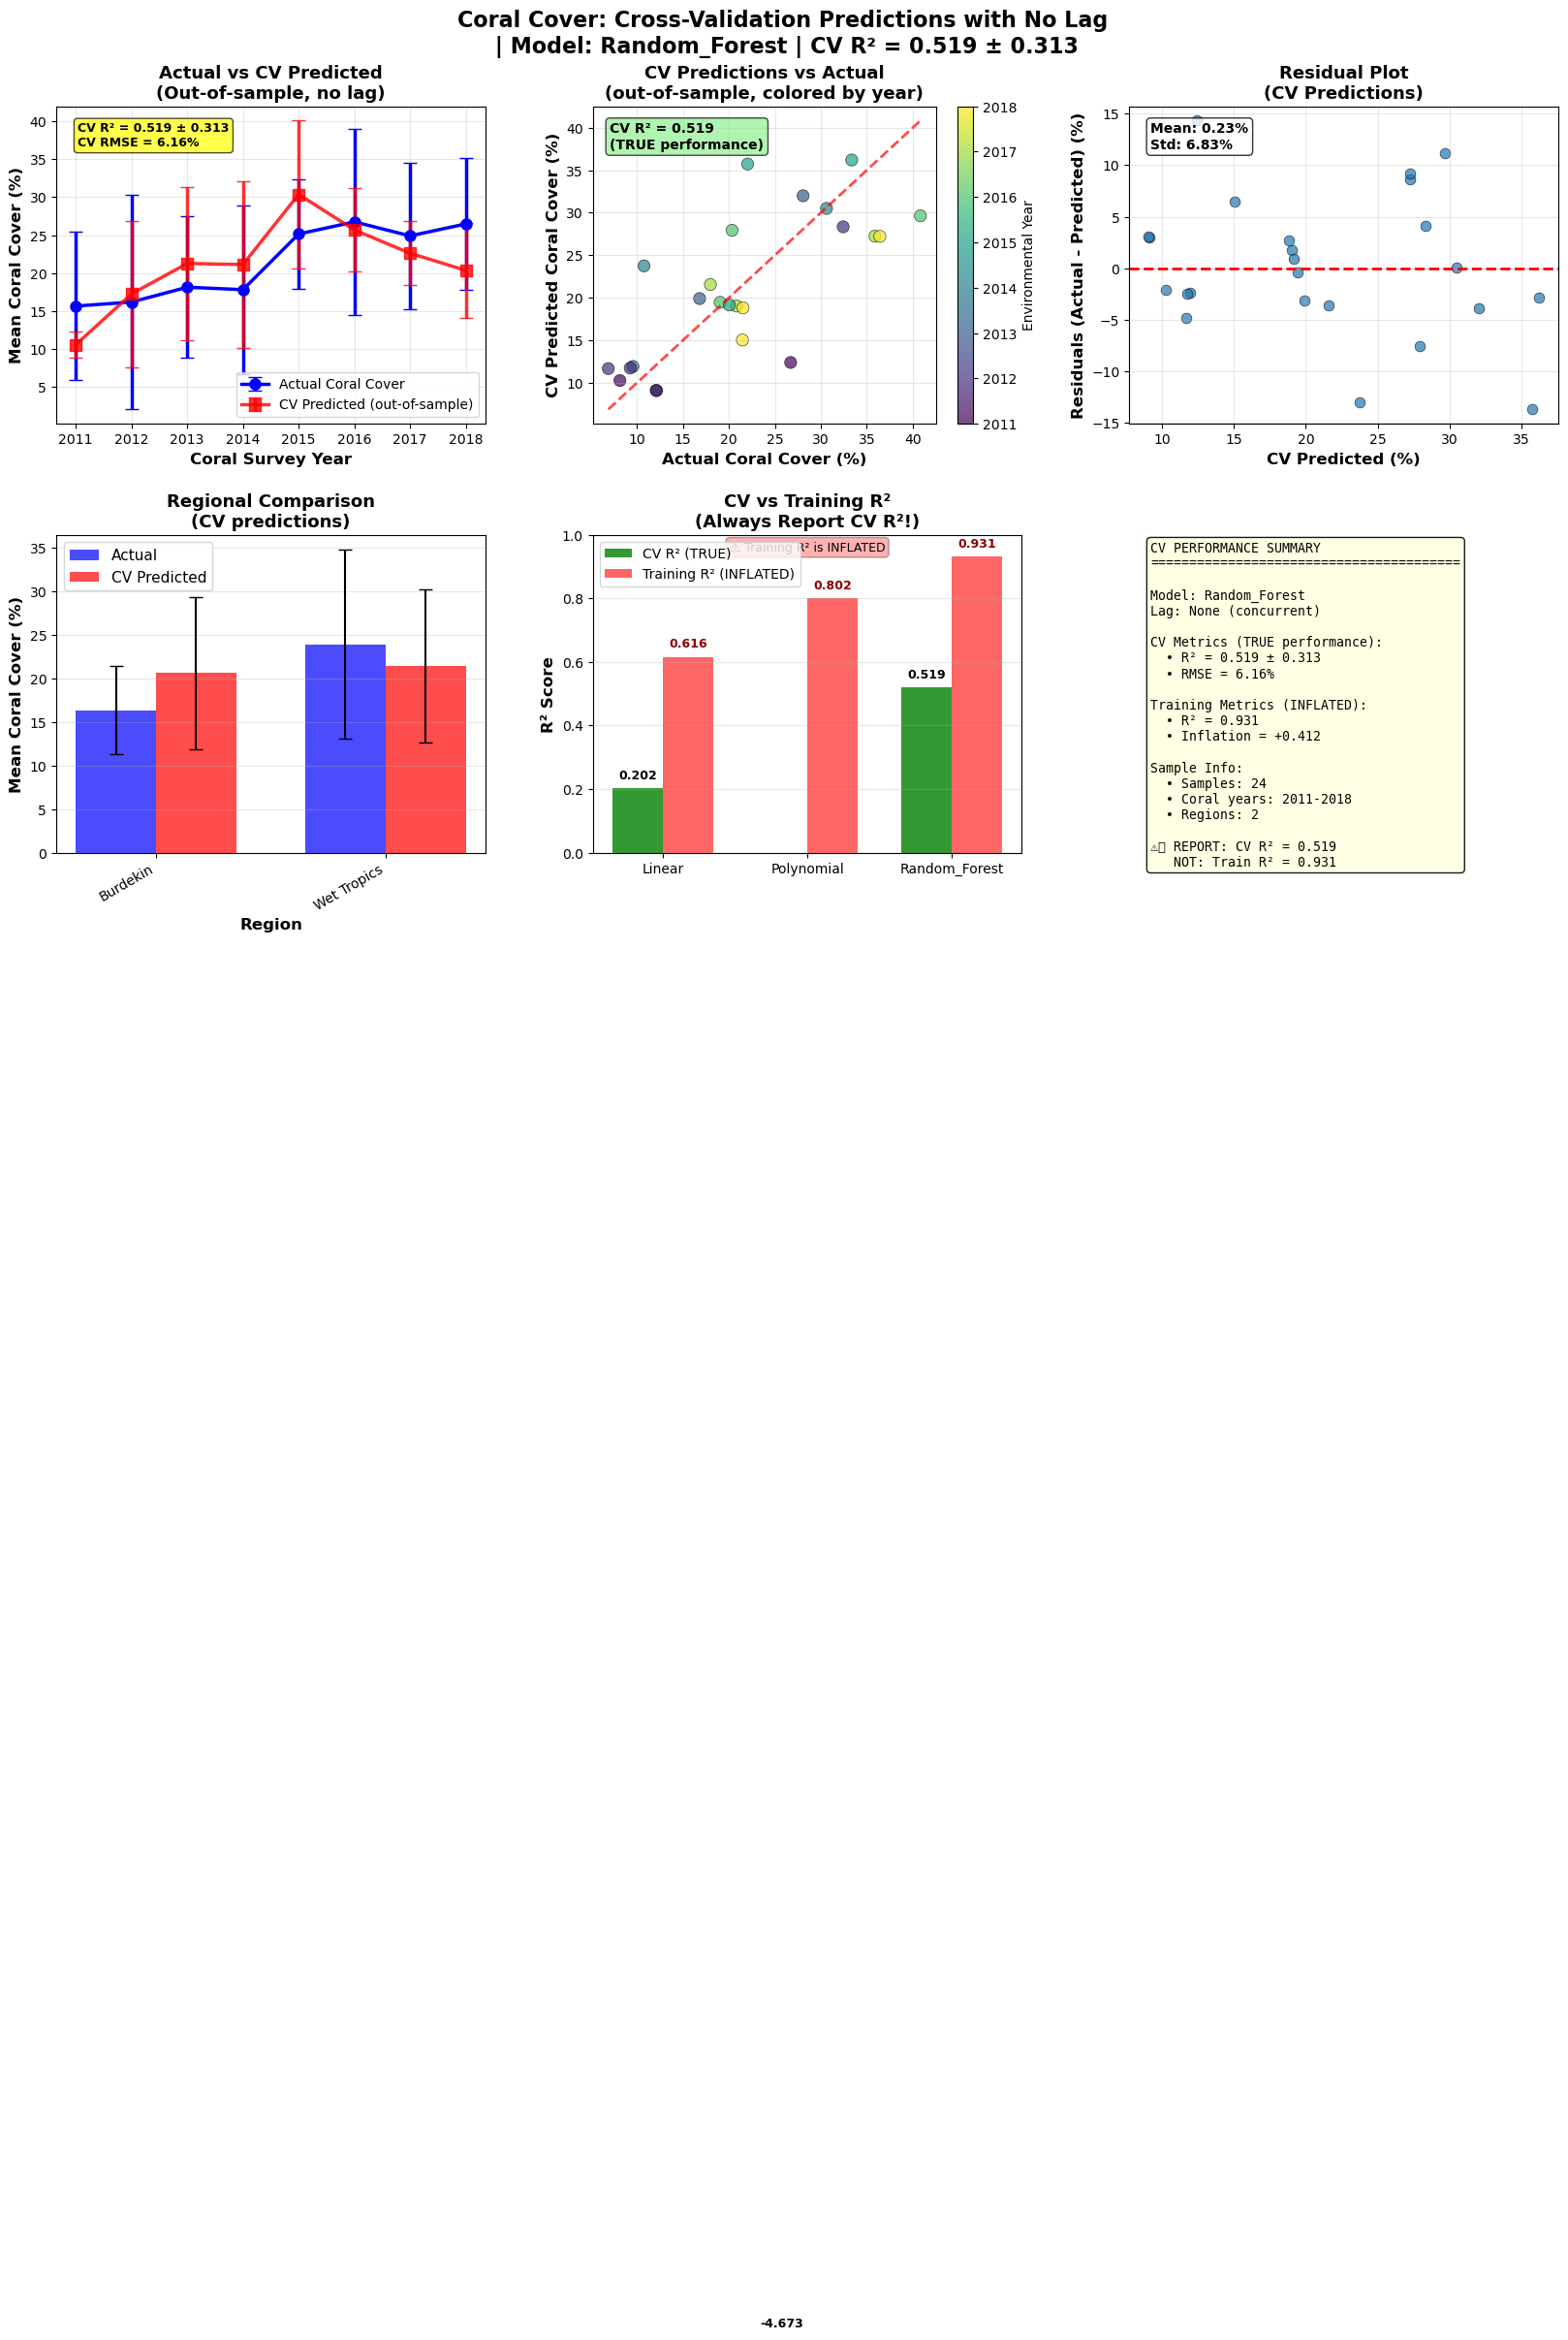

In [40]:
# Use it:
fig_cv, comparison_cv = plot_cv_predicted_vs_actual_timeseries_with_lag(
    results_with_lag, 
    cv_predictions,
    lag_years=lag_year,  # Specify the lag
    save_plot=True,
    output_prefix='coral_cv_predictions'
)

### Chronic vs Acute with Lag

Load Chronic vs Acute Data

In [30]:
# Load data with TWO different aggregation strategies

# 1. Load MEAN aggregated data (for chronic stress analysis)
print("Loading MEAN aggregated data for chronic stress analysis...")
all_data_chronic = {}

variable_agg_chronic = {
    'DIN': 'mean',
    'temp': 'mean', 
    'salt': 'mean'
}

for var_name in variables_to_load:
    agg_method = variable_agg_chronic[var_name]
    
    regional_data, dates, var_dict = load_multiyear_data(
        years_full, months_to_process, var_name, dataset_template, 
        agg_method=agg_method,
        use_cache=True, 
        cache_dir='data_cache'  
    )
    all_data_chronic[var_name] = regional_data
    print(f"  Loaded {var_name} with {agg_method.upper()} aggregation (chronic)")

# 2. Load MAX/MIN aggregated data (for acute stress analysis)
print("\nLoading MAX/MIN aggregated data for acute stress analysis...")
all_data_acute = {}

variable_agg_acute = {
    'DIN': 'max',
    'temp': 'max', 
    'salt': 'min'
}

for var_name in variables_to_load:
    agg_method = variable_agg_acute[var_name]
    
    regional_data, dates, var_dict = load_multiyear_data(
        years_full, months_to_process, var_name, dataset_template, 
        agg_method=agg_method,
        use_cache=True, 
        cache_dir='data_cache'  
    )
    all_data_acute[var_name] = regional_data
    print(f"  Loaded {var_name} with {agg_method.upper()} aggregation (acute)")

Loading MEAN aggregated data for chronic stress analysis...
Loaded data from cache: data_cache/DIN_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmean.pkl
Cache created: 2025-09-27 09:22:55.399334
Depth Index: -1
Aggregation method: mean
  Loaded DIN with MEAN aggregation (chronic)
Loaded data from cache: data_cache/temp_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmean.pkl
Cache created: 2025-09-27 10:44:44.023138
Depth Index: -1
Aggregation method: mean
  Loaded temp with MEAN aggregation (chronic)
Loaded data from cache: data_cache/salt_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmean.pkl
Cache created: 2025-09-27 10:03:09.021463
Depth Index: -1
Aggregation method: mean
  Loaded salt with MEAN aggregation (chronic)

Loading MAX/MIN aggregated data for acute stress analysis...
Loaded data from cache: data_cache/DIN_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
Cache created: 2025-09-29 23:46:23.687716
Depth Index: -1
Aggregation method: max
  Loaded 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

In [32]:
def create_chronic_acute_stress_figure_with_lag(all_data_chronic, all_data_acute, 
                                                 all_dates, coral_csv_file, 
                                                 lag_years=3,
                                                 years_to_analyze=None, catchments=None,
                                                 coral_group='hard coral', save_plot=True, 
                                                 output_prefix='chronic_acute_lag_analysis'):
    """
    Create a comprehensive 4-panel figure showing chronic vs acute environmental stress 
    impacts on coral cover using dual aggregation approaches to distinguish baseline 
    elevation from episodic extreme events.
    
    This function demonstrates the difference between chronic stress (persistent elevation 
    in mean stressor levels causing gradual decline) and acute stress (episodic extreme 
    values causing sudden drops in coral cover). It uses the same data processed with two 
    different aggregation strategies to reveal temporal patterns.

    Coral data from year X+lag is matched with environmental data from year X
    
    Parameters:
    -----------
    all_data_chronic : dict
        Data aggregated with MEAN (daily mean → annual mean)
    all_data_acute : dict
        Data aggregated with MAX/MIN (daily max/min → annual mean)
    all_dates : list
        List of datetime objects corresponding to the time series data in 
        all_regional_data_dict.
    coral_csv_file : str
        Path to coral cover CSV file containing columns: 'YEAR_CODE', 'COVER', 
        'GROUP_CODE', 'NRM_REGION', 'CATCHMENT'.
    lag_years : int, optional
        Number of years of lag between environmental data and coral data. 
        Default is 3 to display lag effect
    years_to_analyze : list, optional
        Specific years to include in analysis. If None, uses all available years with 
        overlapping data. Default is None.
    catchments : list, optional
        List of catchment names to include. If None, uses all available catchments.
        Default is None.
    coral_group : str, optional
        Coral group category to analyze ('hard coral', 'soft coral', 'algae', etc.).
        Default is 'hard coral'.
    save_plot : bool, optional
        Whether to save the figure as PNG file. Default is True.
    output_prefix : str, optional
        Prefix for output filename. Creates '{prefix}_chronic_vs_acute_stress.png'.
        Default is 'chronic_acute_stress_analysis'.
        
    Returns:
    --------
    dict or None
        Dictionary containing analysis results if successful:
        - 'chronic_data': pandas.DataFrame with annual mean values
        - 'acute_data': pandas.DataFrame with annual extreme values  
        - 'years': numpy.ndarray of years analyzed
        - 'figure': matplotlib.figure.Figure object
        Returns None if insufficient data or errors occur.
        
    Notes:
    ------
    **Aggregation Strategy:**
    - Chronic stress: mean values
    - Acute stress: extreme values 
    
    **Data Processing:**
    - Uses prepare_multivariable_coral_data() twice with different aggregation methods
    - Requires uppercase variable keys: 'DIN', 'temp', 'salt' (case-sensitive)
    - Aggregates data by year across all regions for clearer temporal patterns
    - Requires minimum 3 years of overlapping data between chronic and acute datasets
    
    **Visualization Components:**
    Panel A - DIN: Shows chronic elevation (filled area) with acute pulses (arrows)
    Panel B - Temperature: Shows chronic warming with heat stress events
    Panel C - Salinity: Shows chronic freshening with acute freshwater pulses
    Panel D - Coral Cover: Shows gradual trend with acute drop events
    
    **Visual Features:**
    - Smooth curves (gaussian_filter1d) represent chronic baseline conditions
    - Arrows and spikes indicate acute stress events (>75th percentile)
    - Green dashed lines show healthy baselines (25th percentile for DIN/temp, 
      75th percentile for salinity)
    - Red arrows on coral panel indicate major decline events
    - Green triangles indicate potential recovery periods
    
    **Statistical Output:**
    Prints Pearson correlation coefficients for:
    - Chronic stress (mean values) vs coral cover
    - Acute stress (extreme values) vs coral cover
    
    Dependencies:
    -------------
    - numpy (as np) : Array operations and statistics
    - pandas (as pd) : DataFrame operations
    - matplotlib.pyplot (as plt) : Figure creation
    - scipy.stats : Correlation analysis
    - scipy.ndimage.gaussian_filter1d : Curve smoothing
    - prepare_multivariable_coral_data : Custom data preparation function
    
    Raises:
    -------
    Returns None (with error message) if:
    - Data preparation fails for chronic or acute datasets
    - Insufficient overlapping years (< 3 years)
    - Missing required variables in all_regional_data_dict
    """
    
    print(f"=== Chronic vs Acute Stress Analysis ({lag_years}-year lag) ===")
    print(f"Environmental year X → Coral year X+{lag_years}")
    
    # Prepare chronic data WITH LAG
    matched_data_chronic, summary_chronic = prepare_multivariable_coral_data_with_lag(
        all_data_chronic, all_dates, coral_csv_file,
        lag_years=lag_years,  # APPLY LAG
        years_to_analyze=years_to_analyze, 
        catchments=catchments, 
        coral_group=coral_group, 
        aggregation_method='annual',
        variable_aggregation={'DIN': 'mean', 'temp': 'mean', 'salt': 'mean'},
        use_log_din=False
    )
    
    # Prepare acute data WITH LAG
    matched_data_acute, summary_acute = prepare_multivariable_coral_data_with_lag(
        all_data_acute, all_dates, coral_csv_file,
        lag_years=lag_years,  # APPLY LAG
        years_to_analyze=years_to_analyze, 
        catchments=catchments, 
        coral_group=coral_group, 
        aggregation_method='annual',
        variable_aggregation={'DIN': 'mean', 'temp': 'mean', 'salt': 'mean'},
        use_log_din=False
    )
    
    # Aggregate by ENVIRONMENTAL year (since we're looking at predictors)
    chronic_yearly = matched_data_chronic.groupby('env_year').agg({
        'din': 'mean',
        'temp': 'mean', 
        'salt': 'mean',
        'coral_cover': 'mean',
        'year': 'first'  # Coral year for reference
    }).reset_index()
    
    acute_yearly = matched_data_acute.groupby('env_year').agg({
        'din': 'mean',
        'temp': 'mean',
        'salt': 'mean',
        'coral_cover': 'mean',
        'year': 'first'
    }).reset_index()
    
    # Create the figure
    fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)
    fig.suptitle(f'Chronic vs Acute Environmental Stress with {lag_years}-Year Lag\n(Env Year X → Coral Year X+{lag_years})', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Now use ENV_YEAR for x-axis (not coral year)
    env_years = chronic_yearly['env_year'].values
    coral_years = chronic_yearly['year'].values 
    
    # Define healthy baselines (using lowest quartile as reference)
    healthy_din = np.percentile(chronic_yearly['din'], 25)
    healthy_temp = np.percentile(chronic_yearly['temp'], 25)
    healthy_salt = np.percentile(chronic_yearly['salt'], 75)  # Higher salinity is healthier
    
    # 1. DIN Panel
    ax1 = axes[0]
    
    # Chronic stress (baseline elevation)
    chronic_din_smooth = gaussian_filter1d(chronic_yearly['din'].values, sigma=0.8)
    ax1.fill_between(env_years, healthy_din, chronic_din_smooth, 
                     color='orange', alpha=0.6, label='Chronic elevation (MEAN DIN)')
    ax1.plot(env_years, chronic_din_smooth, 'r-', linewidth=2, alpha=0.8)
    
    # Acute stress spikes
    din_range = chronic_yearly['din'].max() - chronic_yearly['din'].min()
    acute_spikes = acute_yearly['din'].values - chronic_yearly['din'].values
    spike_positions = env_years[acute_spikes > np.percentile(acute_spikes, 75)]
    spike_heights = acute_yearly['din'].values[acute_spikes > np.percentile(acute_spikes, 75)]
    
    for i, (pos, height) in enumerate(zip(spike_positions, spike_heights)):
        arrow_length = max(din_range * 3, 10)
        offset = arrow_length * 1.5      # Start arrow away from point
        
        ax1.arrow(pos, height - offset, 0, arrow_length, 
                head_width=0.15, head_length=arrow_length * 0.25, 
                fc='darkblue', ec='darkblue', linewidth=2.5)

        if i == 0:  # Label only first arrow
            ax1.annotate('Acute DIN pulses\n(flood events)', xy=(pos, height + 0.03), 
                        xytext=(pos + 1, height + 0.06),
                        arrowprops=dict(arrowstyle='->', color='darkblue'),
                        fontsize=10, ha='center', color='darkblue', fontweight='bold')
    
    # Plot actual values
    ax1.plot(env_years, acute_yearly['din'], 'b-', linewidth=1.5, alpha=0.7, 
             label='Maximum DIN (acute stress)')
    ax1.scatter(env_years, acute_yearly['din'], c='blue', s=30, alpha=0.7, zorder=5)
    
    # Healthy baseline
    ax1.axhline(y=healthy_din, color='green', linestyle='--', alpha=0.8, 
                label=f'Healthy baseline (~{healthy_din:.2f} mg/m3)')
    
    ax1.set_ylabel('DIN Concentration\n(mg/m3)', fontsize=12, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('A. Nitrogen Stress: Chronic Elevation + Acute Pulses', 
                  fontsize=13, fontweight='bold', pad=10)

    
    
    # 2. Temperature Panel
    ax2 = axes[1]
    
    # Chronic temperature stress
    chronic_temp_smooth = gaussian_filter1d(chronic_yearly['temp'].values, sigma=0.8)
    ax2.fill_between(env_years, healthy_temp, chronic_temp_smooth, 
                     color='red', alpha=0.4, label='Chronic warming (MEAN temp)')
    ax2.plot(env_years, chronic_temp_smooth, 'darkred', linewidth=2, alpha=0.8)
    
    # Acute temperature spikes
    temp_range = chronic_yearly['temp'].max() - chronic_yearly['temp'].min()
    temp_spikes = acute_yearly['temp'].values - chronic_yearly['temp'].values
    temp_spike_positions = env_years[temp_spikes > np.percentile(temp_spikes, 75)]
    temp_spike_heights = acute_yearly['temp'].values[temp_spikes > np.percentile(temp_spikes, 75)]
    
    for i, (pos, height) in enumerate(zip(temp_spike_positions, temp_spike_heights)):
        # Arrow scaled to temperature range
        arrow_length = max(temp_range * 0.4, 0.3)  # At least 0.3°C
        offset = arrow_length * 1.5
        
        ax2.arrow(pos, height + offset, 0, -arrow_length, 
                head_width=0.15, head_length=arrow_length * 0.25, 
                fc='crimson', ec='crimson', linewidth=2.5)

        if i == 0 and len(temp_spike_positions) > 0:
            ax2.annotate('Heat stress events', xy=(pos, height + 0.05), 
                        xytext=(pos + 1, height + 0.3),
                        arrowprops=dict(arrowstyle='->', color='crimson'),
                        fontsize=10, ha='center', color='crimson', fontweight='bold')
    
    ax2.plot(env_years, acute_yearly['temp'], 'crimson', linewidth=1.5, alpha=0.7, 
             label='Maximum temperature')
    ax2.scatter(env_years, acute_yearly['temp'], c='crimson', s=30, alpha=0.7, zorder=5)
    
    ax2.axhline(y=healthy_temp, color='green', linestyle='--', alpha=0.8, 
                label=f'Healthy baseline (~{healthy_temp:.1f}°C)')
    
    ax2.set_ylabel('Temperature\n(°C)', fontsize=12, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('B. Thermal Stress: Chronic Warming + Heat Events', 
                  fontsize=13, fontweight='bold', pad=10)
    
    # 3. Salinity Panel (inverted - lower is more stressful)
    ax3 = axes[2]
    
    # Chronic salinity depression
    chronic_salt_smooth = gaussian_filter1d(chronic_yearly['salt'].values, sigma=0.8)
    ax3.fill_between(env_years, chronic_salt_smooth, healthy_salt, 
                     color='lightblue', alpha=0.6, label='Chronic freshening (MEAN salinity)')
    ax3.plot(env_years, chronic_salt_smooth, 'blue', linewidth=2, alpha=0.8)
    
    # Acute salinity drops
    salt_range = chronic_yearly['salt'].max() - chronic_yearly['salt'].min()
    salt_drops = chronic_yearly['salt'].values - acute_yearly['salt'].values  # Positive means bigger drop
    drop_positions = env_years[salt_drops > np.percentile(salt_drops, 75)]
    drop_heights = acute_yearly['salt'].values[salt_drops > np.percentile(salt_drops, 75)]
    
    for i, (pos, height) in enumerate(zip(drop_positions, drop_heights)):
        # Arrow scaled to salinity range 
        arrow_length = max(salt_range * 0.4, 1.0)  # At least 1 PSU
        offset = arrow_length * 1.5
        
        # UPWARD arrow - start below, point up
        ax3.arrow(pos, height + offset, 0, -arrow_length, 
                head_width=0.15, head_length=arrow_length * 0.25, 
                fc='navy', ec='navy', linewidth=2.5)


        if i == 0 and len(drop_positions) > 0:
            ax3.annotate('Freshwater pulses\n(flood/runoff)', xy=(pos, height - 0.25), 
                        xytext=(pos + 1, height - 0.6),
                        arrowprops=dict(arrowstyle='->', color='navy'),
                        fontsize=10, ha='center', color='navy', fontweight='bold')
    
    ax3.plot(env_years, acute_yearly['salt'], 'navy', linewidth=1.5, alpha=0.7, 
             label='Minimum salinity (acute stress)')
    ax3.scatter(env_years, acute_yearly['salt'], c='navy', s=30, alpha=0.7, zorder=5)
    
    ax3.axhline(y=healthy_salt, color='green', linestyle='--', alpha=0.8, 
                label=f'Healthy baseline (~{healthy_salt:.1f} PSU)')
    
    ax3.set_ylabel('Salinity\n(PSU)', fontsize=12, fontweight='bold')
    ax3.legend(loc='lower right', fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.set_title('C. Salinity Stress: Chronic Freshening + Acute Pulses', 
                  fontsize=13, fontweight='bold', pad=10)
    
    # 4. Coral Cover Response
    ax4 = axes[3]
    
    coral_data = chronic_yearly['coral_cover'].values  # Use chronic data coral cover
    
    # Smooth long-term trend
    if len(env_years) > 3:
        z = np.polyfit(env_years, coral_data, 2)  # Quadratic trend
        trend_line = np.poly1d(z)
        ax4.plot(env_years, trend_line(env_years), 'darkgreen', linewidth=3, alpha=0.8, 
                 label='Long-term trend')
    
    # Actual coral cover with step-drops after major disturbances
    ax4.plot(env_years, coral_data, 'forestgreen', linewidth=2, marker='o', markersize=6, 
             label='Observed coral cover', markerfacecolor='lightgreen', markeredgecolor='darkgreen')
    
    # Identify major drops (year-over-year decline > threshold)
    coral_changes = np.diff(coral_data)
    major_drops = env_years[1:][coral_changes < -np.std(coral_changes)]
    
    for drop_year in major_drops:
        drop_idx = np.where(env_years == drop_year)[0][0]
        prev_idx = drop_idx - 1
        
        # Add drop annotation
        ax4.annotate('', xy=(env_years[drop_idx], coral_data[drop_idx]), 
                    xytext=(env_years[prev_idx], coral_data[prev_idx]),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2))
        
        # Check if this corresponds to acute stress events
        if drop_year in spike_positions or drop_year in drop_positions:
            ax4.annotate(f'Acute stress\nimpact', 
                        xy=(env_years[drop_idx], coral_data[drop_idx]),
                        xytext=(env_years[drop_idx] + 0.5, coral_data[drop_idx] - 2),
                        arrowprops=dict(arrowstyle='->', color='red'),
                        fontsize=9, color='red', fontweight='bold', ha='center')
    
    # Recovery periods (small increases)
    recovery_years = env_years[1:][coral_changes > 0]
    for rec_year in recovery_years:
        rec_idx = np.where(env_years == rec_year)[0][0]
        ax4.scatter(rec_year, coral_data[rec_idx], c='lightgreen', s=50, 
                   marker='^', edgecolor='darkgreen', linewidth=1, zorder=6)
    
    ax4.set_ylabel('Coral Cover\n(%)', fontsize=12, fontweight='bold')
    ax4.set_xlabel(f'Environmental Year (Coral response measured {lag_years} years later)', 
               fontsize=12, fontweight='bold')
    ax4.legend(loc='lower right', fontsize=9)
    ax4.grid(True, alpha=0.3)
    ax4.set_title('D. Coral Cover Response', 
                  fontsize=13, fontweight='bold', pad=10)
    
    # Add recovery markers to legend
    ax4.scatter([], [], c='lightgreen', s=50, marker='^', edgecolor='darkgreen', 
               linewidth=1, label='Potential recovery periods')
    ax4.legend(loc='lower right', fontsize=9)
    
    
    ax4.set_xlabel(f'Environmental Year (Coral measured {lag_years} years later)', fontsize=12, fontweight='bold')
    
    # Add lag explanation
    fig.text(0.5, -0.01, 
             f'Note: Coral cover shown for year X+{lag_years} in response to environmental conditions from year X',
             ha='center', fontsize=10, style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(f'{output_prefix}_{lag_years}year_lag_chronic_vs_acute.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return {
        'chronic_data': chronic_yearly,
        'acute_data': acute_yearly,
        'env_years': chronic_yearly['env_year'].values,
        'coral_years': chronic_yearly['year'].values,
        'lag_years': lag_years,
        'figure': fig
    }



=== Chronic vs Acute Stress Analysis (0-year lag) ===
Environmental year X → Coral year X+0


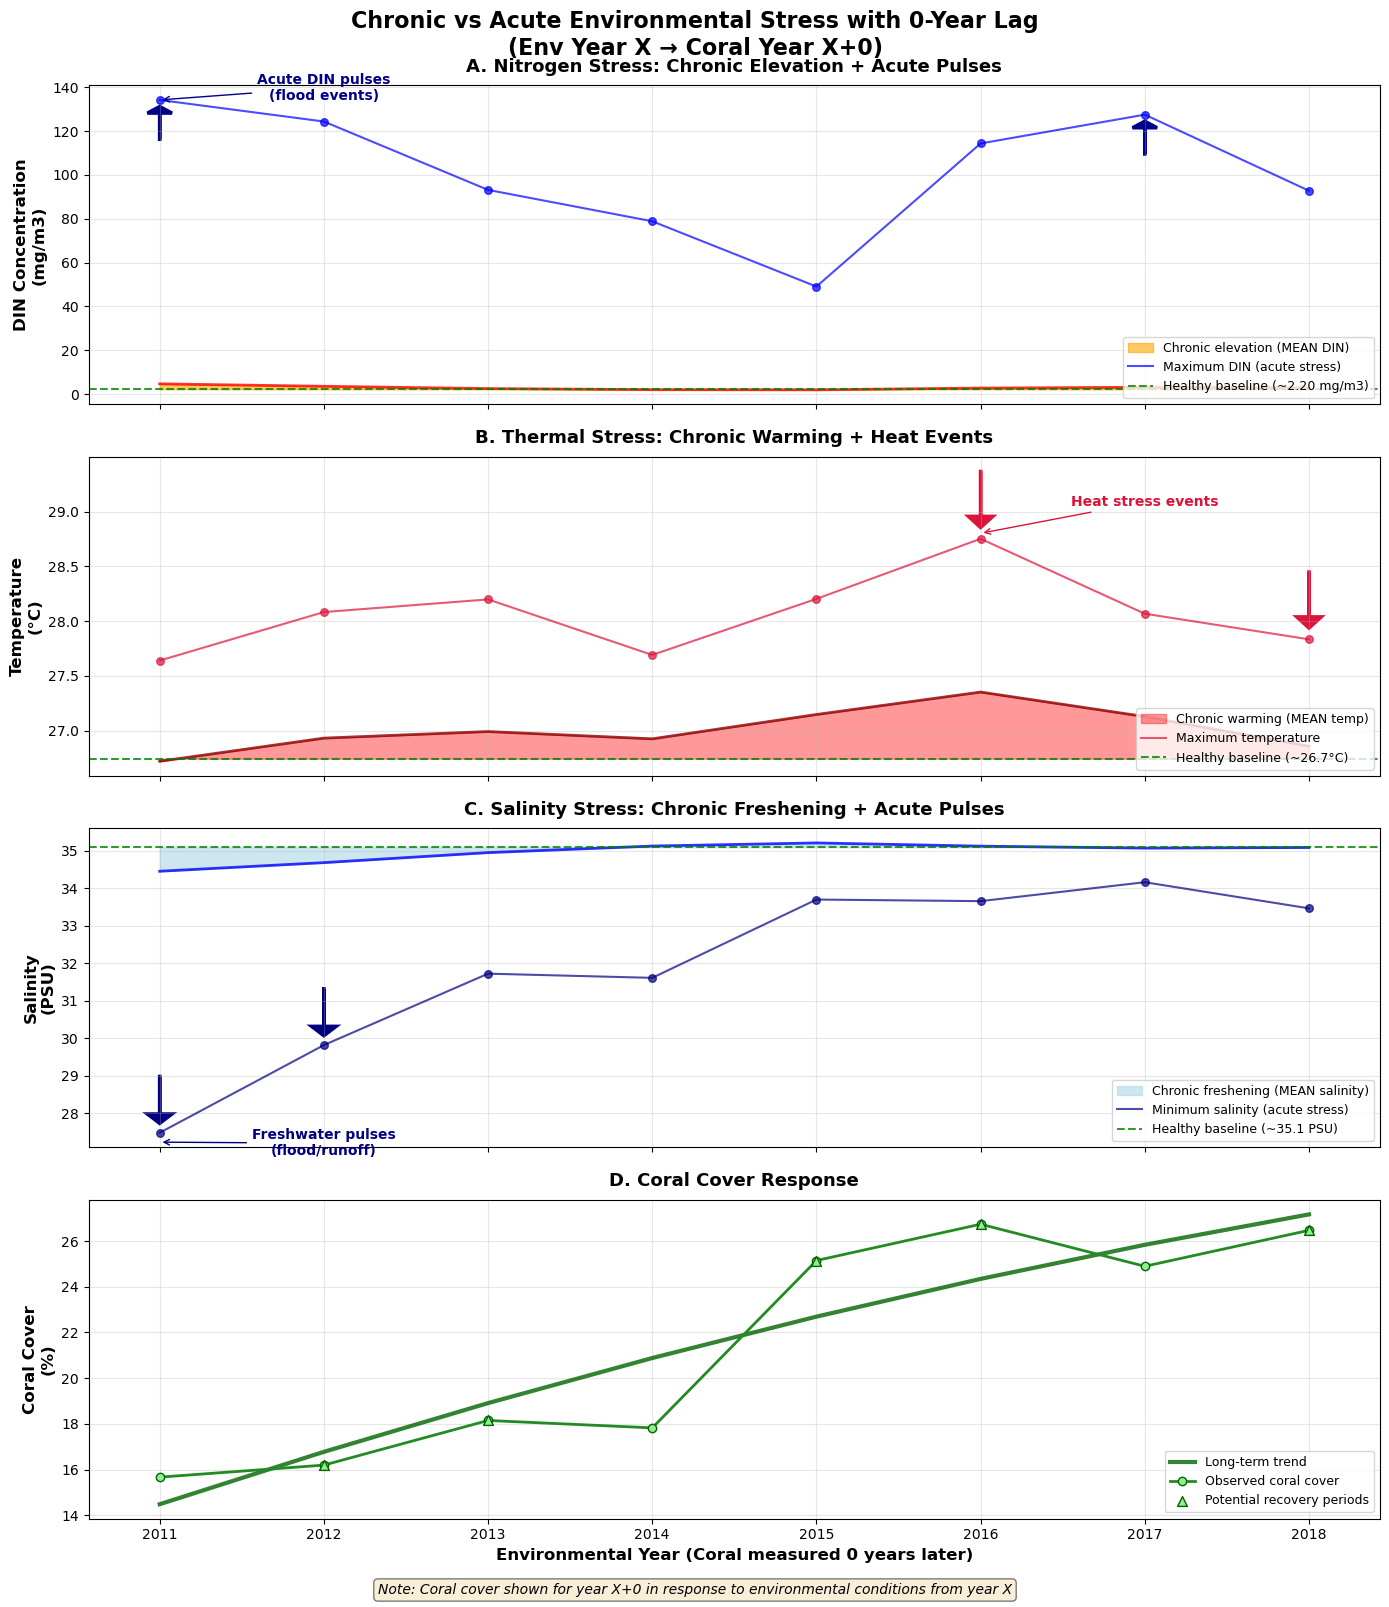

In [33]:
# Run with lag:
chronic_acute_lag_results = create_chronic_acute_stress_figure_with_lag(
    all_data_chronic,
    all_data_acute,
    all_dates, 
    'coraldata.csv',
    lag_years=lag_year  # USE Variable LAG
)

## Export MV model for prediction

In [33]:
def export_coral_model(results_package, model_name=None, output_prefix='coral_model'):
    """
    Export the trained model and associated data for use on new datasets
    
    Parameters:
    -----------
    results_package : dict
        Output from analyze_multivariable_coral_relationship
    model_name : str, optional
        Specific model to export. If None, uses best model
    output_prefix : str
        Prefix for exported files
        
    Returns:
    --------
    model_package : dict
        Complete model package for application to new data
    """
    
    # Get model information
    models = results_package['models']
    model_results = results_package['model_results']
    feature_importance = results_package['feature_importance']
    
    # Use best model if not specified
    if model_name is None:
        model_name = results_package['best_model']
    
    print(f"Exporting {model_name} model...")
    
    # Prepare model package
    model_package = {
        'model_name': model_name,
        'model_object': models[model_name],
        'available_variables': models['available_vars'],
        'feature_names': models.get('feature_names', models['available_vars']),
        'model_performance': model_results[model_name],
        'export_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'training_data_summary': results_package['data_summary'],
        'statistical_analysis': results_package.get('individual_variable_stats', {}),
        'preprocessing_info': {}
    }
    
    # Add preprocessing information based on model type
    if model_name == 'polynomial':
        model_package['scaler'] = models['scaler']
        model_package['preprocessing_info'] = {
            'requires_scaling': True,
            'extended_features': True,
            'feature_engineering': 'log_transforms, squared_terms, interactions'
        }
    elif model_name == 'linear':
        model_package['preprocessing_info'] = {
            'requires_scaling': False,
            'extended_features': False,
            'coefficients': dict(zip(models['available_vars'], models[model_name].coef_)),
            'intercept': models[model_name].intercept_
        }
    elif model_name == 'random_forest':
        if model_name in feature_importance:
            model_package['feature_importance'] = feature_importance[model_name]
        model_package['preprocessing_info'] = {
            'requires_scaling': False,
            'extended_features': False,
            'tree_based': True
        }
    
    # Save model using both pickle and joblib for compatibility
    try:
        # Save with joblib (recommended for scikit-learn models)
        joblib.dump(model_package, f'{output_prefix}_{model_name}_model.joblib')
        print(f"Model saved as: {output_prefix}_{model_name}_model.joblib")
        
        # Save with pickle as backup
        with open(f'{output_prefix}_{model_name}_model.pkl', 'wb') as f:
            pickle.dump(model_package, f)
        print(f"Model saved as: {output_prefix}_{model_name}_model.pkl")
        
    except Exception as e:
        print(f"Error saving model: {e}")
        return None

    # Create model application instructions
    instructions = f"""
Model Application Instructions
=============================

Model: {model_name}
Export Date: {model_package['export_date']}
Performance: R² = {model_results[model_name]['cv_r2_mean']:.3f}, RMSE = {model_results[model_name]['cv_rmse_mean']:.2f}%

Required Variables:
{', '.join([f"- {var.upper()}" for var in models['available_vars']])}

Variable Units and Ranges (from training data):
"""
    
    for var in models['available_vars']:
        var_range = results_package['data_summary']['variable_ranges'].get(var, (None, None))
        unit = "(mg/m3)" if var == "din" else "(°C)" if var == "temp" else "(PSU)" if var == "salt" else ""
        if var_range[0] is not None:
            instructions += f"- {var.upper()}: {var_range[0]:.3f} - {var_range[1]:.3f} {unit}\n"
    
    instructions += f"""
Usage Example:
--------------
import joblib
import numpy as np

# Load the model
model_package = joblib.load('{output_prefix}_{model_name}_model.joblib')

# Prepare data
new_data = np.array([[din_value, temp_value, salt_value]])  # Adjust based on available variables

# Make predictions
predictions = apply_coral_model_to_new_data(model_package, new_data)

Notes:
------
- Ensure data uses the same units as training data
- Check that variable ranges are within reasonable bounds of training data
- Model was trained on data from: {min(results_package['data_summary']['env_years_covered'])} - {max(results_package['data_summary']['env_years_covered'])}
- Training regions: {', '.join(results_package['data_summary']['regions_included'])}
"""
    
    # Save instructions
    with open(f'{output_prefix}_{model_name}_instructions.txt', 'w') as f:
        f.write(instructions)
    
    print(f"Instructions saved as: {output_prefix}_{model_name}_instructions.txt")
    
    return model_package

In [34]:
# Export the best model
# Save model with lag metadata
print("\n=== Exporting Model with Lag Information ===")
model_package_lag = export_coral_model(
    results_with_lag, 
    model_name=None,  # Uses best model
    output_prefix=f'coral_model_{lag_year}year_lag'
)

# Add lag information to model package
model_package_lag['lag_years'] = lag_year
model_package_lag['lag_interpretation'] = f"Environmental conditions from year X predict coral cover in year X+{lag_year}"

# Save with updated metadata
joblib.dump(model_package_lag, f'coral_model_{lag_year}year_lag.joblib')
print(f"Model with {lag_year}-year lag saved!")
# model_package = export_coral_model(results, output_prefix='my_coral_model')


=== Exporting Model with Lag Information ===
Exporting random_forest model...
Model saved as: coral_model_0year_lag_random_forest_model.joblib
Model saved as: coral_model_0year_lag_random_forest_model.pkl
Instructions saved as: coral_model_0year_lag_random_forest_instructions.txt
Model with 0-year lag saved!


## Apply MV model to new data

In [35]:
def prepare_model_input_data(regional_data_dict, variable_order=['din', 'temp', 'salt']):
    """
    Convert regional data dictionary to model input format
    
    Parameters:
    -----------
    regional_data_dict : dict
        Dictionary with variable names as keys, each containing regional time series data
        Format: {'DIN': {region1: data1, region2: data2, ...}, 'temp': {...}, 'salt': {...}}
    variable_order : list
        Order of variables expected by the model
        
    Returns:
    --------
    np.array
        2D array with shape (n_samples, n_variables) ready for model input
    """
    
    # Get all data for the first variable to determine structure
    first_var = list(regional_data_dict.keys())[0]
    first_var_data = regional_data_dict[first_var]
    
    # Combine all regional data for all time points
    all_samples = []
    
    # Get region names and determine data length
    region_names = list(first_var_data.keys())
    
    # For each region, collect data across all time points
    for region_name in region_names:
        region_data = []
        
        # Get time series length from first variable
        time_series_length = len(first_var_data[region_name])
        
        # For each time point, collect all variables
        for t in range(time_series_length):
            sample = []
            
            for var_name in variable_order:
                # Map variable names (handle case differences)
                var_key = var_name.upper() if var_name.upper() in regional_data_dict else var_name.lower()
                if var_key not in regional_data_dict:
                    # Try exact match
                    var_key = var_name
                
                if var_key in regional_data_dict and region_name in regional_data_dict[var_key]:
                    if t < len(regional_data_dict[var_key][region_name]):
                        sample.append(regional_data_dict[var_key][region_name][t])
                    else:
                        sample.append(np.nan)  # Handle missing data
                else:
                    sample.append(np.nan)
            
            if len(sample) == len(variable_order):
                all_samples.append(sample)
    
    # Convert to numpy array and remove any rows with NaN values
    data_array = np.array(all_samples)
    
    # Remove NaN rows
    valid_rows = ~np.isnan(data_array).any(axis=1)
    clean_data = data_array[valid_rows]
    
    print(f"Prepared model input data: {clean_data.shape[0]} samples with {clean_data.shape[1]} variables")
    print(f"Variables in order: {variable_order}")
    
    return clean_data

In [36]:
def apply_coral_model_to_new_data(model_package, new_data, data_description="New Dataset"):
    """
    Apply the exported coral model to new eReefs data
    
    Parameters:
    -----------
    model_package : dict
        Exported model package from export_coral_model
    new_data : np.array or pd.DataFrame
        New data with same variables as training data
        Shape: (n_samples, n_features)
    data_description : str
        Description of the new dataset for output
        
    Returns:
    --------
    predictions : dict
        Dictionary containing predictions and metadata
    """
    
    model_name = model_package['model_name']
    model = model_package['model_object']
    available_vars = model_package['available_variables']
    
    print(f"Applying {model_name} model to {data_description}")
    print(f"Expected variables: {available_vars}")
    
    # Debug information
    print(f"Debug - Type of new_data: {type(new_data)}")
    print(f"Debug - Is dict? {isinstance(new_data, dict)}")
    
    # Handle different input data types
    X_new = None
    
    if isinstance(new_data, dict):
        # This means we got regional data dict - need to convert it first
        print("Processing dictionary data - converting to model input format")
        X_new = prepare_model_input_data(new_data, available_vars)
        
    elif hasattr(new_data, 'values'):
        # Pandas DataFrame or Series
        if hasattr(new_data, 'columns'):
            X_new = new_data[available_vars].values
        else:
            X_new = new_data.values
            
    elif isinstance(new_data, (list, tuple)):
        X_new = np.array(new_data)
        
    elif isinstance(new_data, np.ndarray):
        X_new = new_data
        
    else:
        print(f"Attempting to convert {type(new_data)} to numpy array...")
        try:
            X_new = np.array(new_data)
        except Exception as e:
            raise ValueError(f"Cannot convert input data of type {type(new_data)} to numpy array: {e}")
    
    # Validate that we got a proper array
    if X_new is None or not isinstance(X_new, np.ndarray):
        raise ValueError(f"Failed to convert input data to numpy array. Got: {type(X_new)}")
    
    # Ensure X_new is 2D
    if len(X_new.shape) == 1:
        X_new = X_new.reshape(1, -1)
    
    print(f"Input data shape: {X_new.shape}")
    print(f"Expected features: {len(available_vars)}")
    
    # Validate input dimensions
    if X_new.shape[1] != len(available_vars):
        raise ValueError(f"Input data has {X_new.shape[1]} features, but model expects {len(available_vars)}")
    
    # Check for reasonable ranges
    training_ranges = model_package['training_data_summary']['variable_ranges']
    for i, var in enumerate(available_vars):
        if var in training_ranges:
            var_min, var_max = training_ranges[var]
            data_min, data_max = X_new[:, i].min(), X_new[:, i].max()
            
            if data_min < var_min * 0.5 or data_max > var_max * 2:
                print(f"Warning: {var.upper()} values ({data_min:.3f} - {data_max:.3f}) are outside training range ({var_min:.3f} - {var_max:.3f})")
    
    # Make predictions based on model type
    if model_name == 'linear':
        predictions = model.predict(X_new)
        
    elif model_name == 'polynomial':
        # Apply same feature engineering as training
        X_extended = X_new.copy()
        
        # Add log transformations
        for i, var in enumerate(available_vars):
            if var == 'din':
                log_vals = np.log(X_new[:, i] + 0.001)
            else:
                log_vals = np.log(np.maximum(X_new[:, i], 0.001))
            X_extended = np.column_stack([X_extended, log_vals])
        
        # Add squared terms
        for i in range(len(available_vars)):
            X_extended = np.column_stack([X_extended, X_new[:, i] ** 2])
        
        # Add interaction terms
        if len(available_vars) > 1:
            for i in range(len(available_vars)):
                for j in range(i + 1, len(available_vars)):
                    interaction = X_new[:, i] * X_new[:, j]
                    X_extended = np.column_stack([X_extended, interaction])
        
        # Scale features
        X_scaled = model_package['scaler'].transform(X_extended)
        predictions = model.predict(X_scaled)
        
    elif model_name == 'random_forest':
        predictions = model.predict(X_new)
        
    else:
        # Single variable model
        var_name = model_name.replace('_only', '')
        var_idx = available_vars.index(var_name)
        predictions = model.predict(X_new[:, var_idx].reshape(-1, 1))
    
    # Calculate summary statistics
    pred_mean = np.mean(predictions)
    pred_std = np.std(predictions)
    pred_min, pred_max = np.min(predictions), np.max(predictions)
    
    # Create results dictionary
    results = {
        'predictions': predictions,
        'model_used': model_name,
        'input_shape': X_new.shape,
        'prediction_summary': {
            'mean': pred_mean,
            'std': pred_std,
            'min': pred_min,
            'max': pred_max,
            'n_samples': len(predictions)
        },
        'model_performance': model_package['model_performance'],
        'data_description': data_description
    }
    
    print(f"\nPrediction Results:")
    print(f"- Number of predictions: {len(predictions)}")
    print(f"- Mean predicted coral cover: {pred_mean:.1f}%")
    print(f"- Standard deviation: {pred_std:.1f}%")
    print(f"- Range: {pred_min:.1f}% - {pred_max:.1f}%")
    print(f"- Model R² (from training): {model_package['model_performance']['cv_r2_mean']:.3f}")
    
    return results

In [37]:
def aggregate_scenario_data_for_prediction(regional_data_dict, all_dates, 
                                          aggregation_method='annual',
                                          variable_aggregation=None):
    """
    Aggregate scenario data in the same way as training data was aggregated
    This ensures predictions are made on comparable aggregated values
    
    Parameters:
    -----------
    regional_data_dict : dict
        Dictionary with variable names as keys (e.g., 'DIN', 'temp', 'salt')
    all_dates : list
        Datetime objects corresponding to the data
    aggregation_method : str
        'annual', 'seasonal', or 'monthly'
    variable_aggregation : dict
        Dictionary specifying aggregation method for each variable
        e.g., {'DIN': 'max', 'temp': 'max', 'salt': 'mean'}
        
    Returns:
    --------
    aggregated_array : np.array
        Array of aggregated values ready for model input
        Shape: (n_time_periods * n_regions, n_variables)
    metadata : dict
        Information about the aggregation
    """
    
    # Set defaults
    if variable_aggregation is None:
        variable_aggregation = {}
    
    expected_vars = ['DIN', 'temp', 'salt']
    for var in expected_vars:
        if var not in variable_aggregation:
            variable_aggregation[var] = 'mean'
    
    print("\n=== Aggregating Scenario Data ===")
    print(f"Temporal aggregation: {aggregation_method}")
    print(f"Variable-specific aggregation:")
    for var, method in variable_aggregation.items():
        if var in regional_data_dict:
            print(f"  - {var}: {method.upper()}")
    
    # Convert dates to DataFrame
    dates_df = pd.DataFrame({
        'datetime': all_dates,
        'year': [d.year for d in all_dates],
        'month': [d.month for d in all_dates]
    })
    
    # Aggregate each variable by region
    aggregated_data = {}
    
    for var_name in expected_vars:
        if var_name not in regional_data_dict:
            print(f"Warning: {var_name} not found in data")
            continue
        
        aggregated_data[var_name] = {}
        agg_method = variable_aggregation.get(var_name, 'mean')
        
        for region_name, timeseries in regional_data_dict[var_name].items():
            if len(timeseries) == 0:
                continue
            
            # Create DataFrame for this region's data
            temp_df = pd.DataFrame({
                'datetime': all_dates[:len(timeseries)],
                'year': [d.year for d in all_dates[:len(timeseries)]],
                'month': [d.month for d in all_dates[:len(timeseries)]],
                f'{var_name.lower()}': timeseries
            })
            
            # Remove NaN
            temp_df = temp_df.dropna(subset=[f'{var_name.lower()}'])
            
            # Apply aggregation based on method
            if aggregation_method == 'annual':
                if agg_method == 'max':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].max().reset_index()
                elif agg_method == 'min':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].min().reset_index()
                elif agg_method == 'median':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].median().reset_index()
                elif agg_method == 'std':
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].std().reset_index()
                else:  # mean
                    region_agg = temp_df.groupby('year')[f'{var_name.lower()}'].mean().reset_index()
            
            elif aggregation_method == 'seasonal':
                temp_df['season'] = temp_df['month'].apply(
                    lambda x: 'wet' if x in [11, 12, 1, 2, 3, 4] else 'dry'
                )
                if agg_method == 'max':
                    region_agg = temp_df.groupby(['year', 'season'])[f'{var_name.lower()}'].max().reset_index()
                elif agg_method == 'min':
                    region_agg = temp_df.groupby(['year', 'season'])[f'{var_name.lower()}'].min().reset_index()
                elif agg_method == 'median':
                    region_agg = temp_df.groupby(['year', 'season'])[f'{var_name.lower()}'].median().reset_index()
                elif agg_method == 'std':
                    region_agg = temp_df.groupby(['year', 'season'])[f'{var_name.lower()}'].std().reset_index()
                else:  # mean
                    region_agg = temp_df.groupby(['year', 'season'])[f'{var_name.lower()}'].mean().reset_index()
            
            else:  # monthly
                if agg_method == 'max':
                    region_agg = temp_df.groupby(['year', 'month'])[f'{var_name.lower()}'].max().reset_index()
                elif agg_method == 'min':
                    region_agg = temp_df.groupby(['year', 'month'])[f'{var_name.lower()}'].min().reset_index()
                elif agg_method == 'median':
                    region_agg = temp_df.groupby(['year', 'month'])[f'{var_name.lower()}'].median().reset_index()
                elif agg_method == 'std':
                    region_agg = temp_df.groupby(['year', 'month'])[f'{var_name.lower()}'].std().reset_index()
                else:  # mean
                    region_agg = temp_df.groupby(['year', 'month'])[f'{var_name.lower()}'].mean().reset_index()
            
            aggregated_data[var_name][region_name] = region_agg
    
    # Now combine into a single array
    # Get all regions from first variable
    reference_var = 'DIN' if 'DIN' in aggregated_data else list(aggregated_data.keys())[0]
    regions = list(aggregated_data[reference_var].keys())
    
    all_samples = []
    sample_metadata = []
    
    for region_name in regions:
        # Get common years/periods across all variables for this region
        year_sets = []
        for var_name in expected_vars:
            if var_name in aggregated_data and region_name in aggregated_data[var_name]:
                year_sets.append(set(aggregated_data[var_name][region_name]['year'].values))
        
        if not year_sets:
            continue
        
        common_years = set.intersection(*year_sets)
        
        for year in sorted(common_years):
            sample = []
            valid = True
            
            for var_name in expected_vars:
                if var_name in aggregated_data and region_name in aggregated_data[var_name]:
                    var_data = aggregated_data[var_name][region_name]
                    year_data = var_data[var_data['year'] == year]
                    
                    if len(year_data) > 0:
                        sample.append(year_data.iloc[0][var_name.lower()])
                    else:
                        valid = False
                        break
                else:
                    valid = False
                    break
            
            if valid and len(sample) == len(expected_vars):
                all_samples.append(sample)
                sample_metadata.append({
                    'region': region_name,
                    'year': year
                })
    
    # Convert to numpy array
    aggregated_array = np.array(all_samples)
    
    print(f"\nAggregated data shape: {aggregated_array.shape}")
    print(f"Number of aggregated samples: {aggregated_array.shape[0]}")
    print(f"Number of variables: {aggregated_array.shape[1]}")
    
    print(f"\nAggregated value ranges:")
    for i, var in enumerate(expected_vars):
        if var in regional_data_dict:
            method = variable_aggregation.get(var, 'mean').upper()
            print(f"  {var} ({method}): min={aggregated_array[:, i].min():.4f}, "
                  f"max={aggregated_array[:, i].max():.4f}, "
                  f"mean={aggregated_array[:, i].mean():.4f}")
    
    metadata = {
        'n_samples': aggregated_array.shape[0],
        'n_regions': len(regions),
        'regions': regions,
        'years': sorted(list(set([m['year'] for m in sample_metadata]))),
        'aggregation_method': aggregation_method,
        'variable_aggregation': variable_aggregation,
        'sample_metadata': sample_metadata
    }
    
    return aggregated_array, metadata

In [38]:
def aggregate_scenario_data_for_prediction_with_lag(regional_data_dict, all_dates, 
                                                     lag_years=3,
                                                     aggregation_method='annual',
                                                     variable_aggregation=None):
    """
    Aggregate scenario data WITH LAG for prediction
    
    Key: Returns data for environmental years that would predict coral {lag_years} years later
    """
    
    # Same aggregation as before
    aggregated_array, metadata = aggregate_scenario_data_for_prediction(
        regional_data_dict, all_dates, aggregation_method, variable_aggregation
    )
    
    # Add lag metadata
    metadata['lag_years'] = lag_years
    metadata['interpretation'] = f"These environmental conditions predict coral cover {lag_years} years in the future"
    
    # Adjust year labels for clarity
    metadata['prediction_years'] = [y + lag_years for y in metadata['years']]
    
    print(f"\nLag-adjusted aggregation:")
    print(f"- Environmental years: {metadata['years']}")
    print(f"- Predicted coral years: {metadata['prediction_years']}")
    
    return aggregated_array, metadata

In [39]:
def compare_scenarios_with_aggregation_and_lag(baseline_data, scenario_data, model_package,
                                                all_dates, lag_years=3,
                                                scenario_name="Reef 2050 Goals",
                                                aggregation_method='annual',
                                                variable_aggregation=None,
                                                save_outputs=True,
                                                output_prefix="reef2050_lag_projection"):
    """
    Compare scenarios WITH LAG consideration
    
    Critical: Model predictions represent coral cover {lag_years} years after environmental conditions
    """
    
    print(f"\n=== {scenario_name} Impact Projection ({lag_years}-year lag) ===")
    print(f"Environmental conditions → Coral response {lag_years} years later")
    
    # Aggregate with lag awareness
    baseline_aggregated, baseline_meta = aggregate_scenario_data_for_prediction_with_lag(
        baseline_data, all_dates, lag_years, aggregation_method, variable_aggregation
    )
    
    scenario_aggregated, scenario_meta = aggregate_scenario_data_for_prediction_with_lag(
        scenario_data, all_dates, lag_years, aggregation_method, variable_aggregation
    )
    
    # Ensure matching samples
    min_samples = min(len(baseline_aggregated), len(scenario_aggregated))
    baseline_aggregated = baseline_aggregated[:min_samples]
    scenario_aggregated = scenario_aggregated[:min_samples]
    baseline_meta['sample_metadata'] = baseline_meta['sample_metadata'][:min_samples]
    scenario_meta['sample_metadata'] = scenario_meta['sample_metadata'][:min_samples]
    
    # Apply model
    baseline_results = apply_coral_model_to_new_data(
        model_package, baseline_aggregated, f"Baseline (predicting {lag_years} years ahead)"
    )
    
    scenario_results = apply_coral_model_to_new_data(
        model_package, scenario_aggregated, f"{scenario_name} (predicting {lag_years} years ahead)"
    )
    
    # Calculate improvements
    baseline_pred = baseline_results['predictions']
    scenario_pred = scenario_results['predictions']
    improvement = scenario_pred - baseline_pred
    percent_improvement = (improvement / np.maximum(baseline_pred, 0.1)) * 100
    
    # Summary statistics
    mean_improvement = np.mean(improvement)
    median_improvement = np.median(improvement)
    std_improvement = np.std(improvement)
    
    print(f"\n{scenario_name} Impact Summary ({lag_years}-year lag model):")
    print(f"- Environmental conditions from years: {baseline_meta['years']}")
    print(f"- Predict coral cover for years: {baseline_meta['prediction_years']}")
    print(f"- Samples analyzed: {len(improvement)} (aggregated {aggregation_method})")
    print(f"- Mean coral cover improvement: {mean_improvement:.1f} percentage points")
    print(f"- Median improvement: {median_improvement:.1f} percentage points")
    print(f"- Standard deviation: {std_improvement:.1f} percentage points")
    print(f"- Percent improvement: {np.mean(percent_improvement):.1f}%")
    print(f"- Samples with improvement: {np.sum(improvement > 0)} / {len(improvement)} "
          f"({np.mean(improvement > 0)*100:.1f}%)")
    
    # Check predictions are reasonable
    print(f"\nPrediction ranges:")
    print(f"- Baseline: {baseline_pred.min():.1f}% to {baseline_pred.max():.1f}%")
    print(f"- Scenario: {scenario_pred.min():.1f}% to {scenario_pred.max():.1f}%")
    
    if baseline_pred.min() >= 0 and scenario_pred.min() >= 0:
        print("\n✓ All predictions are in valid range!")
    else:
        print("\n⚠️  Warning: Some negative predictions detected")
    print(f"- Interpretation: If we implement {scenario_name} starting year X,")
    print(f"  coral benefits appear in year X+{lag_years}")
    
    # Create results DataFrame with lag information
    results_df = pd.DataFrame({
        'env_year': [m['year'] for m in baseline_meta['sample_metadata']],
        'predicted_coral_year': [m['year'] + lag_years for m in baseline_meta['sample_metadata']],
        'region': [m['region'] for m in baseline_meta['sample_metadata']],
        'baseline_prediction': baseline_pred,
        'scenario_prediction': scenario_pred,
        'absolute_improvement': improvement,
        'percent_improvement': (improvement / np.maximum(baseline_pred, 0.1)) * 100
    })
    
    # Add input variable values
    available_vars = model_package['available_variables']
    for i, var in enumerate(available_vars):
        results_df[f'baseline_{var}'] = baseline_aggregated[:, i]
        results_df[f'scenario_{var}'] = scenario_aggregated[:, i]
    
    # Visualization with lag annotations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'{scenario_name} Impact with {lag_years}-Year Lag\n(Env changes → Coral response {lag_years} years later)', 
                 fontsize=16, fontweight='bold')


    # 1. Distribution comparison
    ax1 = axes[0, 0]
    ax1.hist(baseline_pred, bins=15, alpha=0.7, label='Baseline', color='red', density=True)
    ax1.hist(scenario_pred, bins=15, alpha=0.7, label=scenario_name, color='green', density=True)
    ax1.set_xlabel('Predicted Coral Cover (%)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title(f'Coral Cover Distribution\n(Aggregated {aggregation_method.title()})', 
                  fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 100)
    
    # 2. Improvement by region
    ax2 = axes[0, 1]
    region_improvements = results_df.groupby('region')['absolute_improvement'].mean()
    bars = ax2.bar(range(len(region_improvements)), region_improvements.values, alpha=0.7)
    for i, bar in enumerate(bars):
        bar.set_color('green' if bar.get_height() > 0 else 'red')
    ax2.set_xticks(range(len(region_improvements)))
    ax2.set_xticklabels(region_improvements.index, rotation=45, ha='right')
    ax2.set_ylabel('Mean Improvement (percentage points)', fontsize=12)
    ax2.set_title('Mean Improvement by Region', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(y=0, color='black', linestyle='--')
    
    # 3. Time series
    ax3 = axes[0, 2]
    yearly_baseline = results_df.groupby('env_year')['baseline_prediction'].mean()
    yearly_scenario = results_df.groupby('env_year')['scenario_prediction'].mean()
    ax3.plot(yearly_baseline.index, yearly_baseline.values, 'o-', label='Baseline', 
             color='red', linewidth=2, markersize=8)
    ax3.plot(yearly_scenario.index, yearly_scenario.values, 's-', label=scenario_name, 
             color='green', linewidth=2, markersize=8)
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylabel('Mean Predicted Coral Cover (%)', fontsize=12)
    ax3.set_title('Temporal Trends', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Scatter: improvement vs baseline
    ax4 = axes[1, 0]
    scatter = ax4.scatter(baseline_pred, improvement, alpha=0.6, s=50, c=results_df['env_year'], 
                          cmap='viridis')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Baseline Coral Cover (%)', fontsize=12)
    ax4.set_ylabel('Improvement (percentage points)', fontsize=12)
    ax4.set_title('Improvement vs Baseline', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Year')
    
    # 5. Box plot
    ax5 = axes[1, 1]
    bp = ax5.boxplot([baseline_pred, scenario_pred], labels=['Baseline', scenario_name], 
                      patch_artist=True)
    bp['boxes'][0].set_facecolor('red')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor('green')
    bp['boxes'][1].set_alpha(0.7)
    ax5.set_ylabel('Predicted Coral Cover (%)', fontsize=12)
    ax5.set_title('Distribution Comparison', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.set_ylim(0, 100)
    
    # 6. Summary table
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    summary_data = [
        ['Metric', 'Baseline', scenario_name, 'Change'],
        ['Mean (%)', f'{np.mean(baseline_pred):.1f}', f'{np.mean(scenario_pred):.1f}', 
         f'{mean_improvement:+.1f}'],
        ['Median (%)', f'{np.median(baseline_pred):.1f}', f'{np.median(scenario_pred):.1f}', 
         f'{median_improvement:+.1f}'],
        ['Min (%)', f'{np.min(baseline_pred):.1f}', f'{np.min(scenario_pred):.1f}', 
         f'{np.min(improvement):+.1f}'],
        ['Max (%)', f'{np.max(baseline_pred):.1f}', f'{np.max(scenario_pred):.1f}', 
         f'{np.max(improvement):+.1f}'],
        ['', '', '', ''],
        ['Samples', str(len(baseline_pred)), '', ''],
        ['% Improved', '', '', f'{np.mean(improvement > 0)*100:.1f}%']
    ]
    
    table = ax6.table(cellText=summary_data[1:], colLabels=summary_data[0],
                     cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.2)
    
    for i in range(len(summary_data[0])):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax6.set_title(f'{scenario_name} Summary\n(Aggregated Data)', 
                  fontsize=14, fontweight='bold', pad=20)


    # Add timeline explanation
    # axes[1, 2].text(0.1, 0.05,
    fig.text(0.98, 0.99, 
                    f'Timeline:\nYear X: Environmental changes implemented\n'
                    f'Year X+{lag_years}: Coral response measured',
                    # transform=axes[1, 2].transAxes,
                    ha='right', va='top',
                    fontsize=10, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    
    if save_outputs:
        plt.savefig(f'{output_prefix}_{lag_years}year_lag_comparison.png', dpi=300, bbox_inches='tight')
        results_df.to_csv(f'{output_prefix}_{lag_years}year_lag_data.csv', index=False)
    
    plt.show()
    
    # Calculate variable changes
    print(f"\n=== Management Implications ({lag_years}-year lag) ===")
    variable_changes = {}
    
    for i, var in enumerate(available_vars):
        baseline_mean = baseline_aggregated[:, i].mean()
        scenario_mean = scenario_aggregated[:, i].mean()
        absolute_change = scenario_mean - baseline_mean
        percent_change = (absolute_change / baseline_mean) * 100
        
        variable_changes[var] = {
            'baseline_mean': baseline_mean,
            'scenario_mean': scenario_mean,
            'absolute_change': absolute_change,
            'percent_change': percent_change
        }
        
        unit = "mg/m3" if var == "din" else "°C" if var == "temp" else "PSU"
        print(f"\n{var.upper()} reduction of {abs(percent_change):.1f}%")
        print(f"  → Coral improvement of {mean_improvement:.1f} pp")
        print(f"  → Benefits manifest {lag_years} years after implementation")
    
    comparison_results = {
        'baseline_results': baseline_results,
        'scenario_results': scenario_results,
        'baseline_metadata': baseline_meta,
        'scenario_metadata': scenario_meta,
        'results_dataframe': results_df,
        'variable_changes': variable_changes,
        'improvements': {
            'mean_improvement': mean_improvement,
            'median_improvement': np.median(improvement),
            'std_improvement': np.std(improvement),
            'samples_improved': np.sum(improvement > 0),
            'total_samples': len(improvement),
            'percent_samples_improved': np.mean(improvement > 0) * 100
        },
        'scenario_name': scenario_name,
        'model_used': model_package['model_name'],
        'lag_years': lag_years,
        'aggregation_method': aggregation_method,
        'variable_aggregation': variable_aggregation
    }
    
    return comparison_results

In [40]:
def create_enhanced_comparison_visualization(comparison_results, save_outputs=True, 
                                            output_prefix="reef2050_enhanced"):
    """
    Create comprehensive 9-panel visualization showing variable changes, coral predictions,
    and cause-effect relationships between environmental conditions and coral cover.
    
    This function takes the output from compare_scenarios_with_aggregation() and
    creates a detailed visual analysis showing how changes in input variables (e.g., DIN
    reduction) translate to predicted changes in coral cover, presenting the cause-effect
    relationship through multiple complementary visualizations.
    
    Parameters:
    -----------
    comparison_results : dict
        Dictionary returned from compare_scenarios_with_aggregation() containing:
        - 'results_dataframe': pandas.DataFrame with per-sample predictions
        - 'variable_changes': dict with baseline vs scenario variable statistics
        - 'improvements': dict with coral cover improvement statistics
        - 'scenario_name': str, name of the scenario
        - Other metadata from the comparison analysis
    save_outputs : bool, optional
        Whether to save the figure (PNG) and text report to files. Default is True.
    output_prefix : str, optional
        Prefix for output filenames. Creates:
        - '{prefix}_comprehensive_analysis.png' (figure)
        - '{prefix}_detailed_summary.txt' (text report)
        Default is "reef2050_enhanced".
        
    Returns:
    --------
    matplotlib.figure.Figure
        The generated figure object containing all 9 subplots.
        
    Notes:
    ------
    Creates a 3x3 grid of visualizations organized by theme:
    
    **Row 1 - Variable Changes (INPUT):**
    1. Bar chart showing percent change for each variable
    2. Table with absolute values (baseline, scenario, change)
    3. Text box with cause-effect summary and interpretation
    
    **Row 2 - Coral Predictions (OUTPUT):**
    4. Overlapping histograms of baseline vs scenario distributions
    5. Box plots comparing baseline vs scenario with mean markers
    6. Histogram of improvements colored by positive/negative
    
    **Row 3 - Relationships (CAUSE-EFFECT):**
    7. Scatter plot: DIN change vs coral improvement with trend line
    8. Regional bar chart comparing baseline vs scenario by region
    9. Summary statistics table with key metrics
    
    Visual Design Features:
    -----------------------
    - Color coding: Red (baseline/negative), Green (scenario/positive), Blue (means)
    - DIN reductions highlighted in green (beneficial for coral)
    - Improvement bars colored by sign (green=positive, red=negative)
    - Year-based color gradient in scatter plots
    - Trend lines showing relationships between variables
    - Comprehensive annotations and value labels
    
    Text Report Contents:
    ---------------------
    When save_outputs=True, generates a detailed text report with:
    1. Variable changes (baseline, scenario, absolute/percent change)
    2. Coral cover predictions (mean, median, range for both conditions)
    3. Improvement statistics (mean, median, samples improved)
    4. Cause-effect relationship summary
    5. Regional breakdown of results
    
    Dependencies:
    -------------
    - matplotlib.pyplot (as plt) : Plotting functionality
    - numpy (as np) : Array operations and statistics
    - pandas (as pd) : DataFrame operations (implicit through comparison_results)
    
    Examples:
    --------
    >>> # First, run the comparison
    >>> results = compare_scenarios_with_aggregation(
    ...     baseline_data, scenario_data, model_package, dates,
    ...     scenario_name="50% DIN Reduction"
    ... )
    
    >>> # Then create enhanced visualization
    >>> fig = create_enhanced_comparison_visualization(
    ...     results, 
    ...     save_outputs=True,
    ...     output_prefix='din_reduction_enhanced'
    ... )
    # Creates: din_reduction_enhanced_comprehensive_analysis.png
    # Creates: din_reduction_enhanced_detailed_summary.txt
    
    >>> # Can also disable file saving for interactive exploration
    >>> fig = create_enhanced_comparison_visualization(results, save_outputs=False)
    
    See Also:
    ---------
    compare_scenarios_with_aggregation : Generates the comparison_results input
    """
    
    # Extract data
    results_df = comparison_results['results_dataframe']
    variable_changes = comparison_results['variable_changes']
    improvements = comparison_results['improvements']
    scenario_name = comparison_results['scenario_name']
    
    baseline_pred = results_df['baseline_prediction'].values
    scenario_pred = results_df['scenario_prediction'].values
    improvement = results_df['absolute_improvement'].values
    
    available_vars = list(variable_changes.keys())
    
    # Create figure with 3 rows: variable changes, predictions, relationships
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # ========== ROW 1: VARIABLE CHANGES ==========
    
    # 1a. Bar chart of variable changes
    ax1 = fig.add_subplot(gs[0, 0])
    
    var_labels = []
    percent_changes = []
    colors = []
    
    for var in available_vars:
        var_labels.append(var.upper())
        percent_changes.append(variable_changes[var]['percent_change'])
        # Color based on whether it's a reduction (good for DIN) or change
        if var == 'din':
            colors.append('green' if variable_changes[var]['percent_change'] < 0 else 'red')
        else:
            colors.append('gray')
    
    bars = ax1.bar(var_labels, percent_changes, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, percent_changes):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -1),
                f'{val:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                fontweight='bold', fontsize=11)
    
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax1.set_ylabel('% Change from Baseline', fontsize=13, fontweight='bold')
    ax1.set_title(f'Input Variable Changes\nBaseline → {scenario_name}', 
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(min(percent_changes) * 1.3, max(max(percent_changes) * 1.3, 5))
    
    # 1b. Table of absolute values
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis('off')
    
    table_data = [['Variable', 'Baseline', 'Scenario', 'Change (%)']]
    for var in available_vars:
        unit = "mg/m3" if var == "din" else "°C" if var == "temp" else "PSU"
        baseline_val = variable_changes[var]['baseline_mean']
        scenario_val = variable_changes[var]['scenario_mean']
        pct_change = variable_changes[var]['percent_change']
        
        table_data.append([
            var.upper(),
            f'{baseline_val:.2f} {unit}',
            f'{scenario_val:.2f} {unit}',
            f'{pct_change:+.1f}%'
        ])
    
    table = ax2.table(cellText=table_data[1:], colLabels=table_data[0],
                     cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    for i in range(len(table_data[0])):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color the change column cells
    for i in range(1, len(table_data)):
        if available_vars[i-1] == 'din':
            pct = variable_changes[available_vars[i-1]]['percent_change']
            table[(i, 3)].set_facecolor('lightgreen' if pct < 0 else 'lightcoral')
    
    ax2.set_title('Variable Value Comparison', fontsize=14, fontweight='bold', pad=20)
    
    # 1c. Cause-Effect Summary Box
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    
    # Create the key message
    din_change = variable_changes.get('din', {}).get('percent_change', 0)
    coral_change = improvements['mean_improvement']
    coral_pct_change = (coral_change / baseline_pred.mean()) * 100
    
    message_text = (
        f"SCENARIO IMPACT SUMMARY\n"
        f"{'='*40}\n\n"
        f"Input Changes:\n"
    )
    
    for var in available_vars:
        change = variable_changes[var]['percent_change']
        if abs(change) > 0.1:
            message_text += f"  • {var.upper()}: {change:+.1f}%\n"
    
    message_text += (
        f"\n"
        f"Predicted Coral Response:\n"
        f"  • Mean coral cover\n"
        f"    Baseline: {baseline_pred.mean():.1f}%\n"
        f"    Scenario: {scenario_pred.mean():.1f}%\n"
        f"    Change: {coral_change:+.1f} pp ({coral_pct_change:+.1f}%)\n"
        f"\n"
        f"  • Samples improved: {improvements['samples_improved']}/{improvements['total_samples']}\n"
        f"    ({improvements['percent_samples_improved']:.0f}%)\n"
    )
    
    # Add interpretation
    if abs(din_change) > 5 and coral_change > 0:
        message_text += f"\n{'='*40}\n"
        message_text += f"INTERPRETATION:\n"
        message_text += f"{abs(din_change):.0f}% reduction in DIN\n"
        message_text += f"associated with {coral_change:.1f} pp\n"
        message_text += f"increase in coral cover"
    
    ax3.text(0.1, 0.95, message_text, transform=ax3.transAxes,
            fontsize=11, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # ========== ROW 2: CORAL PREDICTIONS ==========
    
    # 2a. Distribution comparison
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.hist(baseline_pred, bins=12, alpha=0.7, label='Baseline', color='red', density=True)
    ax4.hist(scenario_pred, bins=12, alpha=0.7, label=scenario_name, color='green', density=True)
    ax4.set_xlabel('Predicted Coral Cover (%)', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.set_title('Coral Cover Distribution', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, max(scenario_pred.max(), baseline_pred.max()) * 1.1)
    
    # 2b. Box plot comparison
    ax5 = fig.add_subplot(gs[1, 1])
    bp = ax5.boxplot([baseline_pred, scenario_pred], 
                      labels=['Baseline', scenario_name],
                      patch_artist=True, widths=0.6)
    
    bp['boxes'][0].set_facecolor('red')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor('green')
    bp['boxes'][1].set_alpha(0.7)
    
    # Add mean markers
    means = [baseline_pred.mean(), scenario_pred.mean()]
    ax5.plot([1, 2], means, 'D', color='blue', markersize=10, label='Mean', zorder=3)
    
    # Add value labels
    for i, mean_val in enumerate(means, 1):
        ax5.text(i, mean_val, f'{mean_val:.1f}%', ha='center', va='bottom',
                fontweight='bold', fontsize=10, color='blue')
    
    ax5.set_ylabel('Predicted Coral Cover (%)', fontsize=12)
    ax5.set_title('Distribution Comparison', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 2c. Improvement histogram
    ax6 = fig.add_subplot(gs[1, 2])
    n, bins, patches = ax6.hist(improvement, bins=15, edgecolor='black', linewidth=1.2)
    
    # Color bars based on positive/negative
    for i, patch in enumerate(patches):
        if bins[i] < 0:
            patch.set_facecolor('red')
        else:
            patch.set_facecolor('green')
        patch.set_alpha(0.7)
    
    ax6.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax6.axvline(x=improvement.mean(), color='blue', linestyle='-', linewidth=2, 
                label=f'Mean: {improvement.mean():.1f} pp')
    ax6.set_xlabel('Coral Cover Improvement (percentage points)', fontsize=12)
    ax6.set_ylabel('Frequency', fontsize=12)
    ax6.set_title('Distribution of Improvements', fontsize=14, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    # ========== ROW 3: RELATIONSHIPS ==========
    
    # 3a. DIN change vs coral improvement
    ax7 = fig.add_subplot(gs[2, 0])
    
    # Calculate DIN change for each sample
    din_idx = available_vars.index('din') if 'din' in available_vars else 0
    din_changes_by_sample = ((results_df[f'scenario_din'] - results_df[f'baseline_din']) / 
                             results_df[f'baseline_din'] * 100)
    
    scatter = ax7.scatter(din_changes_by_sample, improvement, 
                         c=results_df['env_year'], cmap='viridis', 
                         s=80, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Add trend line
    z = np.polyfit(din_changes_by_sample, improvement, 1)
    p = np.poly1d(z)
    x_trend = np.linspace(din_changes_by_sample.min(), din_changes_by_sample.max(), 100)
    ax7.plot(x_trend, p(x_trend), "r--", linewidth=2, alpha=0.8, 
            label=f'Trend: y={z[0]:.2f}x{z[1]:+.2f}')
    
    ax7.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax7.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax7.set_xlabel('DIN Change (%)', fontsize=12, fontweight='bold')
    ax7.set_ylabel('Coral Cover Improvement (pp)', fontsize=12, fontweight='bold')
    ax7.set_title('DIN Reduction → Coral Response', fontsize=14, fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax7, label='Year')
    
    # 3b. Regional comparison
    ax8 = fig.add_subplot(gs[2, 1])
    
    regional_baseline = results_df.groupby('region')['baseline_prediction'].mean()
    regional_scenario = results_df.groupby('region')['scenario_prediction'].mean()
    regional_improvement = results_df.groupby('region')['absolute_improvement'].mean()
    
    x = np.arange(len(regional_baseline))
    width = 0.35
    
    bars1 = ax8.bar(x - width/2, regional_baseline, width, label='Baseline', 
                    color='red', alpha=0.7)
    bars2 = ax8.bar(x + width/2, regional_scenario, width, label=scenario_name, 
                    color='green', alpha=0.7)
    
    ax8.set_xlabel('Region', fontsize=12)
    ax8.set_ylabel('Mean Coral Cover (%)', fontsize=12)
    ax8.set_title('Regional Comparison', fontsize=14, fontweight='bold')
    ax8.set_xticks(x)
    ax8.set_xticklabels(regional_baseline.index, rotation=30, ha='right')
    ax8.legend()
    ax8.grid(True, alpha=0.3, axis='y')
    
    # Add improvement annotations
    for i, (region, improv) in enumerate(regional_improvement.items()):
        ax8.text(i, max(regional_baseline.iloc[i], regional_scenario.iloc[i]) + 1,
                f'+{improv:.1f}pp', ha='center', fontweight='bold', fontsize=9, color='blue')
    
    # 3c. Summary statistics table
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.axis('off')
    
    summary_data = [
        ['Metric', 'Value'],
        ['', ''],
        ['VARIABLE CHANGES', ''],
    ]
    
    for var in available_vars:
        change = variable_changes[var]['percent_change']
        summary_data.append([f'{var.upper()} reduction', f'{abs(change):.1f}%'])
    
    summary_data.extend([
        ['', ''],
        ['CORAL PREDICTIONS', ''],
        ['Baseline mean', f'{baseline_pred.mean():.1f}%'],
        ['Scenario mean', f'{scenario_pred.mean():.1f}%'],
        ['Mean improvement', f'{improvements["mean_improvement"]:.1f} pp'],
        ['% improvement', f'{coral_pct_change:+.1f}%'],
        ['', ''],
        ['Samples improved', f'{improvements["samples_improved"]}/{improvements["total_samples"]}'],
        ['% samples improved', f'{improvements["percent_samples_improved"]:.0f}%']
    ])
    
    table = ax9.table(cellText=summary_data, cellLoc='left', loc='center', 
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8)
    
    # Style the table
    for i, row in enumerate(summary_data):
        if row[0] in ['VARIABLE CHANGES', 'CORAL PREDICTIONS']:
            table[(i, 0)].set_facecolor('#40466e')
            table[(i, 0)].set_text_props(weight='bold', color='white')
            table[(i, 1)].set_facecolor('#40466e')
    
    ax9.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)
    
    # Overall title
    fig.suptitle(f'{scenario_name}: Variable Changes and Coral Response Analysis', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    
    if save_outputs:
        plt.savefig(f'{output_prefix}_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
        print(f"\nSaved enhanced visualization: {output_prefix}_comprehensive_analysis.png")
        
        # Save detailed summary report
        with open(f'{output_prefix}_detailed_summary.txt', 'w') as f:
            f.write(f"{scenario_name} - Comprehensive Analysis Report\n")
            f.write("="*70 + "\n\n")
            
            f.write("1. VARIABLE CHANGES (Baseline → Scenario)\n")
            f.write("-"*70 + "\n")
            for var in available_vars:
                vc = variable_changes[var]
                unit = "mg/m3" if var == "din" else "°C" if var == "temp" else "PSU"
                f.write(f"\n{var.upper()}:\n")
                f.write(f"  Baseline: {vc['baseline_mean']:.3f} {unit}\n")
                f.write(f"  Scenario: {vc['scenario_mean']:.3f} {unit}\n")
                f.write(f"  Change: {vc['absolute_change']:+.3f} {unit} ({vc['percent_change']:+.1f}%)\n")
            
            f.write("\n\n2. CORAL COVER PREDICTIONS\n")
            f.write("-"*70 + "\n")
            f.write(f"Baseline:\n")
            f.write(f"  Mean: {baseline_pred.mean():.1f}%\n")
            f.write(f"  Median: {np.median(baseline_pred):.1f}%\n")
            f.write(f"  Range: {baseline_pred.min():.1f}% - {baseline_pred.max():.1f}%\n")
            
            f.write(f"\n{scenario_name}:\n")
            f.write(f"  Mean: {scenario_pred.mean():.1f}%\n")
            f.write(f"  Median: {np.median(scenario_pred):.1f}%\n")
            f.write(f"  Range: {scenario_pred.min():.1f}% - {scenario_pred.max():.1f}%\n")
            
            f.write("\n\n3. IMPROVEMENTS\n")
            f.write("-"*70 + "\n")
            f.write(f"Mean improvement: {improvements['mean_improvement']:.2f} percentage points\n")
            f.write(f"Median improvement: {improvements['median_improvement']:.2f} percentage points\n")
            f.write(f"Relative improvement: {coral_pct_change:+.1f}%\n")
            f.write(f"Samples improved: {improvements['samples_improved']}/{improvements['total_samples']} ({improvements['percent_samples_improved']:.1f}%)\n")
            
            f.write("\n\n4. CAUSE-EFFECT RELATIONSHIP\n")
            f.write("-"*70 + "\n")
            if 'din' in variable_changes:
                din_reduction = abs(variable_changes['din']['percent_change'])
                f.write(f"A {din_reduction:.1f}% reduction in DIN is associated with:\n")
                f.write(f"  • {improvements['mean_improvement']:.1f} percentage point increase in coral cover\n")
                f.write(f"  • {coral_pct_change:.1f}% relative improvement\n")
                f.write(f"  • Benefits observed in {improvements['percent_samples_improved']:.0f}% of samples\n")
            
            f.write("\n\n5. REGIONAL BREAKDOWN\n")
            f.write("-"*70 + "\n")
            for region in regional_baseline.index:
                f.write(f"\n{region}:\n")
                f.write(f"  Baseline: {regional_baseline[region]:.1f}%\n")
                f.write(f"  Scenario: {regional_scenario[region]:.1f}%\n")
                f.write(f"  Improvement: {regional_improvement[region]:+.1f} pp\n")
        
        print(f"Saved detailed report: {output_prefix}_detailed_summary.txt")
    
    plt.show()
    
    return fig

### Load Reduced Scenario data

In [41]:
# Example usage and main execution
if __name__ == "__main__":
    # define these variables based on setup
    # sugarcane_regions = {...}  # region definitions
    # get_var_metadata = ...     # metadata function

    # Choose dataset template
    dataset_template = (
        "https://thredds.ereefs.aims.gov.au/thredds/dodsC/ereefs/GBR4_H2p0_B3p1_Cq3R_Dhnd/"
        "daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3R_Dhnd_bgc_daily-monthly-"
        "{datestr}.nc"
    )
    
    # Parameters
    variable_name = 'salt'
    months_to_process = list(range(1, 13))  # All months
    years_full = [2011,2012,2013,2014,2015, 2016, 2017, 2018]
    plot_years = [2012]
    #can also be multi-years
    # plot_years=[2016,2017,2018]

    # Choose aggregation method: 'mean', 'max', 'min', 'median', 'std', 'sum'
    agg_method = 'min'
    
    # Load multi-year reduced data (2011-2018) with caching
    print("="*60)
    print(f"Step 1: Loading multi-year reduced data ({years_full[0]}-{years_full[-1]}) using {agg_method}")
    print("="*60)
    
    reduced_data, all_dates, var_dict = load_multiyear_data(
        years_full, months_to_process, variable_name, dataset_template, agg_method=agg_method,
        use_cache=True, cache_dir='reduced_data_cache'
    )
    
    # Plot full multi-year range with multi-year monthly averaging
    # print("\n" + "="*60)
    # print("Step 2: Multi-year plot with multi-year monthly averaging")
    # print("="*60)
    
    # plot_multiyear_analysis(
    #     reduced_data, all_dates, years_full, variable_name, var_dict,
    #     plot_years=None, multiyear_monthly=True
    # )

     # Alternative Utilisations
    #  # Alternative 1. Plot just one year from the multi-year dataset
    # print("\n" + "="*60)
    # print(f"Plotting {plot_years} data from multi-year dataset")
    # print("="*60)
    
    # plot_multiyear_analysis(
    #     reduced_data, all_dates, years_full, variable_name, var_dict,
    #     plot_years=plot_years, multiyear_monthly=False
    # )
    
    #  # Alternative 2. Plot subset of years (eg. 2016-2018) with multi-year monthly averaging
    # print("\n" + "="*60)
    # print("Subset years with multi-year monthly averaging")
    # print("="*60)
    
    # plot_multiyear_analysis(
    #     reduced_data, all_dates, years_full, variable_name, var_dict,
    #     plot_years=plot_years, multiyear_monthly=True
    # )
    
    # Print summary statistics
    print_summary_statistics(reduced_data, years_full, variable_name, var_dict)
    
    # List cached files
    list_cached_files('reduced_data_cache')

Step 1: Loading multi-year reduced data (2011-2018) using min
Loaded data from cache: reduced_data_cache/salt_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmin.pkl
Cache created: 2025-10-02 00:33:00.180890
Depth Index: -1
Aggregation method: min

SUMMARY STATISTICS FOR 2011-2018

Wet Tropics Central:
  Data points: 2922
  Mean salt: 33.244 PSU
  Std Dev:  3.021 PSU
  Min:      7.726 PSU
  Max:      35.403 PSU

Wet Tropics South:
  Data points: 2922
  Mean salt: 30.847 PSU
  Std Dev:  5.971 PSU
  Min:      0.804 PSU
  Max:      35.522 PSU

Burdekin:
  Data points: 2922
  Mean salt: 31.761 PSU
  Std Dev:  7.139 PSU
  Min:      0.214 PSU
  Max:      35.518 PSU

Cached files in reduced_data_cache:
--------------------------------------------------
  DIN_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
    Variable: DIN
    Years: 2011-2018
    Months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    Depth Index: -1
    Aggregation: max
    Created: 2025-09-30 10:37:44.917771

 

### Execution

In [42]:
# Complete workflow example
def complete_ereefs_analysis_workflow():
    """
    Complete workflow with proper aggregation example
    """
    
    print("=== Complete eReefs Analysis Workflow (Proper Aggregation) ===")
    
    # Load trained model
    print("1. Loading trained coral model...")
    model_package_lag = joblib.load(f'coral_model_{lag_year}year_lag.joblib')
    print(f"Loaded model with {model_package_lag['lag_years']}-year lag")
    
    # Load eReefs data
    print("\n2. Loading eReefs baseline and scenario data...")
    # Choose aggregation method: 'mean', 'max', 'min', 'median', 'std', 'sum'
    variable_aggregation_methods = {
        'DIN': 'max',
        'temp': 'max', 
        'salt': 'min'
    }
    
    variables_to_load = ['DIN', 'temp', 'salt']
    baseline_data = {}
    scenario_data = {}

    for var_name in variables_to_load:
        agg_method = variable_aggregation_methods[var_name]
        baseline_regional_data, dates, var_dict = load_multiyear_data(
            years_full, months_to_process, var_name, dataset_template, agg_method=agg_method,
            use_cache=True, cache_dir='data_cache'
        )
        baseline_data[var_name] = baseline_regional_data
        
        scenario_regional_data, dates, var_dict = load_multiyear_data(
            years_full, months_to_process, var_name, dataset_template, agg_method=agg_method,
            use_cache=True, cache_dir='reduced_data_cache'
        )
        scenario_data[var_name] = scenario_regional_data
    
    
    print(f"Loaded {var_name} with {agg_method.upper()} aggregation")

    coral_csv_file = 'coraldata.csv'

    
    # Compare scenarios with lag

    comparison_results_lag = compare_scenarios_with_aggregation_and_lag(
        baseline_data=baseline_data,
        scenario_data=scenario_data,
        model_package=model_package_lag,
        all_dates=dates,
        lag_years=lag_year,
        scenario_name="Reef 2050 Water Quality Goals",
        aggregation_method='annual',
        variable_aggregation={'DIN': 'mean', 'temp': 'mean', 'salt': 'mean'},
        save_outputs=True,
        output_prefix=f"reef2050_{lag_year}year_lag"
    )

    # Enhanced visualization with lag
    create_enhanced_comparison_visualization(
        comparison_results_lag,
        save_outputs=True,
        output_prefix=f"reef2050_{lag_year}year_lag_enhanced"
    )
    
    print("\n=== Analysis Complete ===")
    return comparison_results_lag


=== Complete eReefs Analysis Workflow (Proper Aggregation) ===
1. Loading trained coral model...
Loaded model with 0-year lag

2. Loading eReefs baseline and scenario data...
Loaded data from cache: data_cache/DIN_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
Cache created: 2025-09-29 23:46:23.687716
Depth Index: -1
Aggregation method: max
Loaded data from cache: reduced_data_cache/DIN_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
Cache created: 2025-09-30 10:37:44.917771
Depth Index: -1
Aggregation method: max
Loaded data from cache: data_cache/temp_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
Cache created: 2025-09-30 09:44:01.106132
Depth Index: -1
Aggregation method: max
Loaded data from cache: reduced_data_cache/temp_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12_DI-1_aggmax.pkl
Cache created: 2025-09-30 12:05:00.497268
Depth Index: -1
Aggregation method: max
Loaded data from cache: data_cache/salt_2011-2018_months_1-2-3-4-5-6-7-8-9-10-11-12

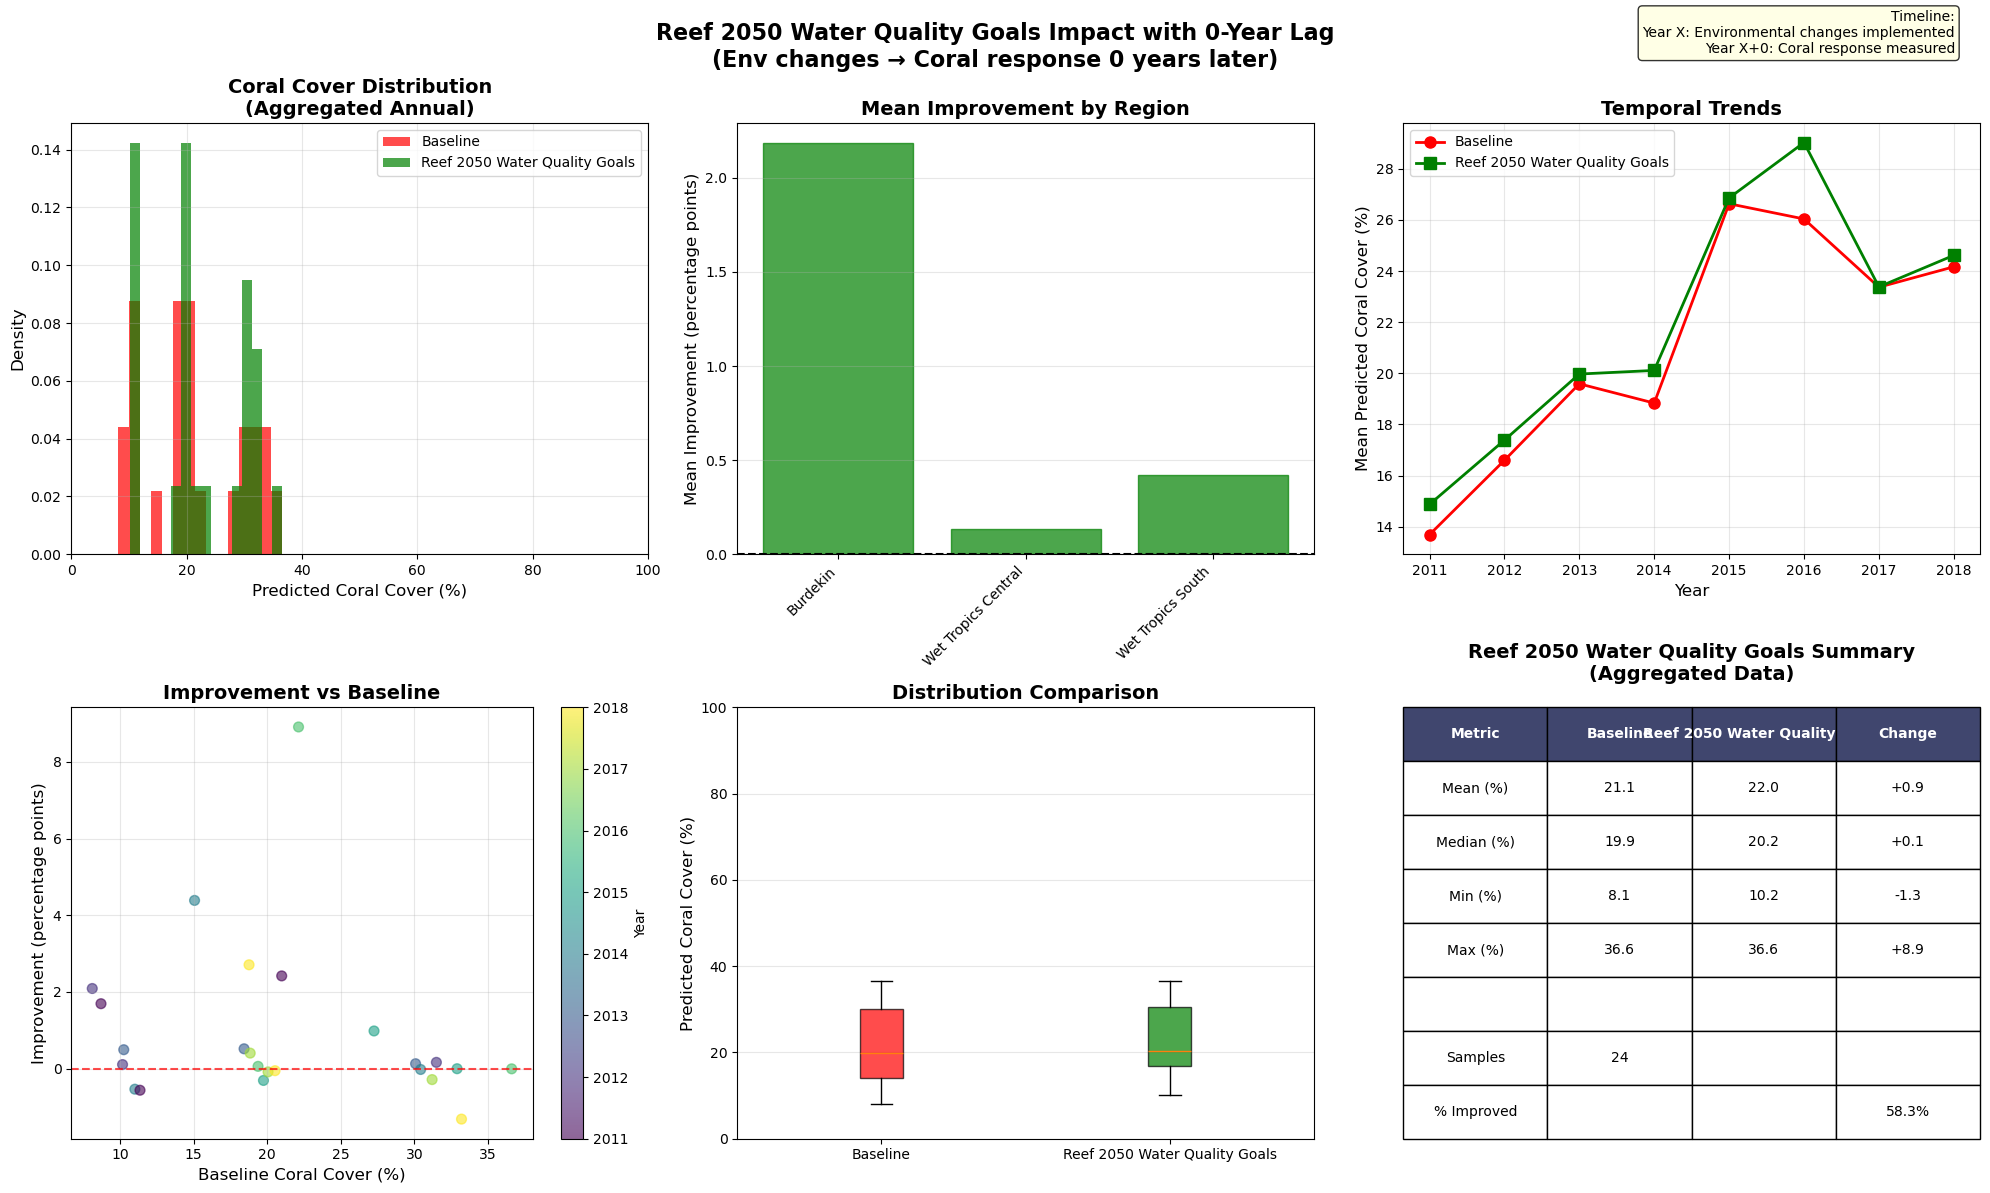

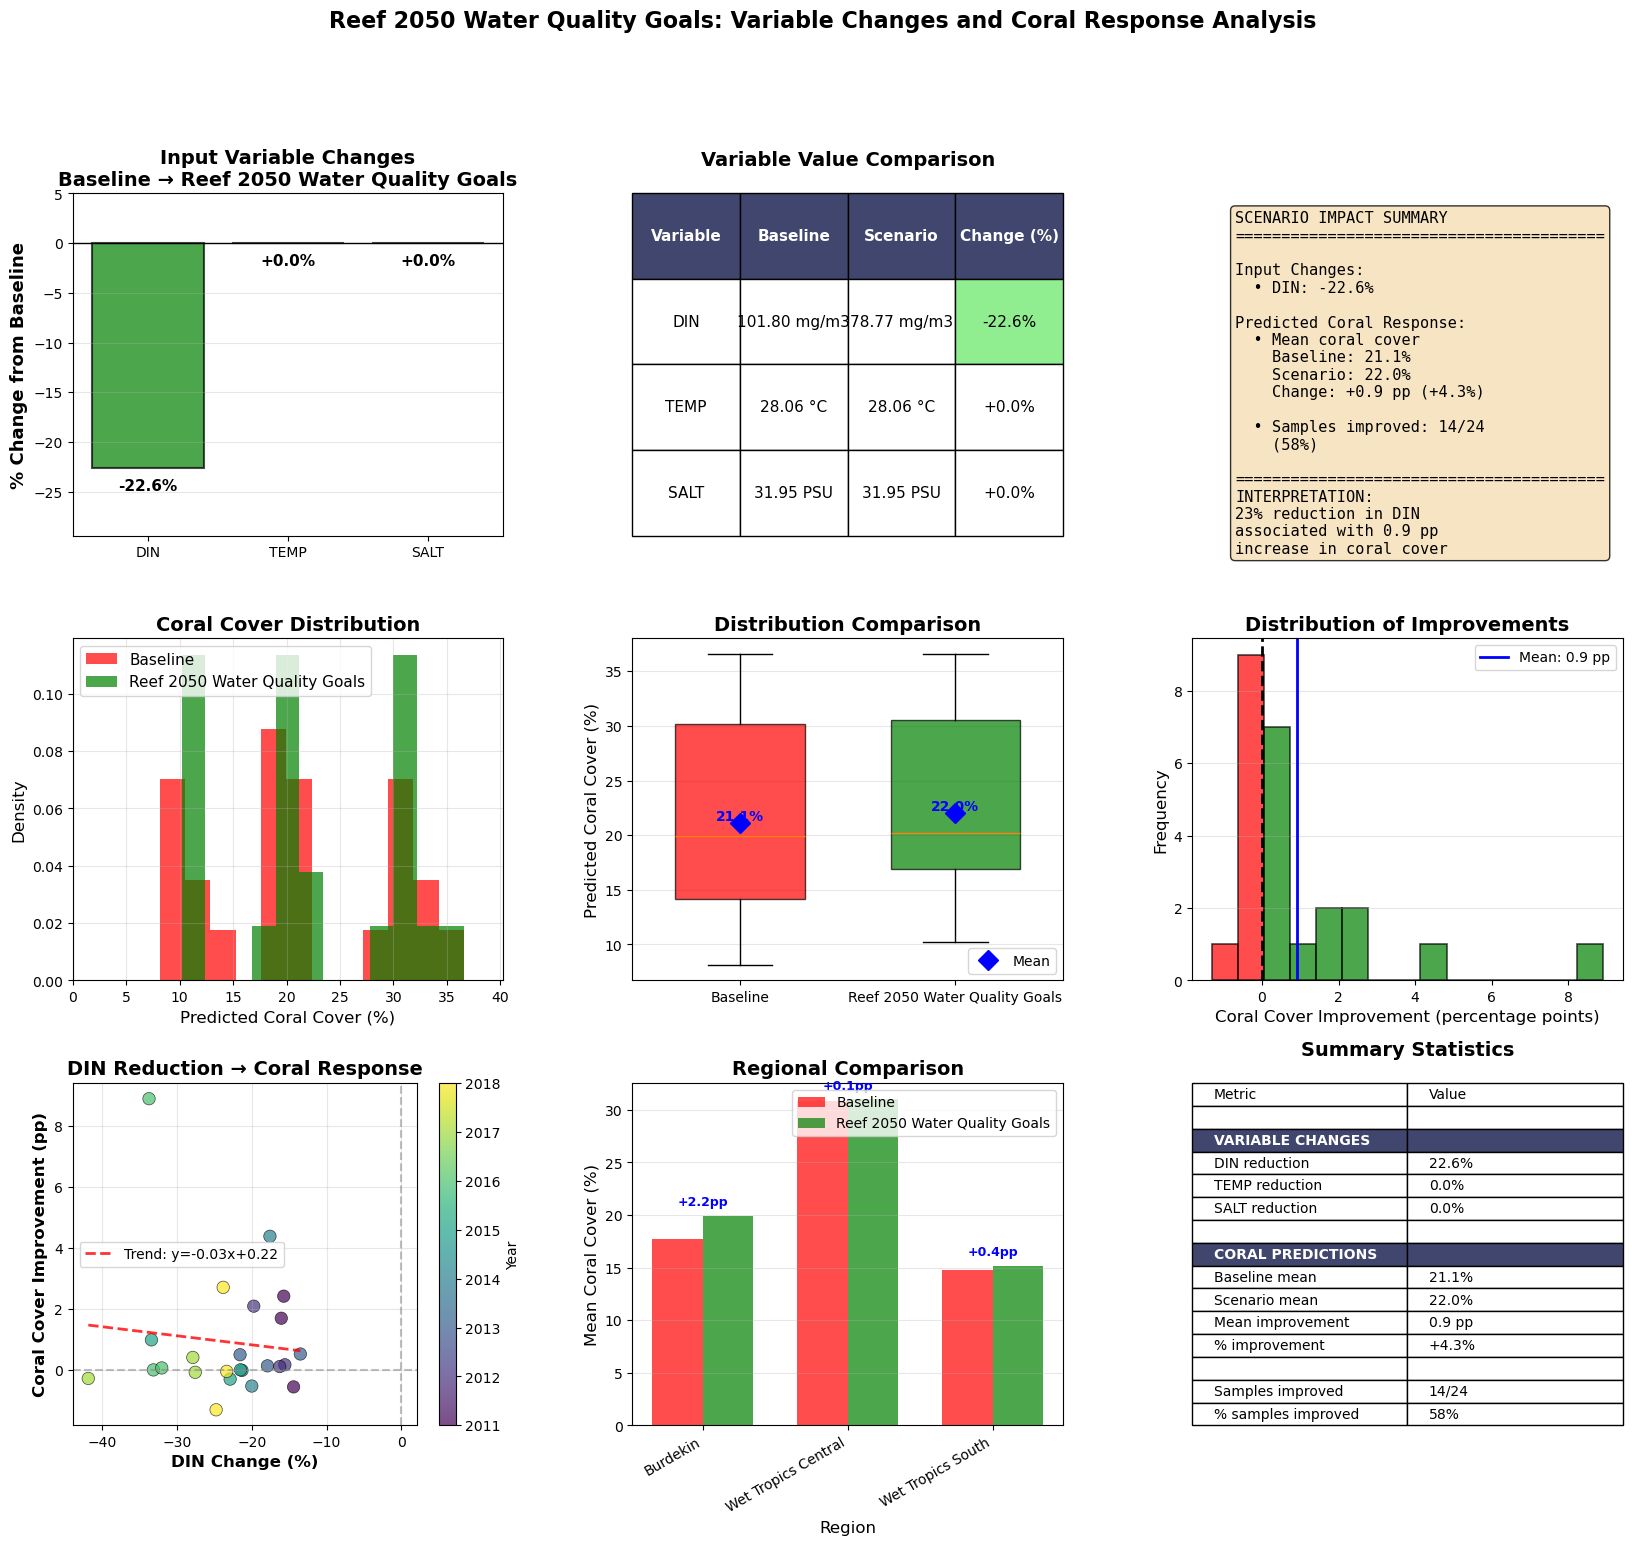

{'baseline_results': {'predictions': array([20.98675407, 31.48909358, 30.076899  , 30.420564  , 32.89351222,
         36.60085667, 31.19833167, 33.19525667,  8.71713485,  8.123975  ,
         10.26307896, 11.01786455, 19.74868386, 19.38067885, 20.05996167,
         20.53511831, 11.36630318, 10.18098583, 18.43206433, 15.0705704 ,
         27.25546444, 22.12958086, 18.84768365, 18.76998285]),
  'model_used': 'random_forest',
  'input_shape': (24, 3),
  'prediction_summary': {'mean': np.float64(21.11501664461893),
   'std': np.float64(8.555968736108529),
   'min': np.float64(8.123975000000007),
   'max': np.float64(36.60085666666663),
   'n_samples': 24},
  'model_performance': {'cv_r2_mean': np.float64(0.5191720944799627),
   'cv_r2_std': np.float64(0.31309288581752803),
   'cv_r2_all': array([ 0.58976878,  0.73701889,  0.38836528, -0.01139815,  0.89210567]),
   'cv_rmse_mean': np.float64(6.162868846331755),
   'cv_rmse_std': np.float64(2.2982159130127764),
   'train_r2': 0.9309305049167

In [44]:
complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()complete_ereefs_analysis_workflow()

# Model Enhancement Tools

## Calculate DIN thresholds

In [46]:
# Additional utility functions for advanced analysis

def calculate_multivariable_thresholds(results_package, coral_cover_targets=[20, 30, 40, 50],
                                      variable_to_vary='DIN', hold_others_at='mean'):
    """
    Calculate thresholds for one variable while holding others constant in multivariable models
    
    Parameters:
    -----------
    results_package : dict
        Output from analyze_multivariable_coral_relationship
    coral_cover_targets : list of float
        Target coral cover percentages
    variable_to_vary : str
        Which variable to calculate thresholds for ('DIN', 'temp', or 'salt')
    hold_others_at : str or dict
        How to set other variables: 'mean', 'median', or dict with specific values
        
    Returns:
    --------
    dict : Thresholds for each target
    """
    matched_data = results_package['matched_data']
    models = results_package['models']
    best_model_name = results_package['best_model']
    available_vars = models['available_vars']
    variable_aggregation = results_package.get('variable_aggregation', {})
    
    # Normalize variable name
    var_to_vary = variable_to_vary.lower()
    if var_to_vary not in available_vars:
        raise ValueError(f"{variable_to_vary} not in available variables: {available_vars}")
    
    # Set baseline values for other variables
    if isinstance(hold_others_at, str):
        if hold_others_at == 'mean':
            baseline_values = {var: matched_data[var].mean() for var in available_vars}
        elif hold_others_at == 'median':
            baseline_values = {var: matched_data[var].median() for var in available_vars}
    else:
        baseline_values = {var.lower(): val for var, val in hold_others_at.items()}
    
    # Generate range for variable to vary
    var_data = matched_data[var_to_vary]
    var_min = var_data.min() * 0.1
    var_max = var_data.max() * 2.0
    var_range = np.linspace(var_min, var_max, 1000)
    
    # Prepare input arrays
    X_test = np.zeros((len(var_range), len(available_vars)))
    var_idx = available_vars.index(var_to_vary)
    
    for i, var in enumerate(available_vars):
        if var == var_to_vary:
            X_test[:, i] = var_range
        else:
            X_test[:, i] = baseline_values[var]
    
    # Get predictions
    best_model = models[best_model_name]
    
    if best_model_name == 'linear':
        predictions = best_model.predict(X_test)
    elif best_model_name == 'random_forest':
        predictions = best_model.predict(X_test)
    elif best_model_name == 'polynomial':
        # Handle polynomial features
        X_extended = X_test.copy()
        for i, var in enumerate(available_vars):
            X_extended = np.column_stack([X_extended, np.log(np.maximum(X_test[:, i], 0.001))])
        for i in range(len(available_vars)):
            X_extended = np.column_stack([X_extended, X_test[:, i] ** 2])
        if len(available_vars) > 1:
            for i in range(len(available_vars)):
                for j in range(i + 1, len(available_vars)):
                    X_extended = np.column_stack([X_extended, X_test[:, i] * X_test[:, j]])
        X_scaled = models['scaler'].transform(X_extended)
        predictions = best_model.predict(X_scaled)
    else:
        # Single variable model
        predictions = best_model.predict(var_range.reshape(-1, 1))
    
    # Calculate thresholds
    thresholds = {}
    agg_method = variable_aggregation.get(variable_to_vary.upper(), 'mean').upper()
    
    for target in coral_cover_targets:
        diff = np.abs(predictions - target)
        closest_idx = np.argmin(diff)
        
        thresholds[f'{target}%_coral'] = {
            'target_coral_cover': target,
            f'{var_to_vary}_threshold': var_range[closest_idx],
            'achieved_coral_cover': predictions[closest_idx],
            'difference': predictions[closest_idx] - target,
            'other_variables': {var: baseline_values[var] for var in available_vars if var != var_to_vary},
            'aggregation_method': agg_method
        }
    
    return thresholds


def print_threshold_results(thresholds, variable_name='DIN'):
    """Print threshold results in formatted way"""
    print(f"\n{variable_name} Thresholds for Coral Cover Targets:")
    print("="*70)
    
    for target, info in thresholds.items():
        agg = info.get('aggregation_method', 'MEAN')
        var_key = f"{variable_name.lower()}_threshold"
        threshold_val = info[var_key]
        achieved = info['achieved_coral_cover']
        
        unit = "mg/m3" if variable_name.lower() == 'din' else "°C" if variable_name.lower() == 'temp' else "PSU"
        
        print(f"\n{target}:")
        print(f"  {variable_name}({agg}) threshold: {threshold_val:.2f} {unit}")
        print(f"  Achieved coral cover: {achieved:.1f}%")
        print(f"  Difference from target: {info['difference']:+.1f}%")
        
        if info['other_variables']:
            print(f"  Holding constant:")
            for var, val in info['other_variables'].items():
                var_unit = "mg/m3" if var == 'din' else "°C" if var == 'temp' else "PSU"
                print(f"    {var.upper()}: {val:.2f} {var_unit}")

## Sensitivity Analysis

In [47]:
def multivariable_sensitivity_analysis(results_package, variable_to_change='DIN',
                                     change_percent=[-50, -25, -10, 10, 25, 50]):
    """
    Sensitivity analysis for one variable in multivariable model
    
    Parameters:
    -----------
    results_package : dict
        Output from analyze_multivariable_coral_relationship
    variable_to_change : str
        Variable to change ('DIN', 'temp', 'salt')
    change_percent : list
        Percentage changes to test
        
    Returns:
    --------
    pandas.DataFrame : Sensitivity results
    """
    matched_data = results_package['matched_data']
    models = results_package['models']
    best_model_name = results_package['best_model']
    available_vars = models['available_vars']
    variable_aggregation = results_package.get('variable_aggregation', {})
    
    var_to_change = variable_to_change.lower()
    if var_to_change not in available_vars:
        raise ValueError(f"{variable_to_change} not in available variables: {available_vars}")
    
    # Baseline values (mean of all variables)
    baseline_values = {var: matched_data[var].mean() for var in available_vars}
    
    # Get baseline prediction
    X_baseline = np.array([[baseline_values[var] for var in available_vars]])
    best_model = models[best_model_name]
    
    if best_model_name == 'linear':
        baseline_coral = best_model.predict(X_baseline)[0]
    elif best_model_name == 'random_forest':
        baseline_coral = best_model.predict(X_baseline)[0]
    elif best_model_name == 'polynomial':
        X_ext = X_baseline.copy()
        for i, var in enumerate(available_vars):
            X_ext = np.column_stack([X_ext, np.log(np.maximum(X_baseline[0, i], 0.001))])
        for i in range(len(available_vars)):
            X_ext = np.column_stack([X_ext, X_baseline[0, i] ** 2])
        if len(available_vars) > 1:
            for i in range(len(available_vars)):
                for j in range(i + 1, len(available_vars)):
                    X_ext = np.column_stack([X_ext, X_baseline[0, i] * X_baseline[0, j]])
        X_scaled = models['scaler'].transform(X_ext)
        baseline_coral = best_model.predict(X_scaled)[0]
    
    sensitivity_data = []
    var_idx = available_vars.index(var_to_change)
    agg_method = variable_aggregation.get(variable_to_change.upper(), 'mean').upper()
    
    for change_pct in change_percent:
        new_values = baseline_values.copy()
        new_values[var_to_change] = baseline_values[var_to_change] * (1 + change_pct / 100)
        
        X_new = np.array([[new_values[var] for var in available_vars]])
        
        # Get prediction
        if best_model_name == 'linear':
            new_coral = best_model.predict(X_new)[0]
        elif best_model_name == 'random_forest':
            new_coral = best_model.predict(X_new)[0]
        elif best_model_name == 'polynomial':
            X_ext = X_new.copy()
            for i, var in enumerate(available_vars):
                X_ext = np.column_stack([X_ext, np.log(np.maximum(X_new[0, i], 0.001))])
            for i in range(len(available_vars)):
                X_ext = np.column_stack([X_ext, X_new[0, i] ** 2])
            if len(available_vars) > 1:
                for i in range(len(available_vars)):
                    for j in range(i + 1, len(available_vars)):
                        X_ext = np.column_stack([X_ext, X_new[0, i] * X_new[0, j]])
            X_scaled = models['scaler'].transform(X_ext)
            new_coral = best_model.predict(X_scaled)[0]
        
        coral_change = new_coral - baseline_coral
        coral_change_pct = (coral_change / baseline_coral) * 100 if baseline_coral != 0 else 0
        
        sensitivity_data.append({
            f'{var_to_change}_change_percent': change_pct,
            f'{var_to_change}_aggregation': agg_method,
            f'new_{var_to_change}_concentration': new_values[var_to_change],
            'predicted_coral_cover': new_coral,
            'coral_change_absolute': coral_change,
            'coral_change_percent': coral_change_pct,
            'sensitivity_ratio': coral_change_pct / change_pct if change_pct != 0 else 0
        })
    
    return pd.DataFrame(sensitivity_data)